In [1]:
#%matplotlib widget

#%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
#import matplotlib

import pandas as pd
import numpy as np
import durationpy
import math
from os.path import join
from collections import defaultdict


In [2]:
plt.style.use('ggplot')

COLORS_DEFAULT ={'blue': '#348ABD', 'red': '#E24A33'}

In [3]:
pd.set_option('display.max_rows', 1000)

In [4]:
# conda install -c phlya adjusttext 
from adjustText import adjust_text

## csv result files directory name and file names

In [5]:
CSV_RESULT_DIR = "../benchmark_results_data"

STANDALONE_WASM_RESULT_FILE = "standalone_wasm_results.csv"
NATIVE_RESULT_FILE = "native_benchmarks.csv"
SCOUT_RESULT_FILE = "scout_bignum_benchmarks.csv"
GETH_PRECOMPILE_RESULT_FILE = "geth_precompile_benchmarks.csv"
EVM_RESULT_FILE = "evm_benchmarks.csv"



## To add a new engine, add the engine name used in the csv file to this list

In [6]:
INTERPRETER_ENGINES = ['life', 'ssvm', 'wagon', 'wasmi', 'wabt', 'v8-interpreter', 'wasm3', 'wamr-interp', 'fizzy', 'eos-vm']
COMPILER_ENGINES = ['lifePolymerase', 'wasmtime', 'wavm', 'v8-liftoff', 'v8-turbofan', 'asmble', 'wamr-jit', 'wamr-aot']

wasm_vm_names = INTERPRETER_ENGINES + COMPILER_ENGINES

## Helper funcs

In [7]:
def toMs(secs):
    if secs < 0.001:
        μs = secs * 1000000
        return "{}μs".format(round(μs, 1))
    if secs < 0.1:
        ms = secs * 1000
        return "{}ms".format(round(ms, 1))
    elif secs < 1:
        ms = secs * 1000
        return "{}ms".format(int(round(ms, 0)))
    else:
        return "{}s".format(round(secs, 2))

In [8]:
def labelBarHeights(ax, to_ms=True, small=False, to_factor=False, lower_y_bound=True):
    labels = []
    for p in ax.patches:
        if p.get_height() == 0:
            continue
        label_val = p.get_height()
        #print("height:", p.get_height())
        y_pos = p.get_y() + label_val
        #y_offset = -10
        y_offset = 0
        y_bound = ax.get_ybound()[1]
        if y_pos > y_bound:
            y_pos = y_bound
        #if label_val < (0.03 * y_bound):
            # if bar is too small to fit text, place above the bar
            #y_offset = 5
        if lower_y_bound:
            if label_val < (0.03 * y_bound) and small is False:
                # don't place labels near bottom axis, adjust_text cant deal
                y_offset = 0.03 * y_bound
        
        if label_val > 1000:
            label_val = int(label_val)
        if to_ms:
            label_val = toMs(label_val)
        if to_factor:
            if not isinstance(to_factor, int):
                to_factor = 2
            label_val = str(round(label_val, to_factor)) + "x"
        """
        txt_label = ax.annotate(toMs(label_val),
                    (p.get_x()+p.get_width()/2.,
                     y_pos),
                    ha='center',
                    va='center',
                    xytext=(0, y_offset),
                    textcoords='offset points',
                    fontsize=10,
                    weight="bold")
        """
 
        txt_label = ax.text(
                    x=p.get_x()+p.get_width()/2.,
                    y=y_pos+y_offset,
                    s=label_val,
                    ha='center',
                    va='center',
                    #xytext=(0, y_offset),
                    #textcoords='offset points',
                    fontsize=10,
                    weight="bold")

        labels.append(txt_label)

    #adjust_text(labels, ax=ax)
    return labels

In [9]:
def labelBarWidths(ax, to_ms=True, to_factor=False, to_kb=False, round_places=None):
    for p in ax.patches:
        label_val = p.get_width()
        if label_val == 0:
            continue
        #print("bar width:", label_val)
        x_pos = p.get_x() + label_val
        x_offset = -30
        x_bound = ax.get_xbound()[1]
        if (x_pos > x_bound):
            x_pos = x_bound
        #if label_val < (0.25 * x_bound):
        if label_val < (0.15 * x_bound):
            # if bar is too small to fit text, place next to bar
            x_offset = 30
        if label_val > 1000:
            label_val = int(label_val)
        if to_ms:
            label_val = toMs(label_val)
        if to_factor:
            label_val = str(round(label_val, 2)) + "x"
        if to_kb:
            kbs = label_val / 1000.0
            label_val = str(round(kbs, 1)) + " kB"
        if round_places:
            label_val = str(round(label_val, round_places))
        ax.annotate(label_val,
                    (x_pos,
                     p.get_y()+p.get_height()/2.),
                    ha='center',
                    va='center',
                    xytext=(x_offset, 0),
                    textcoords='offset points',
                    fontsize=10,
                    weight="bold")


In [10]:
def adjust_text_labels(labels, ax=None):
    adjust_text(labels, ax=ax, autoalign='y', only_move={'points':'y', 'text':'y'})
                       

In [11]:
def read_results(file_name):
    results = defaultdict(list)
    csv_results = pd.read_csv(file_name)    
    return csv_results

In [12]:
def filterDfEngines(df_data, engines):
    df_data_filtered = df_data.copy()
    for fil in engines:
        df_data_filtered = df_data_filtered[df_data_filtered['engine'] != fil]

    return df_data_filtered

## print benchmark machine cpu type

In [13]:
with open(join(CSV_RESULT_DIR, "cpuinfo.txt"), 'r') as cpuinfofile:
    [print(line.rstrip()) for line in cpuinfofile.readlines()]


model name	: Intel(R) Core(TM) i5-7200U CPU @ 2.50GHz
cpu MHz		: 700.093
model name	: Intel(R) Core(TM) i5-7200U CPU @ 2.50GHz
cpu MHz		: 700.037
model name	: Intel(R) Core(TM) i5-7200U CPU @ 2.50GHz
cpu MHz		: 700.055
model name	: Intel(R) Core(TM) i5-7200U CPU @ 2.50GHz
cpu MHz		: 700.125


## Import EVM engine results

In [14]:
df_evm_raw = read_results(join(CSV_RESULT_DIR, EVM_RESULT_FILE))

In [15]:
df_evm_raw

engine                         test_name   total_time  gas_used
0        engine                         test_name   total_time  gas_used
1        evmone                   sha1-10808-bits  0.002056286    790156
2        evmone                   sha1-21896-bits   0.00393736   1543605
3        evmone                   sha1-42488-bits  0.007656268   3014404
4        evmone          sha1-10808-bits-shiftopt  0.001038472    759785
5        evmone          sha1-21896-bits-shiftopt  0.002031567   1484254
6        evmone          sha1-42488-bits-shiftopt  0.004000971   2898473
7        evmone               bn256g2mul-0xAshish  0.001509638    455757
8        evmone       blake2b-8415-bytes-shiftopt  0.018414062  12043105
9        evmone       blake2b-5610-bytes-shiftopt   0.01218996   7434820
10       evmone       blake2b-2805-bytes-shiftopt  0.006019918   3423526
11       evmone          mul256-gcolvin-drag-race  0.009680082   5610277
12       evmone   bn128_mul_weierstrudel-cdetrio2  0.000397231     47165
13       evmone    bn128_mul_weierstrudel-chfast1  0.000210124     23449
14       evmone    bn128_mul_weierstrudel-chfast2  0.000339741     39337
15       evmone    bn128_mul_weierstrudel-chfast3  0.000399416     47291
16       evmone   bn128_mul_weierstrudel-cdetrio6   0.00039595     47561
17       evmone   bn128_mul_weierstrudel-cdetrio7  0.000398454     47165
18       evmone  bn128_mul_weierstrudel-cdetrio11  0.000404129     47561
19       evmone  bn128_mul_weierstrudel-cdetrio12  0.000396089     47165
20       evmone                blake2b-8415-bytes  0.022527799  12351815
21       evmone                blake2b-5610-bytes  0.015275491   7640669
22       evmone                blake2b-2805-bytes  0.007459261   3526514
23       evmone           blake2b_huff-8415-bytes  0.001514828    879920
24       evmone           blake2b_huff-5610-bytes  0.001142694    586839
25       evmone           blake2b_huff-2805-bytes  0.000524197    293755
26       engine                         test_name   total_time  gas_used
27   parity-evm                   sha1-10808-bits  0.069457059    790156
28   parity-evm                   sha1-21896-bits  0.128567939   1543605
29   parity-evm                   sha1-42488-bits  0.250837896   3014404
30   parity-evm          sha1-10808-bits-shiftopt  0.026990627    759785
31   parity-evm          sha1-21896-bits-shiftopt  0.047456338   1484254
32   parity-evm          sha1-42488-bits-shiftopt  0.092930734   2898473
33   parity-evm               bn256g2mul-0xAshish  0.024067669    455757
34   parity-evm       blake2b-8415-bytes-shiftopt  0.302345632  12043105
35   parity-evm       blake2b-5610-bytes-shiftopt  0.216411367   7434820
36   parity-evm       blake2b-2805-bytes-shiftopt  0.116367526   3423526
37   parity-evm          mul256-gcolvin-drag-race  0.143134311   5610277
38   parity-evm   bn128_mul_weierstrudel-cdetrio2  0.004681313     47165
39   parity-evm    bn128_mul_weierstrudel-chfast1  0.002312094     23449
40   parity-evm    bn128_mul_weierstrudel-chfast2  0.003910487     39337
41   parity-evm    bn128_mul_weierstrudel-chfast3  0.004720527     47291
42   parity-evm   bn128_mul_weierstrudel-cdetrio6  0.004867541     47561
43   parity-evm   bn128_mul_weierstrudel-cdetrio7  0.004679791     47165
44   parity-evm  bn128_mul_weierstrudel-cdetrio11  0.004646788     47561
45   parity-evm  bn128_mul_weierstrudel-cdetrio12  0.004630612     47165
46   parity-evm                blake2b-8415-bytes  0.340011586  12351815
47   parity-evm                blake2b-5610-bytes  0.205717038   7640669
48   parity-evm                blake2b-2805-bytes  0.096635901   3526514
49   parity-evm           blake2b_huff-8415-bytes  0.026595507    879920
50   parity-evm           blake2b_huff-5610-bytes   0.01661306    586839
51   parity-evm           blake2b_huff-2805-bytes  0.009291144    293755
52       engine                         test_name   total_time  gas_used
53     geth-evm                   sha1-10808-bits  0.015162857    7

## Import scout engine results

In [16]:
df_scout_data = read_results(join(CSV_RESULT_DIR, SCOUT_RESULT_FILE))

## functions for plotting a two engine comparison

In [17]:
## we aren't using this chart style anymore. replaced by plotThreeTestsGrouped()
def plotTwoEngines(df_benches, two_engines, title="Title"):
    df_1 = df_benches[df_benches['engine'] == two_engines[0]]
    df_2 = df_benches[df_benches['engine'] == two_engines[1]]
    plt.figure()
    f, (ax1) = plt.subplots(1, 2, sharey=True, figsize=(13,6))

    df_1.set_index('bench_name').sort_values('exec_time')[['exec_time']].plot.bar(ax=ax1[0], color=COLORS_DEFAULT['blue'])
    ax1[0].set_title(two_engines[0])
    ax1[0].set(ylabel='seconds', xlabel='')
    df_2.set_index('bench_name').sort_values('exec_time')[['exec_time']].plot.bar(ax=ax1[1], color=COLORS_DEFAULT['blue'])
    ax1[1].set_title(two_engines[1])
    ax1[1].set(xlabel='')
    adjust_text_labels(labelBarHeights(ax1[0]), ax=ax1[0])
    adjust_text_labels(labelBarHeights(ax1[1]), ax=ax1[1])
    f.suptitle(title, fontsize=16, y=0.98)
    return plt


#df_sha256_1024 = df_scout_data[df_scout_data['bench_name'].str.contains('sha256_1024')]
#df_blake2b_64 = df_scout_data[df_scout_data['bench_name'].str.contains('blake2b_64')]
#plotTwoEngines(df_sha256_1024, ["wabt-baseline", "wabt-with-superops"], "sha256 1024 bytes")
#plotTwoEngines(df_blake2b_64, ["wabt-baseline", "wabt-with-superops"], "blake2b 64 bytes")

In [18]:
def plotThreeTestsGrouped(df_benches, three_tests, title="Title"):
    df_1 = df_benches[df_benches['bench_name'].str.contains(three_tests[0])]
    df_2 = df_benches[df_benches['bench_name'].str.contains(three_tests[1])]
    df_3 = df_benches[df_benches['bench_name'].str.contains(three_tests[2])]
    # to group by engine, pivot to `columns='enginge'`
    df_1 = pd.pivot_table(df_1, values='exec_time', columns=['engine'], index=['bench_name'], aggfunc=np.mean)
    df_2 = pd.pivot_table(df_2, values='exec_time', columns=['engine'], index=['bench_name'], aggfunc=np.mean)
    df_3 = pd.pivot_table(df_3, values='exec_time', columns=['engine'], index=['bench_name'], aggfunc=np.mean)

    plt.figure()
    f, (ax1) = plt.subplots(1, 3, sharey=True, figsize=(13,6))

    df_1.sort_values('wabt-with-superops').plot.bar(ax=ax1[0])
    ax1[0].set_title(three_tests[0])
    ax1[0].set(ylabel='seconds', xlabel='')

    df_2.sort_values('wabt-with-superops').plot.bar(ax=ax1[1])
    ax1[1].set_title(three_tests[1])
    ax1[1].set(xlabel='')

    df_3.sort_values('wabt-with-superops').plot.bar(ax=ax1[2])
    ax1[2].set_title(three_tests[2])
    ax1[2].set(xlabel='')

    adjust_text_labels(labelBarHeights(ax1[0]), ax=ax1[0])
    adjust_text_labels(labelBarHeights(ax1[1]), ax=ax1[1])
    adjust_text_labels(labelBarHeights(ax1[2]), ax=ax1[2])

    f.suptitle(title, fontsize=16, y=0.98)
    return plt


## Compare wabt-optimized against wabt-baseline on hash function benchmarks

## TODO: temporarily disabled until new C_ewasm data

In [19]:
#fig_plt = plotThreeTestsGrouped(df_scout_data, ["blake2b_64", "blake2b_256", "blake2b_1024"], "blake2b C implementations compared")

#fig_plt.savefig('../images/hashfuncs-blake2b-C-compared-wabt-baseline-vs-superops.png', bbox_inches='tight')

In [20]:
#fig_plt = plotThreeTestsGrouped(df_scout_data, ["sha256_64", "sha256_256", "sha256_1024"], "sha256 C implementations compared")

#fig_plt.savefig('../images/hashfuncs-sha256-C-compared-wabt-baseline-vs-superops.png', bbox_inches='tight')


In [21]:
#fig_plt = plotThreeTestsGrouped(df_scout_data, ["keccak256_64", "keccak256_256", "keccak256_1024"], "keccak256 C implementations compared")

#fig_plt.savefig('../images/hashfuncs-keccak256-C-compared-wabt-baseline-vs-superops.png', bbox_inches='tight')


## functions for plotting biturbo and bignum benchmarks

In [22]:
# non-stacked bar chart, for only plotting exec time or total time
def plotOneTestUsingTimeCol(df_data, time_col_name="time", suptitle="title", suptitle_pos=1.00, subtitle="subchart", subtitle_size='medium'):
    plt.style.use('ggplot')
    plt.figure()
    df_total_times = df_data.copy()
    ax = df_total_times.sort_values(time_col_name)[[time_col_name]].plot.bar(figsize=(14,8), color=COLORS_DEFAULT['blue'])
    # fontsize = {size in points, 'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
    ax.set_title(subtitle, fontsize=subtitle_size)
    ax.set(ylabel="seconds", xlabel="")
    ax.xaxis.set_tick_params(labelrotation=60, labelsize=12)
    adjust_text_labels(labelBarHeights(ax))
    plt.suptitle(suptitle, fontsize=18, y=suptitle_pos)
    return plt

In [23]:
# non-stacked bar chart, for only plotting exec time or total time
def plotOneTest(df_data, suptitle="title", suptitle_pos=1.00, subtitle="subchart", subtitle_size='medium'):
    plt.style.use('ggplot')
    plt.figure()
    df_total_times = df_data[['exec_time', 'parse_time']].copy()
    df_total_times.fillna(0, inplace=True)
    df_total_times['time'] = df_total_times['exec_time'] + df_total_times['parse_time']
    ax = df_total_times.sort_values('time')[['time']].plot.bar(figsize=(14,8), color=COLORS_DEFAULT['blue'])
    # fontsize = {size in points, 'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
    ax.set_title(subtitle, fontsize=subtitle_size)
    ax.set(ylabel="seconds", xlabel="")
    ax.xaxis.set_tick_params(labelrotation=60, labelsize=12)
    adjust_text_labels(labelBarHeights(ax))
    plt.suptitle(suptitle, fontsize=18, y=suptitle_pos)
    return plt


In [24]:
# non-stacked bar chart, for only plotting exec time or total time
def plotOneTestColoredTicksBLS(df_data, suptitle="title", suptitle_pos=1.00, subtitle="subchart", subtitle_size='medium', highlight_ticks=None):
    #f = plt.figure(figsize=[14, 8])
    #plt.figure(figsize=[14, 8])
    plt.style.use('ggplot')
    plt.figure()
    df_total_times = df_data[['exec_time', 'parse_time']].copy()
    df_total_times.fillna(0, inplace=True)
    df_total_times['time'] = df_total_times['exec_time'] + df_total_times['parse_time']
    ax = df_total_times.sort_values('time')[['time']].plot.bar(figsize=(14,8), color=COLORS_DEFAULT['blue'])
    # fontsize = {size in points, 'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
    ax.set_title(subtitle, fontsize=subtitle_size)
    ax.set(ylabel="seconds", xlabel="")
    ax.xaxis.set_tick_params(labelrotation=85, labelsize=12)
    if highlight_ticks is not None:
        for highlight_tick in highlight_ticks:
            for i in plt.gca().get_xticklabels():
                if i.get_text() == highlight_tick:
                    i.set_color('tab:green')
                    i.set_fontstyle('oblique')
                    i.set_fontweight('heavy')

        # {'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'}
        #[i.set_color('tab:green') for i in plt.gca().get_xticklabels() if i.get_text() == highlight_tick]
    adjust_text_labels(labelBarHeights(ax))
    plt.suptitle(suptitle, fontsize=18, y=suptitle_pos)
    return plt



In [25]:
# non-stacked bar chart, for only plotting exec time or total time
def plotOneTestColoredTicks(df_data, suptitle="title", suptitle_pos=1.00, subtitle="subchart", subtitle_size='medium', highlight_ticks=None):
    #f = plt.figure(figsize=[14, 8])
    #plt.figure(figsize=[14, 8])
    plt.style.use('ggplot')
    plt.figure()
    df_total_times = df_data[['exec_time', 'parse_time']].copy()
    df_total_times.fillna(0, inplace=True)
    df_total_times['time'] = df_total_times['exec_time'] + df_total_times['parse_time']
    ax = df_total_times.sort_values('time')[['time']].plot.bar(figsize=(14,8), color=COLORS_DEFAULT['blue'])
    # fontsize = {size in points, 'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
    ax.set_title(subtitle, fontsize=subtitle_size)
    ax.set(ylabel="seconds", xlabel="")
    ax.xaxis.set_tick_params(labelrotation=60, labelsize=12)
    if highlight_ticks is not None:
        for highlight_tick in highlight_ticks:
            for i in plt.gca().get_xticklabels():
                if i.get_text() == highlight_tick:
                    i.set_color('tab:green')
                    i.set_fontstyle('oblique')
                    i.set_fontweight('heavy')

        # {'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'}
        #[i.set_color('tab:green') for i in plt.gca().get_xticklabels() if i.get_text() == highlight_tick]
    adjust_text_labels(labelBarHeights(ax))
    plt.suptitle(suptitle, fontsize=18, y=suptitle_pos)
    return plt



In [26]:
def plotOneTestGrouped(df_1, test_title="test_title", title="plot Title", colors=['tab:blue', 'tab:orange'], sort_by='websnark-bn128-two-pairings', group_order=None):
    # to group by engine, pivot to `columns='engine'`
    #df_1 = pd.pivot_table(df_1, values='exec_time', columns=['engine'], index=['bench_name'], aggfunc=np.mean)
    # group by bench name
    plt.style.use('ggplot')
    df_1['time'] = df_1['exec_time'] + df_1['parse_time']
    df_1 = pd.pivot_table(df_1, values='time', columns=['bench_name'], index=['engine'], aggfunc=np.mean)
    # order to get websnark as the group on the left
    if group_order is not None:
        df_1 = df_1[group_order]

    plt.figure()
    ax = df_1.sort_values(sort_by).plot.bar(figsize=(14,8), color=colors)
    #ax = df_1.plot.bar(figsize=(14,8))
    ax.set_title(test_title)
    ax.set(ylabel='seconds', xlabel='')

    adjust_text_labels(labelBarHeights(ax))

    plt.suptitle(title, fontsize=16, y=0.98)
    return plt


In [27]:
def plotOneTestGroupedExexTime(df_1, test_title="test_title", title="plot Title", colors=['tab:blue', 'tab:orange'], sort_by='websnark-bn128-two-pairings', group_order=None):
    # to group by engine, pivot to `columns='engine'`
    #df_1 = pd.pivot_table(df_1, values='exec_time', columns=['engine'], index=['bench_name'], aggfunc=np.mean)
    # group by bench name
    plt.style.use('ggplot')
    df_1['time'] = df_1['exec_time']
    df_1 = pd.pivot_table(df_1, values='time', columns=['bench_name'], index=['engine'], aggfunc=np.mean)
    # order to get websnark as the group on the left
    if group_order is not None:
        df_1 = df_1[group_order]

    plt.figure()
    ax = df_1.sort_values(sort_by).plot.bar(figsize=(14,8), color=colors)
    #ax = df_1.plot.bar(figsize=(14,8))
    ax.set_title(test_title)
    ax.set(ylabel='seconds', xlabel='')

    adjust_text_labels(labelBarHeights(ax))

    plt.suptitle(title, fontsize=16, y=0.98)
    return plt

In [28]:
def plotScoutStackedTest(df_data, suptitle="title", suptitle_pos=1.00, subtitle="subchart", subtitle_size='medium'):
    #plt.figure(figsize=[12,7])
    plt.figure()
    # for some reason, exec_time needs to come first for the stacked chart to display correctly
    ax = df_data[['exec_time', 'parse_time']].sort_values('exec_time').plot.bar(stacked=True, color=[COLORS_DEFAULT['blue'], COLORS_DEFAULT['red']], figsize=(10,10))
    # fontsize = {size in points, 'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
    ax.set_title(subtitle, fontsize=subtitle_size)
    ax.set(ylabel="seconds", xlabel="")
    df_total_times = df_data[['exec_time', 'parse_time']].copy()
    df_total_times['total_time'] = df_total_times['exec_time'] + df_total_times['parse_time']
    ax.xaxis.set_tick_params(labelrotation=60, labelsize=12)
    adjust_text_labels(labelBarHeights(ax, lower_y_bound=False))
    ax.legend(labels=["execution time", "startup time"])
    plt.suptitle(suptitle, fontsize=18, y=suptitle_pos)
    #ax.autoscale(enable=True) 
    return plt


## Plot biturbo benchmark: biturbo-token-eth1-mainnet-stateless-block-hexary-trie-keccak256-multiproof

In [29]:
df_scout_biturbo_token = df_scout_data[df_scout_data['bench_name'] == 'biturbo-token-eth1-mainnet-stateless-block-hexary-trie-keccak256-multiproof']

df_scout_means_biturbo_token = df_scout_biturbo_token.groupby(['engine']).mean()
df_scout_fast_biturbo_token = filterDfEngines(df_scout_biturbo_token, ['v8-interpreter'])
df_scout_fast_biturbo_means = df_scout_fast_biturbo_token.groupby(['engine']).mean()



<Figure size 432x288 with 0 Axes>

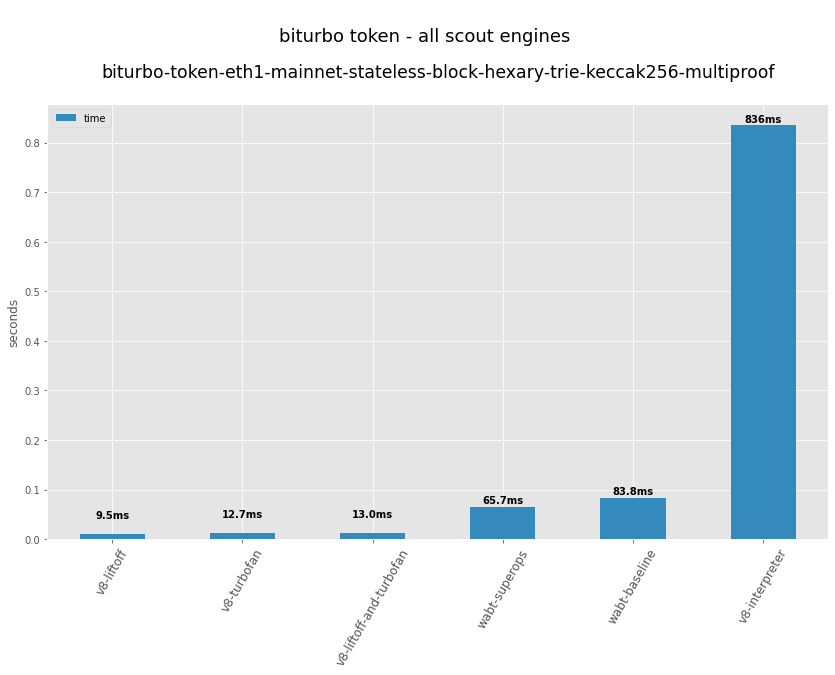

In [30]:
fig_plt = plotOneTest(df_scout_means_biturbo_token,
            suptitle="\nbiturbo token - all scout engines",
            suptitle_pos=1.05,
            subtitle="biturbo-token-eth1-mainnet-stateless-block-hexary-trie-keccak256-multiproof\n",
            subtitle_size='xx-large')

fig_plt.savefig('../images/scout-biturbo-token-all-engines.png', bbox_inches='tight')


<Figure size 432x288 with 0 Axes>

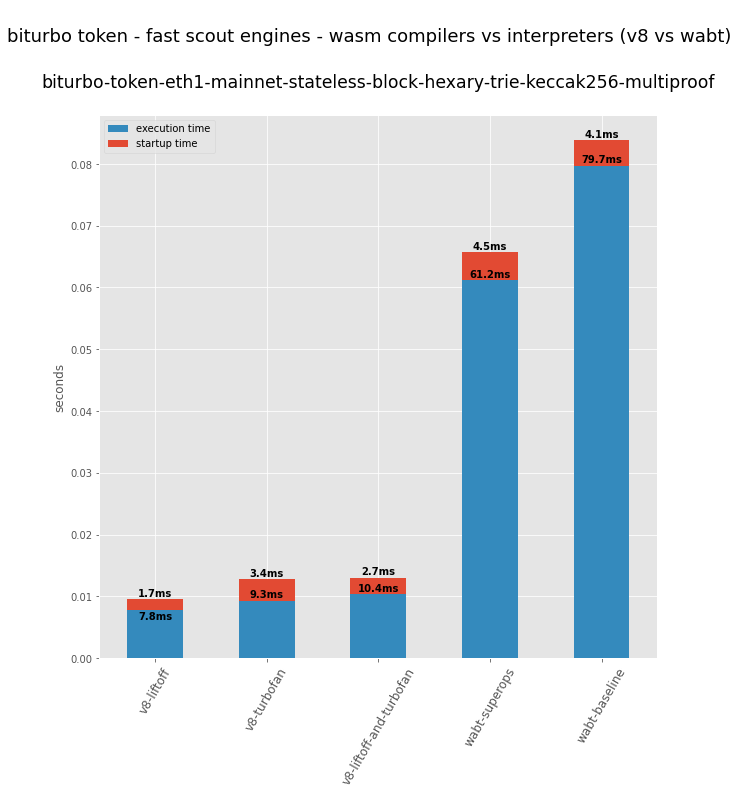

In [31]:
fig_plt = plotScoutStackedTest(df_scout_fast_biturbo_means,
            suptitle="\nbiturbo token - fast scout engines - wasm compilers vs interpreters (v8 vs wabt)",
            suptitle_pos=1.03,
            subtitle="biturbo-token-eth1-mainnet-stateless-block-hexary-trie-keccak256-multiproof\n",
            subtitle_size='xx-large')

fig_plt.savefig('../images/scout-biturbo-token-compilers-vs-interpreters.png', bbox_inches='tight')



## Plot bignum benchmark: ecrecover-eth1-txns-websnark-secp256k1-verify-72-sigs

In [32]:
df_scout_ecrecover_websnark_secp256k1 = df_scout_data[df_scout_data['bench_name'] == 'ecrecover-eth1-txns-websnark-secp256k1-verify-72-sigs']

df_scout_means_ecrecover_websnark_secp256k1 = df_scout_ecrecover_websnark_secp256k1.groupby(['engine']).mean()
df_scout_fast_ecrecover = filterDfEngines(df_scout_ecrecover_websnark_secp256k1,
    ['v8-interpreter', 'scoutcpp-wabt-no-bignums', 'wabt-no-bignums'])
df_scout_fast_ecrecover_means = df_scout_fast_ecrecover.groupby(['engine']).mean()


<Figure size 432x288 with 0 Axes>

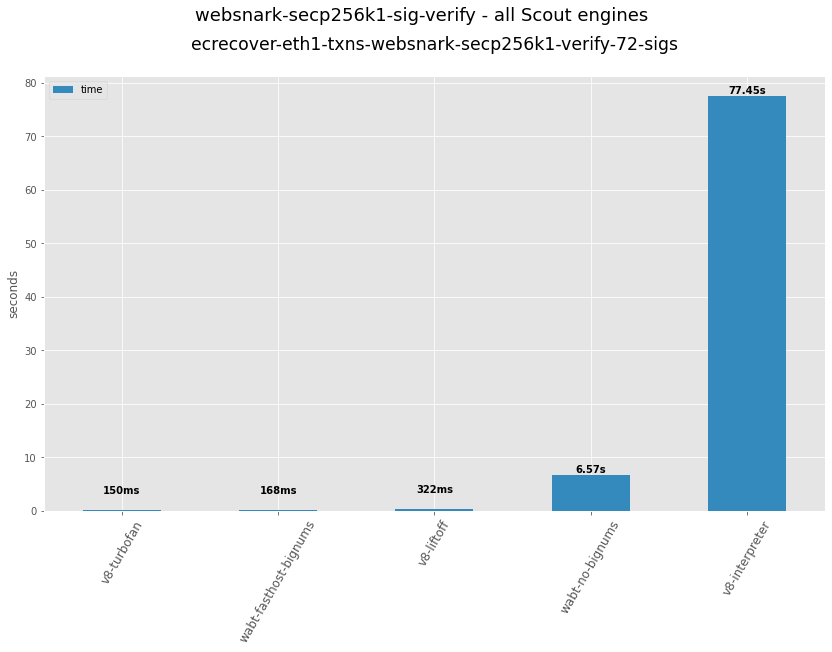

In [33]:
fig_plt = plotOneTest(df_scout_means_ecrecover_websnark_secp256k1,
            suptitle="websnark-secp256k1-sig-verify - all Scout engines",
            suptitle_pos=1.0,
            subtitle="ecrecover-eth1-txns-websnark-secp256k1-verify-72-sigs\n",
            subtitle_size='xx-large')


fig_plt.savefig('../images/scout-ecrecover-websnark-secp256k1-verify-72-sigs-all-engines.png', bbox_inches='tight')


<Figure size 432x288 with 0 Axes>

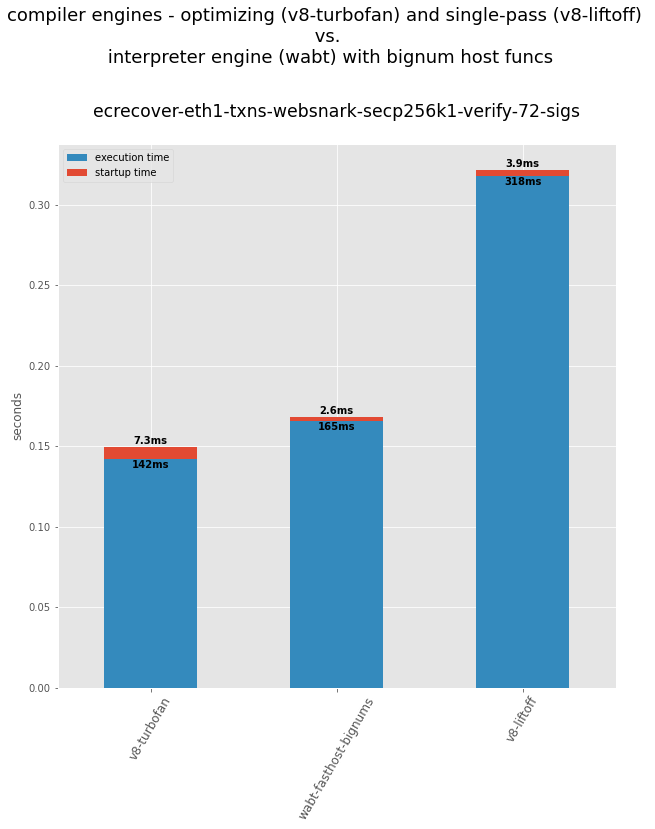

In [34]:
fig_plt = plotScoutStackedTest(df_scout_fast_ecrecover_means,
            #suptitle="websnark-secp256k1-sig-verify - fast Scout engines - compilers (v8) vs interpreters (wabt)",
            suptitle="compiler engines - optimizing (v8-turbofan) and single-pass (v8-liftoff) \n vs. \n interpreter engine (wabt) with bignum host funcs",
            suptitle_pos=1.07,
            subtitle="ecrecover-eth1-txns-websnark-secp256k1-verify-72-sigs\n",
            subtitle_size='xx-large')

fig_plt.savefig('../images/scout-ecrecover-websnark-secp256k1-verify-72-sigs-wabt-vs-v8.png', bbox_inches='tight')


## Plot bignum benchmark: ecpairing-zkrollup-websnark-bn128-two-pairings

In [35]:
df_scout_ecpairing_zkrollup_bn128_pairings = df_scout_data[df_scout_data['bench_name'] == 'ecpairing-zkrollup-websnark-bn128-two-pairings']

df_scout_means_ecpairing_zkrollup = df_scout_ecpairing_zkrollup_bn128_pairings.groupby(['engine']).mean()
df_scout_fast_ecpairing_zkrollup = filterDfEngines(df_scout_ecpairing_zkrollup_bn128_pairings,
    ['v8-interpreter', 'scoutcpp-wabt-no-bignums', 'wabt-no-bignums'])
df_scout_fast_means_ecpairing_zkrollup = df_scout_fast_ecpairing_zkrollup.groupby(['engine']).mean()


<Figure size 432x288 with 0 Axes>

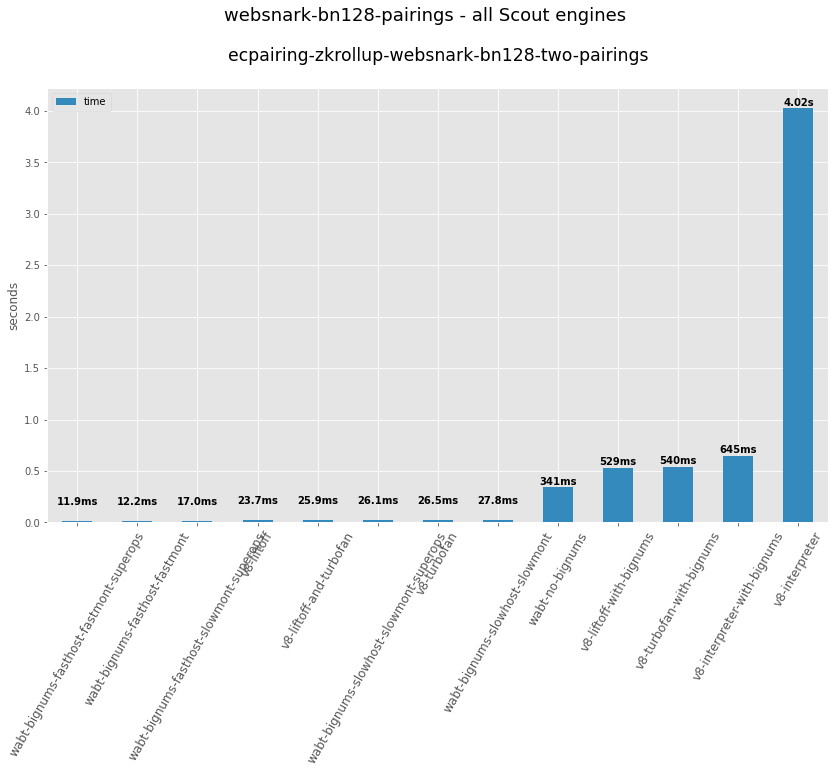

In [36]:
fig_plt = plotOneTest(df_scout_means_ecpairing_zkrollup,
            suptitle="websnark-bn128-pairings - all Scout engines",
            suptitle_pos=1.02,
            subtitle="ecpairing-zkrollup-websnark-bn128-two-pairings\n",
            subtitle_size='xx-large')

fig_plt.savefig('../images/scout-ecpairing-zkrollup-websnark-bn128-two-pairings-all-engines.png', bbox_inches='tight')


<Figure size 432x288 with 0 Axes>

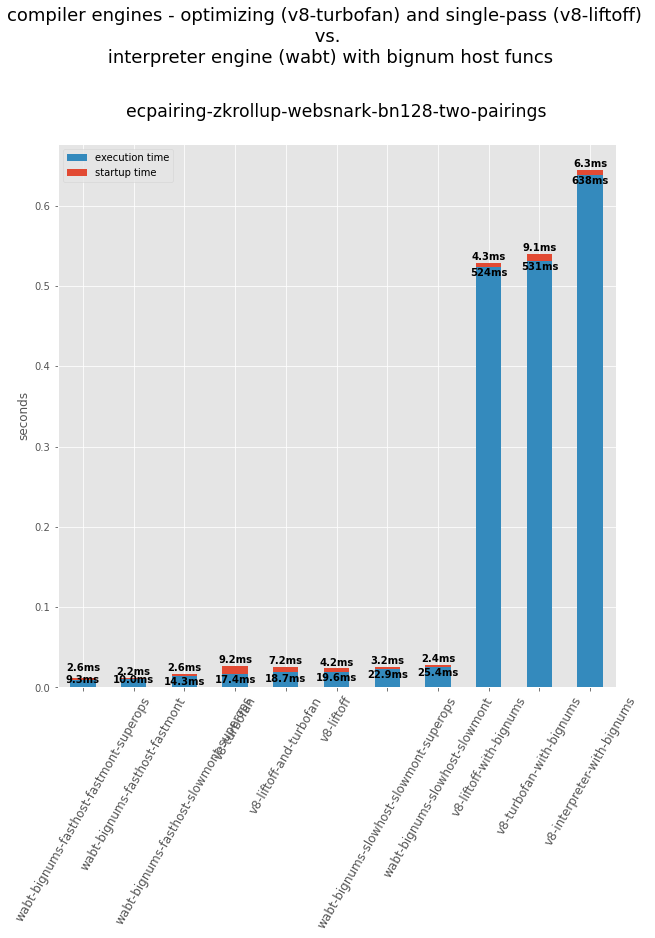

In [37]:
fig_plt = plotScoutStackedTest(df_scout_fast_means_ecpairing_zkrollup,
            suptitle="compiler engines - optimizing (v8-turbofan) and single-pass (v8-liftoff) \n vs. \n interpreter engine (wabt) with bignum host funcs",
            suptitle_pos=1.07,
            subtitle="ecpairing-zkrollup-websnark-bn128-two-pairings\n",
            subtitle_size='xx-large')
fig_plt.savefig('../images/scout-ecpairing-zkrollup-websnark-bn128-two-pairings-v8.png', bbox_inches='tight')

## start with rust bn128 pairings, compare to native, and compare interpreters to compilers

In [38]:
df_scout_rolluprs_bn128_pairings = df_scout_data[df_scout_data['bench_name'] == 'ecpairing-zkrollup-rust-wasm-bn128-two-pairings']

df_scout_fast_rolluprs = filterDfEngines(df_scout_rolluprs_bn128_pairings,
    ['scoutcpp-wabt-no-bignums', 'wabt-no-bignums'])

df_scout_means_rolluprs = df_scout_rolluprs_bn128_pairings.groupby(['engine']).mean()

#df_scout_fast_means_rolluprs = df_scout_fast_rolluprs.groupby(['engine']).mean()


<Figure size 432x288 with 0 Axes>

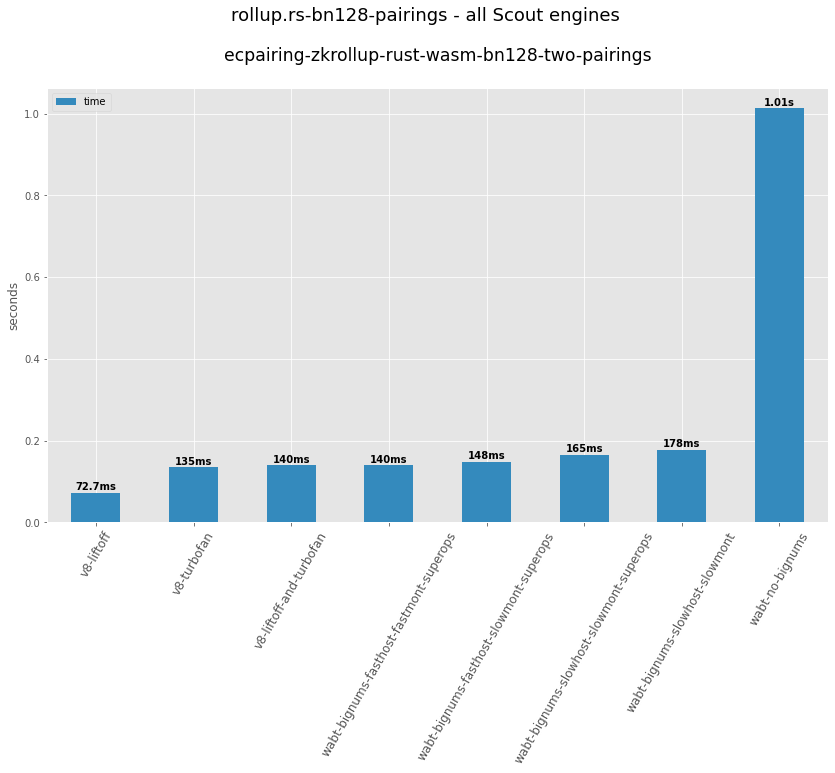

In [39]:
fig_plt = plotOneTest(df_scout_means_rolluprs,
            suptitle="rollup.rs-bn128-pairings - all Scout engines",
            suptitle_pos=1.02,
            subtitle="ecpairing-zkrollup-rust-wasm-bn128-two-pairings\n",
            subtitle_size='xx-large')

fig_plt.savefig('../images/scout-ecpairing-zkrollup-rust-wasm-bn128-two-pairings-all-engines.png', bbox_inches='tight')

## websnark bn128 pairings versus rust->wasm bn128 pairings

### add rust-native to rust-wasm

In [40]:
df_scout_rolluprs_bn128_pairings = df_scout_data[df_scout_data['bench_name'].isin(
    ['ecpairing-zkrollup-rust-wasm-bn128-two-pairings', 'ecpairing-zkrollup-rust-native-bn128-two-pairings']
)]

#df_scout_rolluprs_rustnative = df_scout_rolluprs_rustnative.fillna(0)

df_scout_means_rolluprs = df_scout_rolluprs_bn128_pairings.groupby(['engine']).mean()
df_scout_fast_rolluprs = filterDfEngines(df_scout_rolluprs_bn128_pairings,
    ['v8-interpreter', 'scoutcpp-wabt-no-bignums', 'wabt-no-bignums'])
df_scout_fast_means_rolluprs = df_scout_fast_rolluprs.groupby(['engine']).mean()

<Figure size 432x288 with 0 Axes>

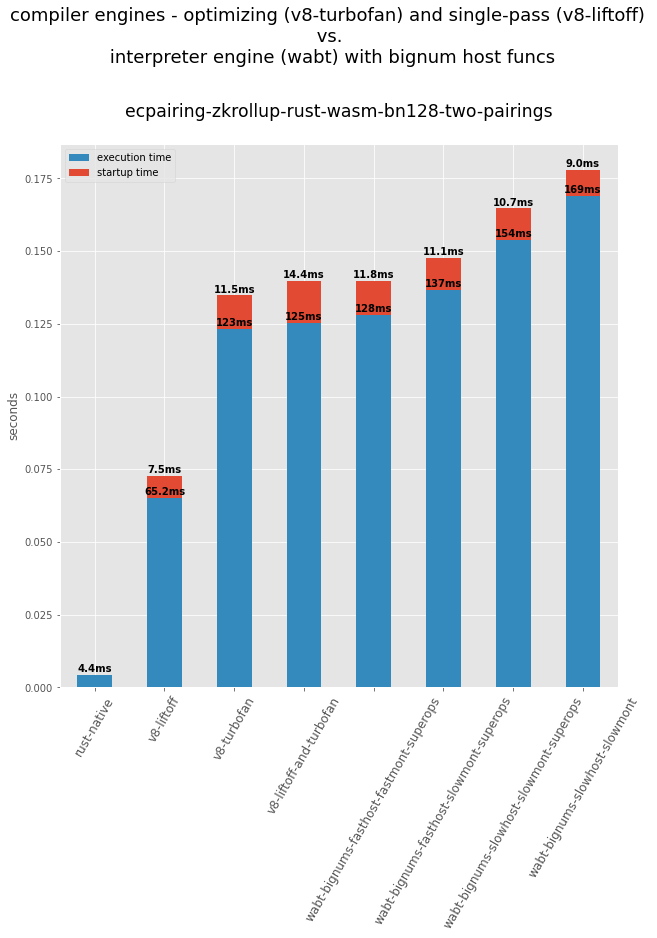

In [41]:
fig_plt = plotScoutStackedTest(df_scout_fast_means_rolluprs,
            suptitle="compiler engines - optimizing (v8-turbofan) and single-pass (v8-liftoff) \n vs. \n interpreter engine (wabt) with bignum host funcs",
            suptitle_pos=1.07,
            subtitle="ecpairing-zkrollup-rust-wasm-bn128-two-pairings\n",
            subtitle_size='xx-large')
fig_plt.savefig('../images/scout-ecpairing-zkrollup-rust-wasm-bn128-two-pairings-v8.png', bbox_inches='tight')

# rust vs websnark

In [42]:
df_scout_rust_vs_websnark = df_scout_data[
    df_scout_data['bench_name'].isin(
        ['ecpairing-zkrollup-rust-wasm-bn128-two-pairings',
         'ecpairing-zkrollup-websnark-bn128-two-pairings']
    )
].copy()


In [43]:
#df_scout_rust_vs_websnark

In [44]:
#df_scout_rust_vs_websnark.replace('ecpairing-zkrollup-rust-wasm-bn128-two-pairings', 'rust-wasm-bn128-two-pairings', inplace=True)
#df_scout_rust_vs_websnark.replace('ecpairing-zkrollup-websnark-bn128-two-pairings', 'websnark-bn128-two-pairings', inplace=True)

df_scout_rust_vs_websnark.replace('ecpairing-zkrollup-rust-wasm-bn128-two-pairings', 'rust-wasm', inplace=True)
df_scout_rust_vs_websnark.replace('ecpairing-zkrollup-websnark-bn128-two-pairings', 'websnark-wasm', inplace=True)




In [45]:
df_scout_rust_vs_websnark = df_scout_rust_vs_websnark[df_scout_rust_vs_websnark['engine'].isin(
['wabt-superops-bignums-slowmont', 'wabt-bignums-fasthost', 'wabt-superops-bignums', 'rust-native', 'v8-liftoff', 'v8-turbofan']  
)].copy()

In [46]:
#df_scout_rust_vs_websnark

In [47]:
# {'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'}


<Figure size 432x288 with 0 Axes>

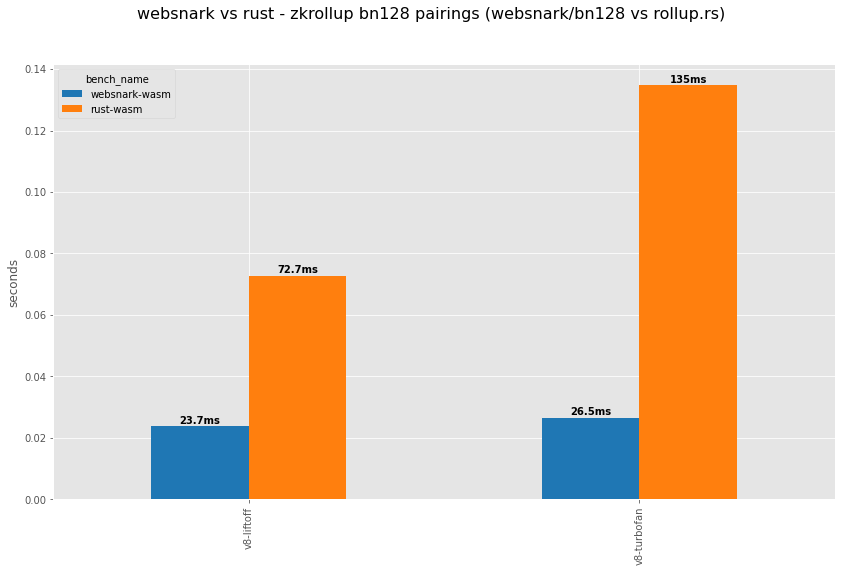

In [48]:
fig_plt = plotOneTestGrouped(df_scout_rust_vs_websnark,
                   title="websnark vs rust - zkrollup bn128 pairings (websnark/bn128 vs rollup.rs)",
                   test_title="",
                   group_order=['websnark-wasm', 'rust-wasm'],
                   sort_by="rust-wasm",
                   colors=['tab:blue', 'tab:orange'])

In [49]:
fig_plt.savefig('../images/websnark-vs-rust-wasm-zkrollup-bn128-pairings.png', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

In [50]:
df_rolluprs_native = df_scout_data[df_scout_data['bench_name'] == 'ecpairing-zkrollup-rust-native-bn128-two-pairings']
df_rolluprs_native = df_rolluprs_native.fillna(0)

df_rolluprs_native.replace('ecpairing-zkrollup-rust-native-bn128-two-pairings', 'rust-native', inplace=True)


df_scout_rust_vs_websnark_fast_vs_native = df_scout_rust_vs_websnark.append(df_rolluprs_native, sort=False)

<Figure size 432x288 with 0 Axes>

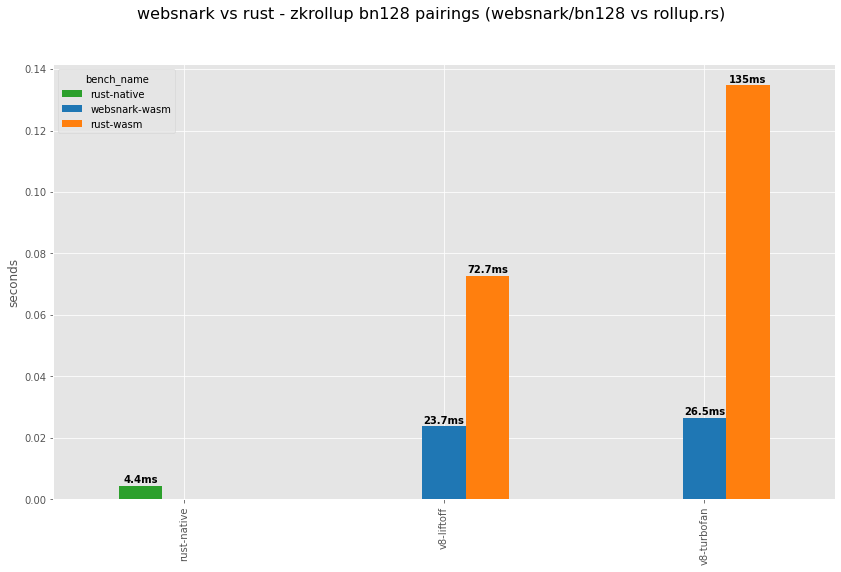

In [51]:

fig_plt = plotOneTestGrouped(df_scout_rust_vs_websnark_fast_vs_native,
               title="websnark vs rust - zkrollup bn128 pairings (websnark/bn128 vs rollup.rs)",
               test_title="",
               sort_by=["rust-native", "rust-wasm", "websnark-wasm"],
               colors=['tab:green', 'tab:blue', 'tab:orange'],
               group_order=["rust-native", "websnark-wasm", "rust-wasm"])

fig_plt.savefig('../images/websnark-vs-rust-wasm-native-zkrollup-bn128-pairings', bbox_inches='tight')

### TODO: adjust bar size and placement?

## Just websnark against native

In [52]:
# print out the engine names

df_websnark_vs_native = df_scout_data[df_scout_data['bench_name'] == 'ecpairing-zkrollup-websnark-bn128-two-pairings'].copy()
df_websnark_vs_native.replace('ecpairing-zkrollup-websnark-bn128-two-pairings', 'websnark-bn128-two-pairings', inplace=True)

df_websnark_vs_native['engine'].unique().tolist()

['wabt-no-bignums',
 'wabt-bignums-slowhost-slowmont',
 'wabt-bignums-slowhost-slowmont-superops',
 'wabt-bignums-fasthost-slowmont-superops',
 'wabt-bignums-fasthost-fastmont-superops',
 'wabt-bignums-fasthost-fastmont',
 'v8-turbofan',
 'v8-liftoff',
 'v8-liftoff-and-turbofan',
 'v8-interpreter',
 'v8-turbofan-with-bignums',
 'v8-liftoff-with-bignums',
 'v8-interpreter-with-bignums']

In [53]:
df_websnark_vs_native = df_scout_data[df_scout_data['bench_name'] == 'ecpairing-zkrollup-websnark-bn128-two-pairings'].copy()
df_websnark_vs_native.replace('ecpairing-zkrollup-websnark-bn128-two-pairings', 'websnark-bn128-two-pairings', inplace=True)

df_websnark_vs_native = df_websnark_vs_native[df_websnark_vs_native['engine'].isin(
['wabt-bignums-fasthost', 'wabt-bignums-slowhost', 'wabt-superops-bignums', 'wabt-superops-bignums-slowmont', 'wabt-with-bignums-and-superops', 'wabt-with-bignums', 'rust-native', 'v8-liftoff', 'v8-turbofan']  
)]

df_websnark_vs_native = df_websnark_vs_native.append(df_rolluprs_native)

df_websnark_vs_native_means = df_websnark_vs_native.groupby(['engine']).mean()


In [54]:
#df_websnark_vs_native_means

<Figure size 432x288 with 0 Axes>

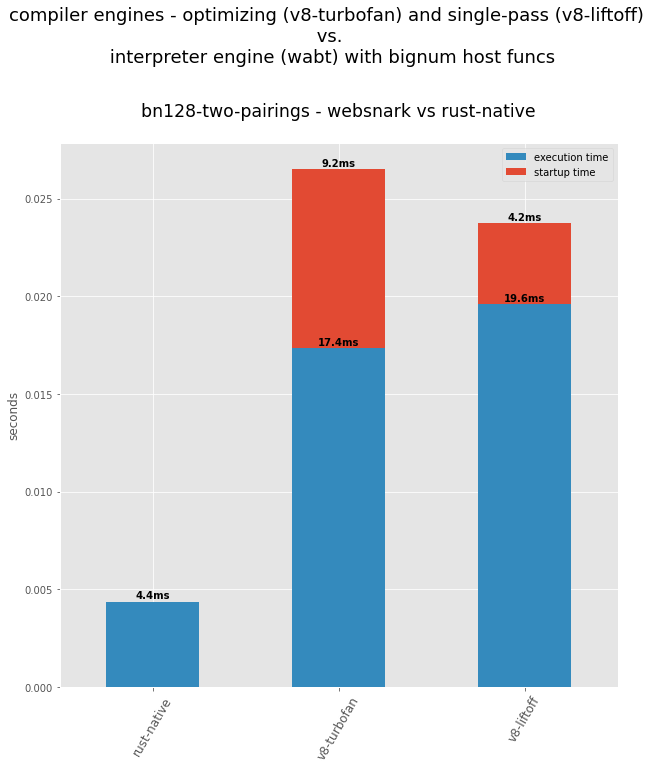

In [55]:
fig_plt = plotScoutStackedTest(df_websnark_vs_native_means,
            suptitle="compiler engines - optimizing (v8-turbofan) and single-pass (v8-liftoff) \n vs. \n interpreter engine (wabt) with bignum host funcs",
            suptitle_pos=1.07,
            subtitle="bn128-two-pairings - websnark vs rust-native\n",
            subtitle_size='xx-large')

fig_plt.savefig('../images/websnark-vs-native-bn128-two-pairings-v8.png', bbox_inches='tight')

# Try Seaborn with error bars

In [56]:
import seaborn as sns

In [57]:
df_websnark_vs_native['time'] = df_websnark_vs_native['exec_time'] + df_websnark_vs_native['parse_time']


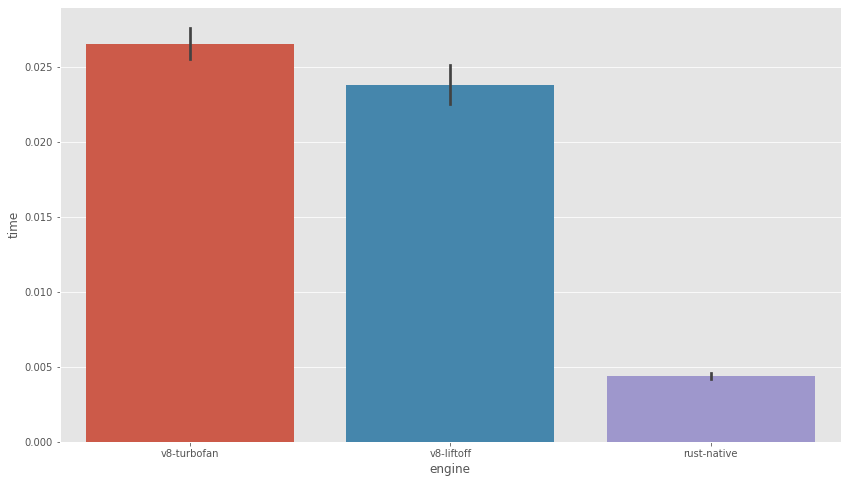

In [58]:
f = plt.figure(figsize=(14,8))

ax = sns.barplot(x='engine', y='time', data=df_websnark_vs_native)

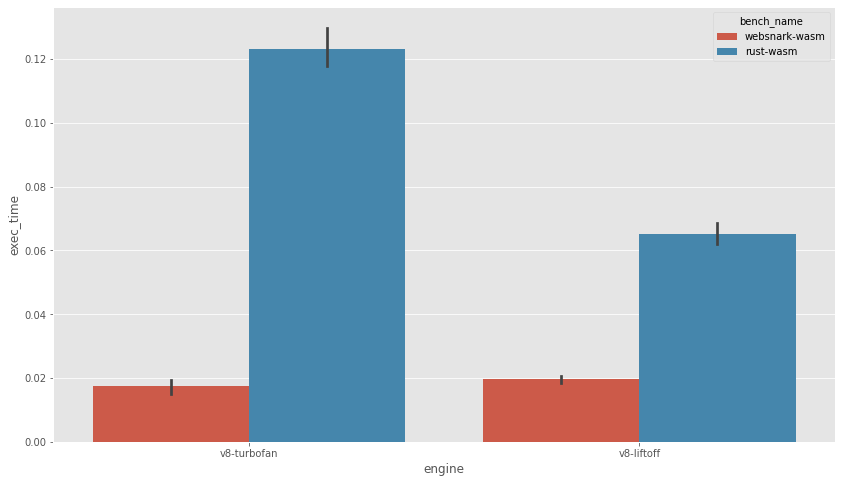

In [59]:
f = plt.figure(figsize=(14,8))

ax = sns.barplot(x='engine', y='exec_time', hue='bench_name', data=df_scout_rust_vs_websnark)

## Plot bignum benchmark: daiquiri-zkmixer-websnark-bn128-groth16-four-pairings-and-mimc

In [60]:
df_scout_daiquiri_zkmixer = df_scout_data[df_scout_data['bench_name'] == 'daiquiri-zkmixer-websnark-bn128-groth16-four-pairings-and-mimc']

df_scout_means_daiquiri_zkmixer = df_scout_daiquiri_zkmixer.groupby(['engine']).mean()
df_scout_fast_daiquiri_zkmixer = filterDfEngines(df_scout_daiquiri_zkmixer,
    ['v8-interpreter', 'scoutcpp-wabt-no-bignums', 'wabt-no-bignums'])
df_scout_fast_means_daiquiri_zkmixer = df_scout_fast_daiquiri_zkmixer.groupby(['engine']).mean()


<Figure size 432x288 with 0 Axes>

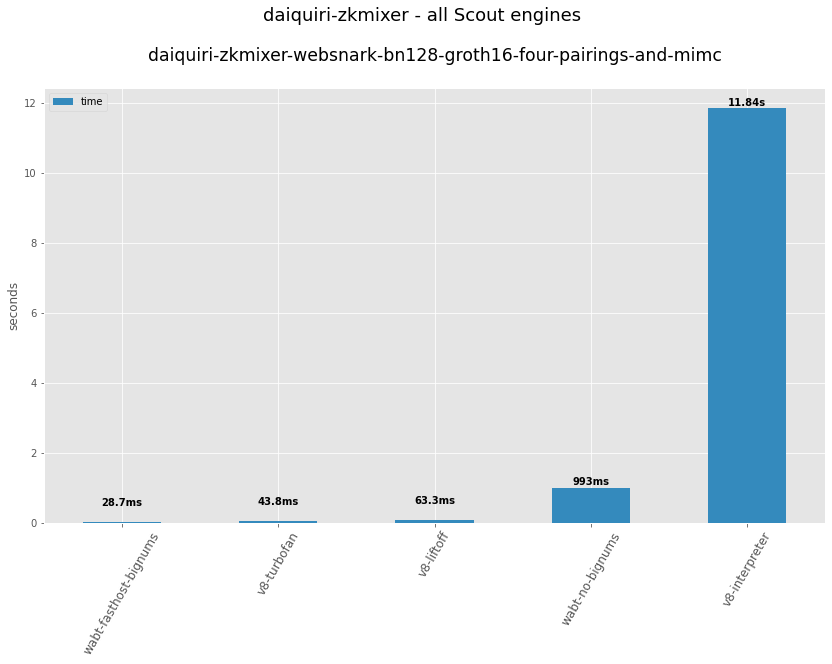

In [61]:
plotOneTest(df_scout_means_daiquiri_zkmixer,
            suptitle="daiquiri-zkmixer - all Scout engines",
            suptitle_pos=1.02,
            subtitle="daiquiri-zkmixer-websnark-bn128-groth16-four-pairings-and-mimc\n",
            subtitle_size='xx-large')

fig_plt.savefig('../images/scout-daiquiri-all-engines.png', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

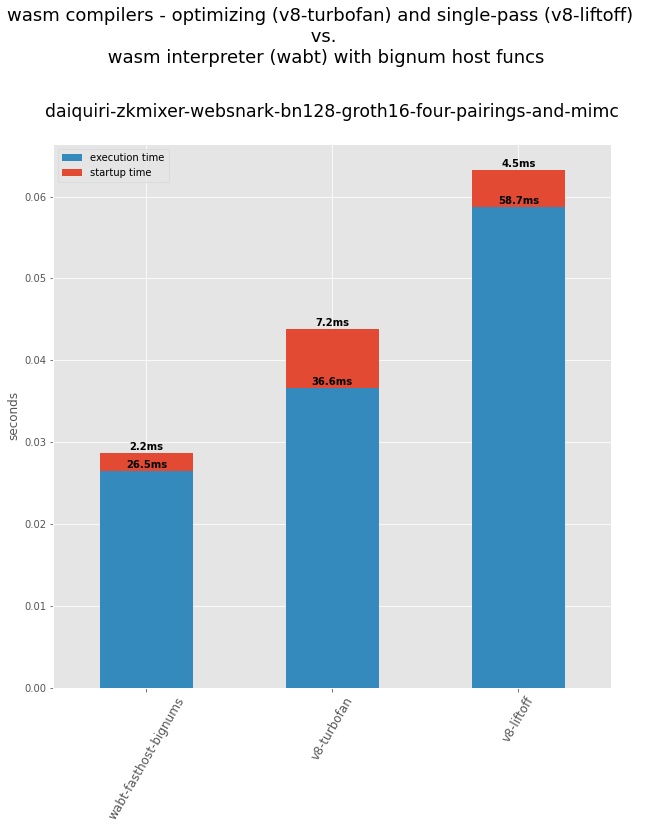

In [62]:
fig_plt = plotScoutStackedTest(df_scout_fast_means_daiquiri_zkmixer,
            suptitle="wasm compilers - optimizing (v8-turbofan) and single-pass (v8-liftoff) \n vs. \n wasm interpreter (wabt) with bignum host funcs",
            suptitle_pos=1.07,
            subtitle="daiquiri-zkmixer-websnark-bn128-groth16-four-pairings-and-mimc\n",
            subtitle_size='xx-large')

fig_plt.savefig('../images/scout-daiquiri-v8-vs-wabt.png', bbox_inches='tight')

## Import geth precompile results

In [63]:
df_geth_precompiles = read_results(join(CSV_RESULT_DIR, GETH_PRECOMPILE_RESULT_FILE))

In [64]:
#df_geth_precompiles

In [65]:
def splitName(test_name):
    ix = test_name.find("/")
    return (test_name[0:ix], test_name[ix+1:])


In [66]:
df_geth_precompiles['precompile_name'], df_geth_precompiles['input_name'] = zip(*df_geth_precompiles.apply(lambda row: splitName(row['test_name']), axis=1))


In [67]:
df_geth_precompiles = df_geth_precompiles[['precompile_name', 'input_name', 'gas', 'time']]

In [68]:
df_geth_native_bn128pairing = df_geth_precompiles[df_geth_precompiles["input_name"] == "two_point_match_rollup_input"].copy()


In [69]:
df_geth_native_bn128pairing

precompile_name                    input_name     gas      time
57  PrecompiledBn256Pairing  two_point_match_rollup_input  113000  0.003993

## Import standalone wasm results

In [70]:
df_wasm = read_results(join(CSV_RESULT_DIR, STANDALONE_WASM_RESULT_FILE))

In [71]:
df_wasm

engine            test_name  elapsed_time  compile_time  exec_time
0        wabt  guido-fuzzer-find-2      0.005597      0.001723   0.000537
1        wabt  guido-fuzzer-find-2      0.004742      0.001499   0.000551
2        wabt  guido-fuzzer-find-2      0.004475      0.001485   0.000470
3        wabt  guido-fuzzer-find-2      0.004814      0.001639   0.000537
4        wabt  guido-fuzzer-find-2      0.004264      0.001420   0.000433
...       ...                  ...           ...           ...        ...
19996  eos-vm   bn128_mul-cdetrio7      0.072624      0.000536   0.068666
19997  eos-vm   bn128_mul-cdetrio7      0.072460      0.000546   0.068768
19998  eos-vm   bn128_mul-cdetrio7      0.073741      0.000533   0.069656
19999  eos-vm   bn128_mul-cdetrio7      0.073263      0.000540   0.069355
20000  eos-vm   bn128_mul-cdetrio7      0.072965      0.000594   0.069327

[20001 rows x 5 columns]

## Import native results

In [72]:
df_native_raw = read_results(join(CSV_RESULT_DIR, NATIVE_RESULT_FILE))

In [73]:
native_results = {}
for i in range(len(df_native_raw)):
    test_name = df_native_raw['test_name'][i]
    native_results[test_name] = df_native_raw['elapsed_times'][i].split(', ')

    
test_names = df_native_raw['test_name'].tolist()

native_times = {}
for test in test_names:
    avg = np.mean([float(t) for t in native_results[test]])
    native_times[test] = avg

    
df_native = pd.DataFrame.from_dict(native_times, orient='index', columns=['elapsed_time'])
df_native['engine'] = 'rust-native'

In [74]:
df_native

elapsed_time       engine
blake2b-8415-bytes                           0.000026  rust-native
blake2b-5610-bytes                           0.000012  rust-native
blake2b-2805-bytes                           0.000008  rust-native
bls12-381-aggreg-128-pubkeys-verify-sig      0.027138  rust-native
bls12-381-aggreg-64-pubkeys-verify-sig       0.028107  rust-native
bls12-381-aggreg-32-pubkeys-verify-sig       0.024123  rust-native
bn128_pairing-ten_point_match_1              0.021701  rust-native
bn128_pairing-one_point                      0.006033  rust-native
bn128_pairing-two_point_match_2              0.010407  rust-native
sha1-10808-bits                              0.000007  rust-native
sha1-21896-bits                              0.000009  rust-native
sha1-42488-bits                              0.000015  rust-native
bn128_add-cdetrio11                          0.000016  rust-native
bn128_add-cdetrio14                          0.000005  rust-native
bn128_add-cdetrio10                          0.000002  rust-native
ed25519-verify-ten-inputs                    0.001019  rust-native
modexp-nagydani-1-qube                       0.000023  rust-native
modexp-nagydani-1-square                     0.000020  rust-native
modexp-eip_example1                          0.000234  rust-native
bn128_mul-cdetrio11                          0.000396  rust-native
bn128_mul-chfast2                            0.000202  rust-native
bn128_mul-chfast1                            0.000256  rust-native
bn128_mul-chfast3                            0.000630  rust-native
bn128_mul-cdetrio2                           0.000402  rust-native
bn128_mul-cdetrio6                           0.000487  rust-native
bn128_mul-cdetrio7                           0.000319  rust-native
bn128_mul-cdetrio12                          0.000368  rust-native

### sorted lists of test names for plotting inputs in order

In [75]:
blake2b_test_names = [name for name in df_wasm['test_name'].unique().tolist() if 'blake2b' in name]
blake2b_test_names.sort()
blake2b_test_names_desc = blake2b_test_names.copy()
blake2b_test_names_desc.reverse()


In [76]:
sha1_test_names = [name for name in df_wasm['test_name'].unique().tolist() if 'sha1' in name]
sha1_test_names.sort()
sha1_test_names_desc = sha1_test_names.copy()
sha1_test_names_desc.reverse()


In [77]:

bn128_mul_test_names = ['bn128_mul-cdetrio11', 'bn128_mul-chfast2', 'bn128_mul-chfast1']
bn128_add_test_names = ['bn128_add-cdetrio11', 'bn128_add-cdetrio14', 'bn128_add-cdetrio10']
bn128_pairing_test_names = ['bn128_pairing-ten_point_match_1', 'bn128_pairing-two_point_match_2', 'bn128_pairing-one_point']

bn128_mul_test_names.reverse()
bn128_add_test_names.reverse()
bn128_pairing_test_names.reverse()

bn128_mul_test_names_desc = ['bn128_mul-cdetrio11', 'bn128_mul-chfast2', 'bn128_mul-chfast1']
bn128_add_test_names_desc = ['bn128_add-cdetrio11', 'bn128_add-cdetrio14', 'bn128_add-cdetrio10']
bn128_pairing_test_names_desc = ['bn128_pairing-ten_point_match_1', 'bn128_pairing-two_point_match_2', 'bn128_pairing-one_point']



In [78]:
bls12_test_names = ['bls12-381-aggreg-32-pubkeys-verify-sig', 'bls12-381-aggreg-64-pubkeys-verify-sig', 'bls12-381-aggreg-128-pubkeys-verify-sig']
bls12_test_names_desc = bls12_test_names.copy()
bls12_test_names_desc.reverse()

In [79]:
modexp_test_names = [name for name in df_wasm['test_name'].unique().tolist() if 'modexp' in name]
modexp_test_names.sort()
modexp_test_names_desc = modexp_test_names.copy()
modexp_test_names_desc.reverse()

In [80]:
all_tests = sha1_test_names + blake2b_test_names + modexp_test_names + ['ed25519-verify-ten-inputs'] + bls12_test_names \
    + bn128_add_test_names + bn128_mul_test_names + bn128_pairing_test_names

### Prepare interpreter dataframe

In [81]:
all_interp_test_names = []

interp_results_for_df = []
for engine in INTERPRETER_ENGINES:
    df_engine = df_wasm[df_wasm['engine'] == engine]
    df_means = df_engine.groupby(['test_name']).mean()
    test_names = df_engine['test_name'].unique().tolist()
    all_interp_test_names.extend(test_names)
    for test_name in test_names:
        interp_results_for_df.append([engine, test_name] + df_means.loc[test_name].tolist())

        
all_interp_test_names = set(all_interp_test_names)

#interp_results_for_df

df_interp = pd.DataFrame(interp_results_for_df)
df_interp.columns = ['engine', 'test_name', 'elapsed_time', 'parse_time', 'exec_time']
df_interp.set_index('engine', inplace=True)
df_interp['total_time'] = df_interp['parse_time'] + df_interp['exec_time']
#df_interp

In [82]:
df_wasm['test_name'].unique().tolist()

['guido-fuzzer-find-2',
 'modexp-nagydani-1-qube',
 'sha1-21896-bits',
 'bn128_pairing-ten_point_match_1',
 'blake2b-5610-bytes',
 'bn128_mul-cdetrio2',
 'modexp-eip_example1',
 'blake2b-2805-bytes',
 'sha1-10808-bits',
 'bn128_add-cdetrio10',
 'mul256-gcolvin-drag-race',
 'bn128_mul-chfast1',
 'guido-fuzzer-find-2-norotates',
 'bls12-381-aggreg-128-pubkeys-verify-sig',
 'bn128_mul-cdetrio6',
 'bn128_mul-chfast3',
 'modexp-nagydani-1-square',
 'bls12-381-aggreg-32-pubkeys-verify-sig',
 'blake2b-8415-bytes',
 'bn128_add-cdetrio11',
 'bn128_mul-cdetrio11',
 'bn128_pairing-one_point',
 'ed25519-verify-ten-inputs',
 'bn128_mul-chfast2',
 'bn128_add-cdetrio14',
 'bn128_pairing-two_point_match_2',
 'bls12-381-aggreg-64-pubkeys-verify-sig',
 'sha1-42488-bits',
 'ecpairing',
 'bn128_mul-cdetrio12',
 'guido-fuzzer-find-1',
 'bn128_mul-cdetrio7']

## Interpreter engines compared

In [83]:
def plotInterpThreeTests(df_testdata, three_names, title="Title", filter_engines=None):
    if filter_engines is not None:
        df_testdata = filterDfEngines(df_testdata.reset_index(), filter_engines)
        df_testdata.set_index('engine', inplace=True)
    df_1 = df_testdata[df_testdata['test_name'] == three_names[0]]
    df_2 = df_testdata[df_testdata['test_name'] == three_names[1]]
    df_3 = df_testdata[df_testdata['test_name'] == three_names[2]]
    plt.figure()
    f, (ax1) = plt.subplots(1, 3, sharey=True, figsize=(16,7))
    df_1.sort_values('total_time')[['parse_time', 'exec_time']].plot.bar(ax=ax1[0], stacked=True)
    ax1[0].set_title(three_names[0])
    ax1[0].set(xlabel='')
    df_2.sort_values('total_time')[['parse_time', 'exec_time']].plot.bar(ax=ax1[1], stacked=True)
    ax1[1].set_title(three_names[1])
    ax1[1].set(xlabel='')
    df_3.sort_values('total_time')[['parse_time', 'exec_time']].plot.bar(ax=ax1[2], stacked=True)
    ax1[2].set_title(three_names[2])
    ax1[2].set(xlabel='')
    adjust_text_labels(labelBarHeights(ax1[0]), ax=ax1[0])
    adjust_text_labels(labelBarHeights(ax1[1]), ax=ax1[1])
    adjust_text_labels(labelBarHeights(ax1[2]), ax=ax1[2])
    ax1[0].legend(labels=["startup time", "execution time"])
    ax1[1].legend(labels=["startup time", "execution time"])
    ax1[2].legend(labels=["startup time", "execution time"])

    ax1[1].tick_params(axis='y', left=True, labelleft=True)
    ax1[2].tick_params(axis='y', left=True, labelleft=True)
    
    scale_y = 1e-3
    ticks_y = ticker.FuncFormatter(lambda y, pos: '{0:g}'.format(y/scale_y))
    ax1[1].yaxis.set_major_formatter(ticks_y)
    
    ax1[0].set(ylabel='milliseconds')
    
    f.suptitle(title, fontsize=16, y=0.98)
    return plt

<Figure size 432x288 with 0 Axes>

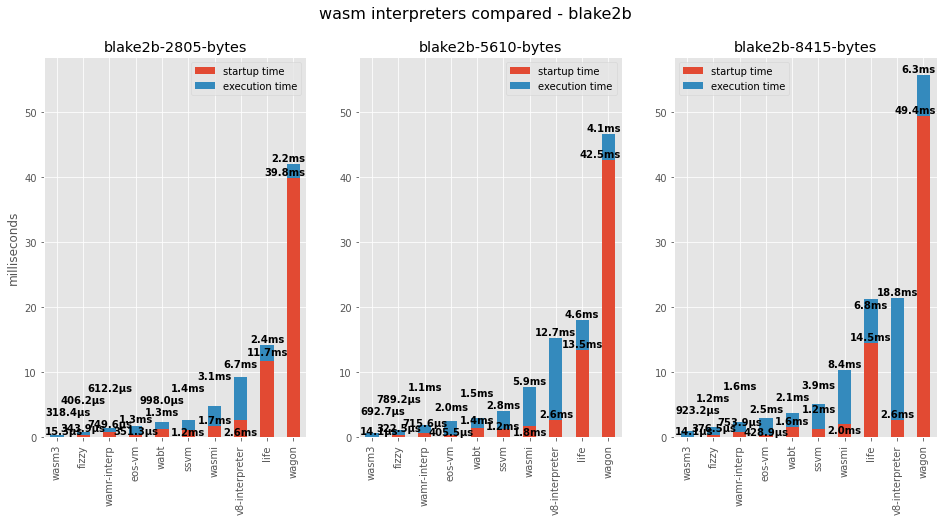

In [84]:
plt_fig = plotInterpThreeTests(df_interp, blake2b_test_names, title="wasm interpreters compared - blake2b")
plt_fig.savefig('../images/wasm-interp-blake2b.png', bbox_inches='tight')

### Interpreters - Execution time

In [85]:
def plotThreeTestsExecTime(df_testdata, three_names, title="Title", filter_engines=None):
    if filter_engines is not None:
        df_testdata = filterDfEngines(df_testdata.reset_index(), filter_engines)
        df_testdata.set_index('engine', inplace=True)
    df_1 = df_testdata[df_testdata['test_name'] == three_names[0]]
    df_2 = df_testdata[df_testdata['test_name'] == three_names[1]]
    df_3 = df_testdata[df_testdata['test_name'] == three_names[2]]
    plt.figure()
    f, (ax1) = plt.subplots(1, 3, sharey=True, figsize=(16,7))
    df_1.sort_values('exec_time')[['exec_time']].plot.bar(ax=ax1[0], color=COLORS_DEFAULT['blue'])
    ax1[0].set_title(three_names[0])
    ax1[0].set(xlabel='')
    df_2.sort_values('exec_time')[['exec_time']].plot.bar(ax=ax1[1], color=COLORS_DEFAULT['blue'])
    ax1[1].set_title(three_names[1])
    ax1[1].set(xlabel='')
    df_3.sort_values('exec_time')[['exec_time']].plot.bar(ax=ax1[2], color=COLORS_DEFAULT['blue'])
    ax1[2].set_title(three_names[2])
    ax1[2].set(xlabel='')
    adjust_text_labels(labelBarHeights(ax1[0]), ax=ax1[0])
    adjust_text_labels(labelBarHeights(ax1[1]), ax=ax1[1])
    adjust_text_labels(labelBarHeights(ax1[2]), ax=ax1[2])
    ax1[0].legend(labels=["execution time"])
    ax1[1].legend(labels=["execution time"])
    ax1[2].legend(labels=["execution time"])

    ax1[1].tick_params(axis='y', left=True, labelleft=True)
    ax1[2].tick_params(axis='y', left=True, labelleft=True)
   
    scale_y = 1e-3
    ticks_y = ticker.FuncFormatter(lambda y, pos: '{0:g}'.format(y/scale_y))
    ax1[1].yaxis.set_major_formatter(ticks_y)
    
    ax1[0].set(ylabel='milliseconds')
    
    f.suptitle(title, fontsize=16, y=0.98)
    return f


<Figure size 432x288 with 0 Axes>

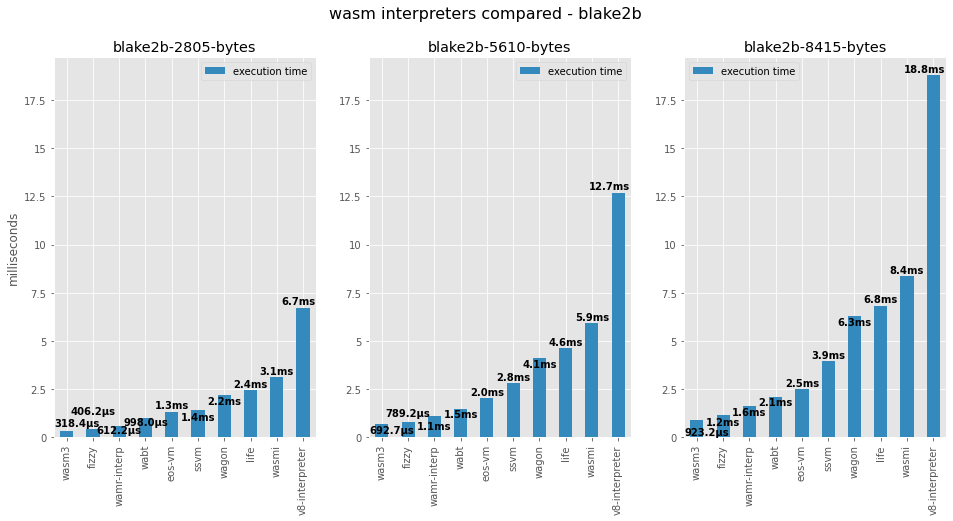

In [86]:
plt_fig = plotThreeTestsExecTime(df_interp, blake2b_test_names, title="wasm interpreters compared - blake2b")
plt_fig.savefig('../images/wasm-interp-blake2b-exec.png', bbox_inches='tight')

## Chart of only the fast interpreters

<Figure size 432x288 with 0 Axes>

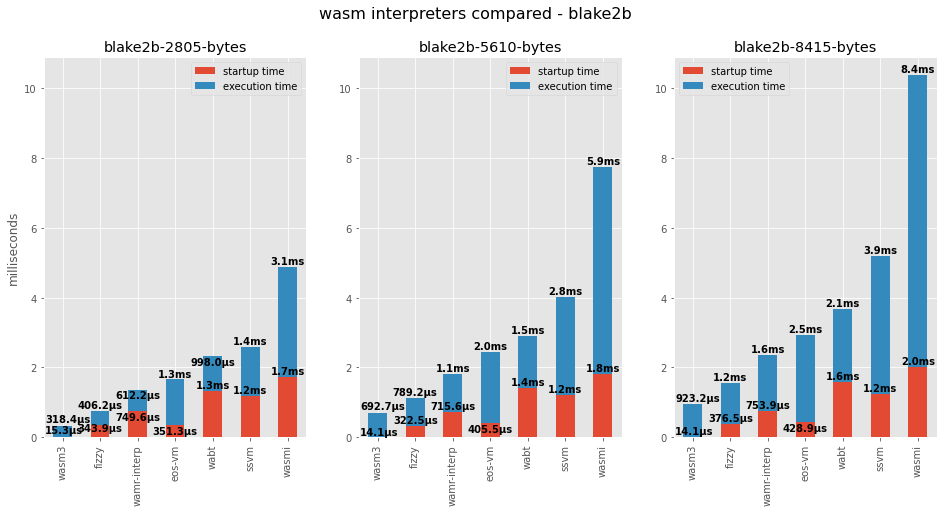

In [87]:
plt_fig = plotInterpThreeTests(df_interp,
                     blake2b_test_names,
                     title="wasm interpreters compared - blake2b",
                     filter_engines=["life", "wagon", "v8-interpreter"])
plt_fig.savefig('../images/wasm-interp-blake2b-fast.png', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

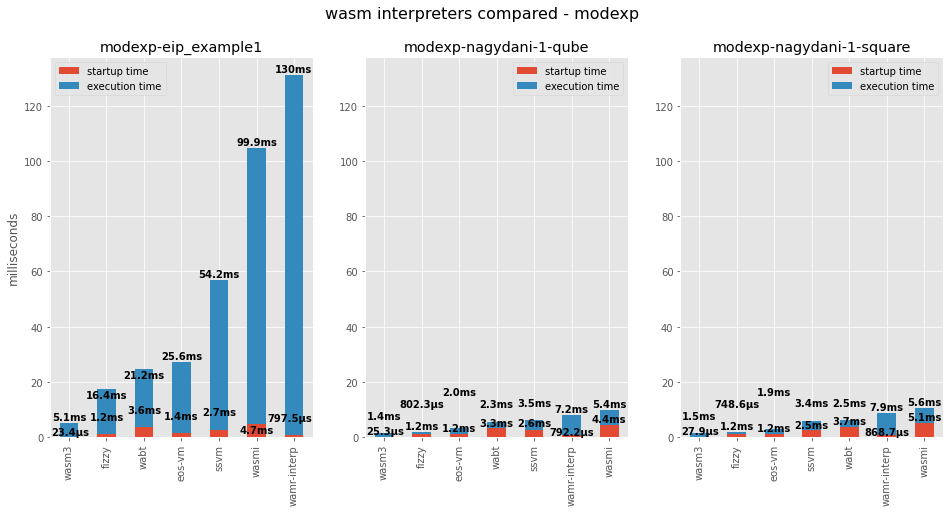

In [88]:
plt_fig = plotInterpThreeTests(df_interp,
                     modexp_test_names,
                     title="wasm interpreters compared - modexp",
                     filter_engines=["life", "wagon", "v8-interpreter"])
plt_fig.savefig('../images/wasm-interp-modexp.png', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

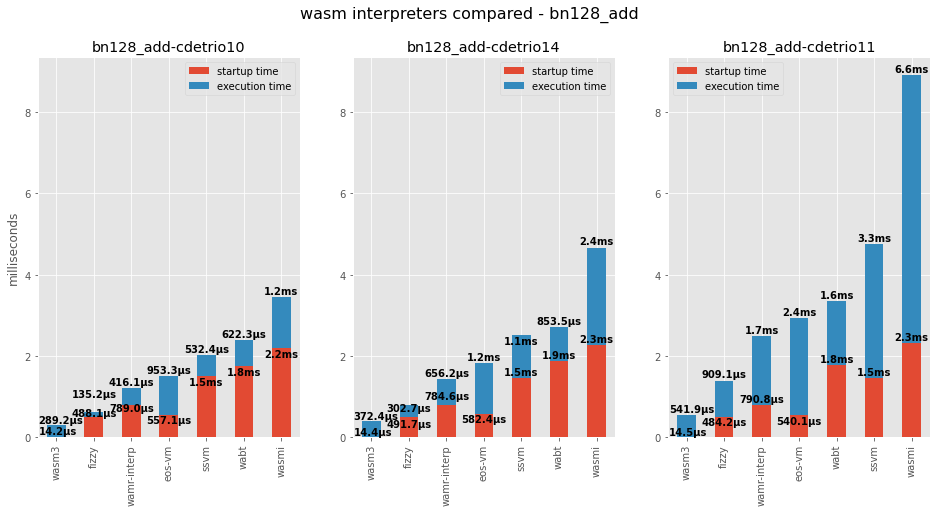

In [89]:
plt_fig = plotInterpThreeTests(df_interp,
                     bn128_add_test_names,
                     title="wasm interpreters compared - bn128_add",
                     filter_engines=["life", "wagon", "v8-interpreter"])
plt_fig.savefig('../images/wasm-interp-bn128-add.png', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

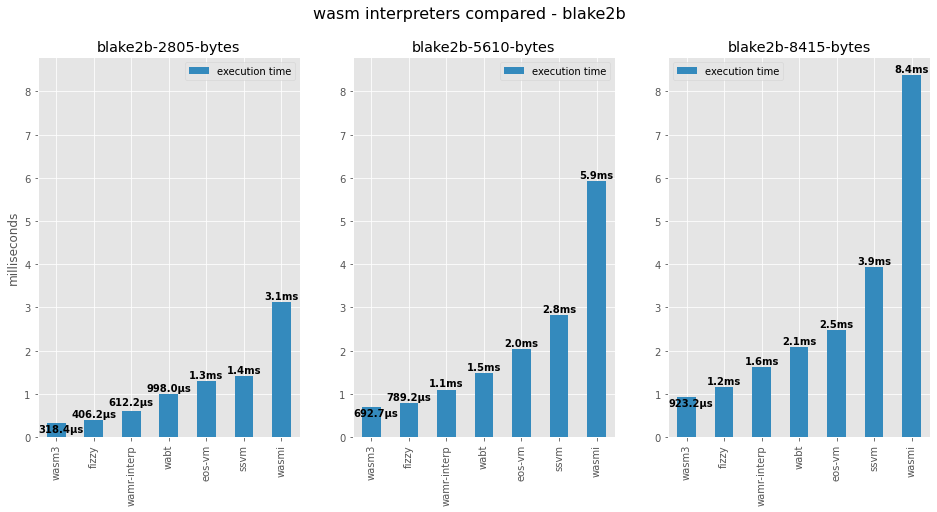

In [90]:
plt_fig = plotThreeTestsExecTime(df_interp,
                       blake2b_test_names,
                       title="wasm interpreters compared - blake2b",
                       filter_engines=["life", "wagon", "v8-interpreter"])
plt_fig.savefig('../images/wasm-interp-blake2b-life-wagon-v8.png', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

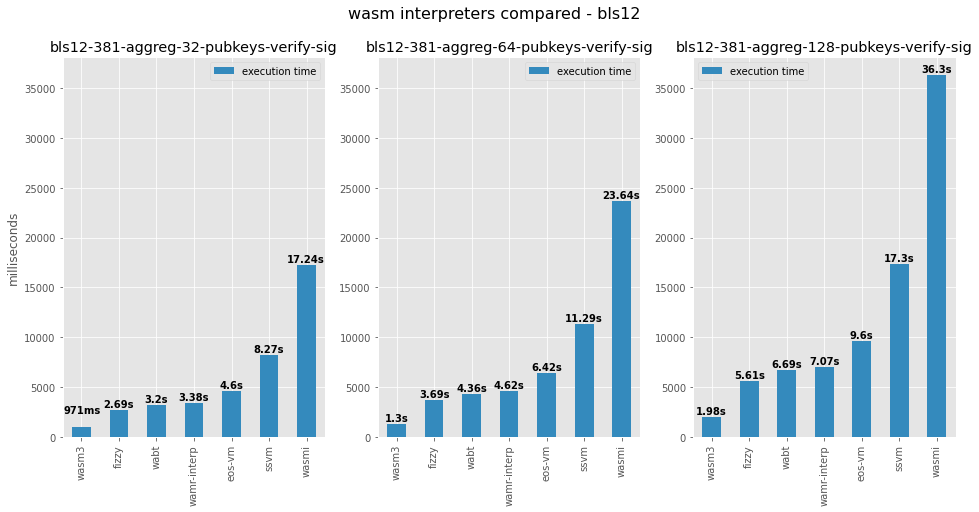

In [91]:
plt_fig = plotThreeTestsExecTime(df_interp,
                       bls12_test_names,
                       title="wasm interpreters compared - bls12",
                       filter_engines=["life", "wagon", "v8-interpreter"])
plt_fig.savefig('../images/wasm-interp-bls12.png', bbox_inches='tight')

## Compiler Results

In [92]:
compiler_results_for_df = []
for engine in COMPILER_ENGINES:
    df_engine = df_wasm[df_wasm['engine'] == engine]
    df_means = df_engine.groupby(['test_name']).mean()
    test_names = df_engine['test_name'].unique().tolist()
    for test_name in test_names:
        compiler_results_for_df.append([engine, test_name] + df_means.loc[test_name].tolist())




In [93]:
df_compiler = pd.DataFrame(compiler_results_for_df)

df_compiler.columns = ['engine', 'test_name', 'elapsed_time', 'compile_time', 'exec_time']
df_compiler.set_index('engine', inplace=True)
df_compiler['total_time'] = df_compiler['compile_time'] + df_compiler['exec_time']

#df_compiler

## JIT bomb chart - guido-fuzzer-find-1

In [94]:
#df_compiler

In [95]:
def plotJitBomb(df_jit, title="jit bomb chart", log_scale=False):
    f = plt.figure(figsize=(14,8))

    bombplot = sns.barplot(x='engine', y='value', hue='exec_or_compile', dodge=True, data=df_jit)
    if log_scale:
        bombplot.set(yscale="log")

    # annotating bars: https://github.com/mwaskom/seaborn/issues/1582
    for p in bombplot.patches:
        bombplot.annotate(
                   #format(p.get_height(), '.4f'),
                   toMs(p.get_height()),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 10),
                   textcoords = 'offset points')

    f.suptitle(title, fontsize=18, y=0.95)
    return f

In [96]:
df_jitbomb_1 = df_compiler[df_compiler['test_name'] == 'guido-fuzzer-find-1'].copy()

In [97]:
df_jitbomb_1.drop(['elapsed_time'], axis=1, inplace=True)
df_jitbomb_1.drop(['total_time'], axis=1, inplace=True)
df_jitbomb_1.reset_index(inplace=True)

In [98]:
df_jitbomb_1 = df_jitbomb_1.melt(id_vars=["engine", "test_name"], var_name="exec_or_compile")

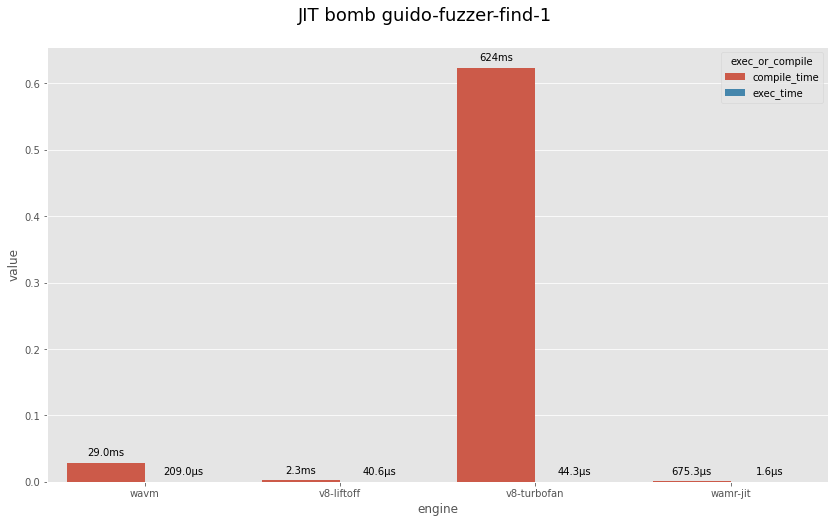

In [99]:
fig_plt = plotJitBomb(df_jitbomb_1, "JIT bomb guido-fuzzer-find-1")
fig_plt.savefig('../images/standalone-jitbomb-guido-fuzzer-find-1.png', bbox_inches='tight')

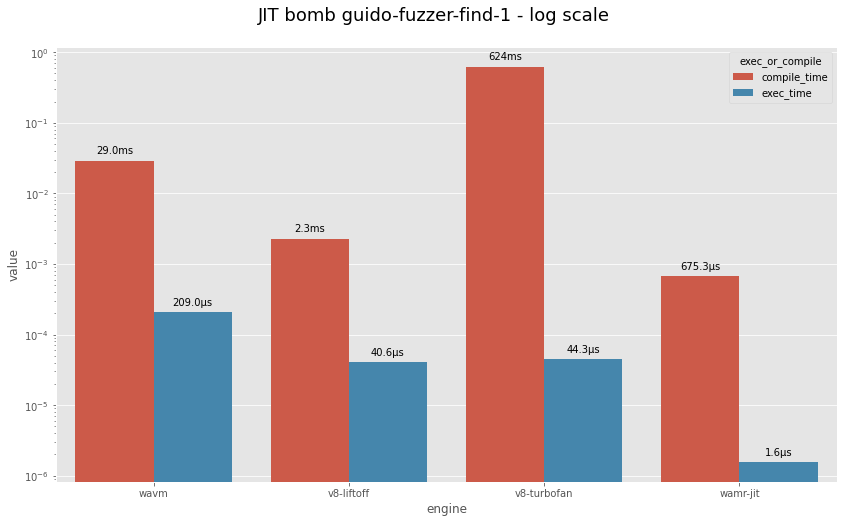

In [100]:
fig_plt = plotJitBomb(df_jitbomb_1, "JIT bomb guido-fuzzer-find-1 - log scale", log_scale=True)
fig_plt.savefig('../images/standalone-jitbomb-guido-fuzzer-find-1-log-scale.png', bbox_inches='tight')

### guido-fuzzer-find-2

In [101]:
df_jitbomb_2 = df_compiler[df_compiler['test_name'] == 'guido-fuzzer-find-2'].copy()

df_jitbomb_2.drop(['elapsed_time'],axis=1,inplace=True)
df_jitbomb_2.drop(['total_time'],axis=1,inplace=True)
df_jitbomb_2.reset_index(inplace=True)

df_jitbomb_2 = df_jitbomb_2.melt(id_vars=["engine", "test_name"], var_name="exec_or_compile")

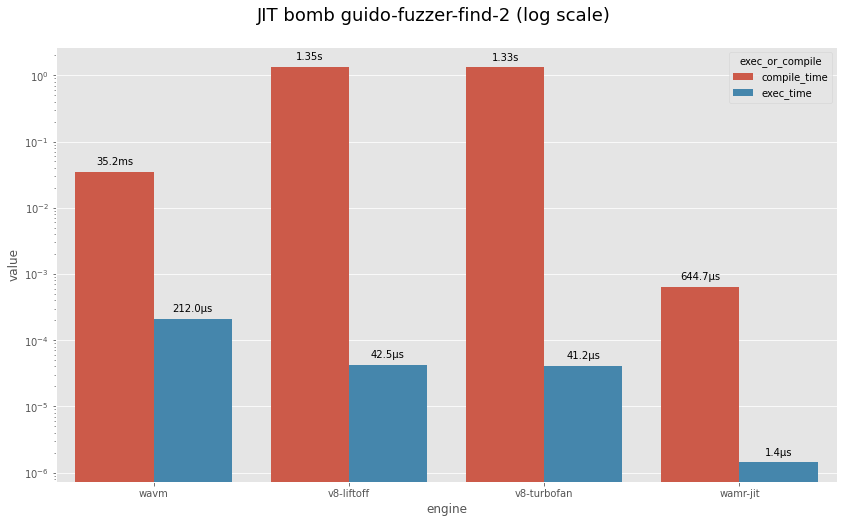

In [102]:
fig_plt = plotJitBomb(df_jitbomb_2, "JIT bomb guido-fuzzer-find-2 (log scale)", log_scale=True)

fig_plt.savefig('../images/standalone-jitbomb-guido-fuzzer-find-2-log-scale.png', bbox_inches='tight')

# TODO: mention v8-liftoff version here
# TODO: try a later v8-liftoff version?

## Compiler function

*Note: Fix scale for v8-turbofan execution time*

In [103]:
def plotCompilerStackedOneTest(df_benchdata, test_name):
    plt.figure()
    df_1 = df_benchdata[df_benchdata['test_name'] == test_name]
    # for some reason, exec_time needs to come first for the stacked chart to display correctly
    ax = df_1[['exec_time', 'compile_time']].sort_values('exec_time').plot.bar(stacked=True, color=[COLORS_DEFAULT['blue'], COLORS_DEFAULT['red']], figsize=(10,10))
    ax.set_title("Compilers - {}".format(test_name))
    df_total_times = df_1[['exec_time', 'compile_time']].copy()
    df_total_times['total_time'] = df_total_times['exec_time'] + df_total_times['compile_time']
    ymax = max(df_total_times[['total_time']].max()) * 1.3 # 30% larger for padding between top of bars and top of graph
    ymin = min([x for x in df_1[['exec_time', 'compile_time']].min().tolist() if x > 0])
    ymin = ymin * 0.8 # 0.8 to get a number 20% smaller, fix to make bar appear for smallest exec time
    ax.set_ylim(ymin, ymax)
    ax.set_yscale("log")
    plt.ylabel("seconds (log scale)")
    adjust_text_labels(labelBarHeights(ax, lower_y_bound=False))
    ax.legend(labels=["execution time", "compile time"])
    return plt


<Figure size 432x288 with 0 Axes>

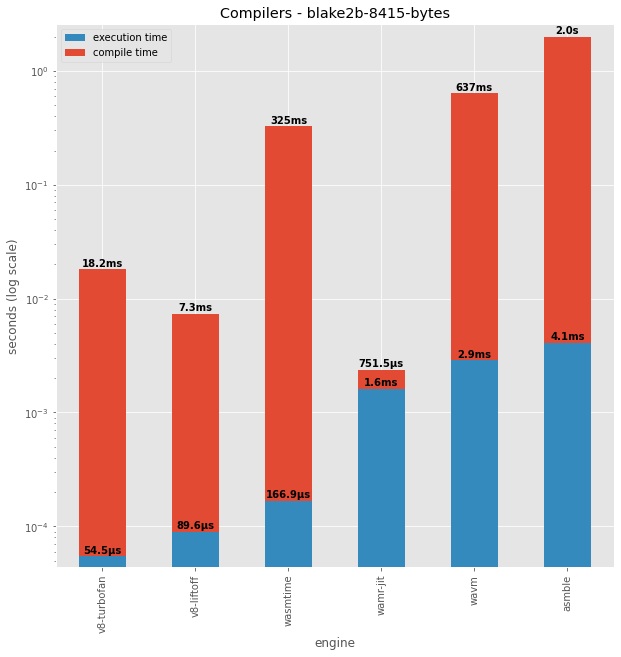

In [104]:
fig_plt = plotCompilerStackedOneTest(df_compiler, "blake2b-8415-bytes")
fig_plt.savefig('../images/standalone-blake2b-8415-bytes-compilers.png',  bbox_inches='tight')

## Add rust-native to compiler engines chart

In [105]:
# merge df_native and df_compiler into one dataframe
# both dataframes must have same columns to merge them:
# engine, test_name, elapsed_time, compile_time, exec_time, total_time

df_native_merge = df_native.copy()
df_native_merge.reset_index(inplace=True)
df_native_merge.columns = ['test_name', 'elapsed_time', 'engine']
df_native_merge['compile_time'] = 0
df_native_merge['exec_time'] = df_native_merge['elapsed_time']
df_native_merge['total_time'] = df_native_merge['elapsed_time']
df_native_and_compile = pd.concat([df_compiler.reset_index(), df_native_merge], sort=False)
df_native_and_compile.reset_index(drop=True, inplace=True)
df_native_and_compile.set_index('engine', inplace=True)


<Figure size 432x288 with 0 Axes>

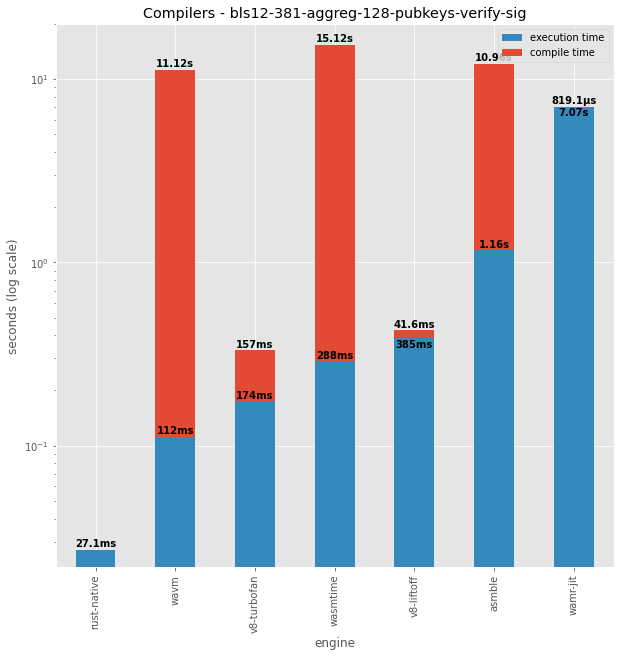

In [106]:
fig_plt = plotCompilerStackedOneTest(df_native_and_compile, "bls12-381-aggreg-128-pubkeys-verify-sig")
fig_plt.savefig('../images/standalone-bls12-381-aggreg-128-pubkeys-verify-sig-compilers-vs-native.png',  bbox_inches='tight')

## Interpreter vs Compiler speedup

In [107]:
# merge df_compiler and df_interp
df_interp_merge = df_interp.copy()
df_interp_merge.columns = ['test_name', 'elapsed_time', 'compile_time', 'exec_time', 'total_time']
df_interp_and_compile = pd.concat([df_interp_merge, df_compiler])
df_interp_and_compile = df_interp_and_compile.reset_index()

In [108]:
def add_engine_ratio_col(df_two_engines, interp_engine, compiler_engine):
    df_two = df_two_engines.copy(deep=True)
    df_interp = df_two[df_two['engine'] == interp_engine].copy()
    df_compile = df_two[df_two['engine'] == compiler_engine]
    for index, row in df_interp.iterrows():
        test_name = row['test_name']
        row_compiler = df_compile[df_compile['test_name'] == test_name]
        if len(row_compiler) != 1:
            print("ERROR. SHOULD HAVE 1 MATCH ONLY")
            break
        compiler_exec_time = row_compiler.iloc[0]['exec_time']
        exec_ratio = row['exec_time'] / compiler_exec_time
        df_interp.at[index, 'compiler_exec_time'] = compiler_exec_time
        df_interp.at[index, 'interp_slowdown'] = exec_ratio

    return df_interp

In [109]:
df_wabt_v8liftoff = add_engine_ratio_col(df_interp_and_compile, "wabt", "v8-liftoff")

In [110]:
def plotCompilerSpeedup(df_compiler_speedup, interp_name="interp", compiler_name="compiler"):
    df_is = df_compiler_speedup.copy()
    plot_tests = df_is['test_name'].tolist()
    test_index = all_tests.copy()
    for test_name in all_tests:
        if test_name not in plot_tests:
            test_index.remove(test_name)
 
    df_is = df_is.set_index('test_name')
    df_is = df_is.reindex(test_index)
    plt.figure()
    ax = df_is['interp_slowdown'].plot.bar(figsize=(13,7), color=COLORS_DEFAULT['blue'])
    ax.set_title("{} (Interpreter) vs {} (Compiler) - speedup".format(interp_name, compiler_name))
    ax.set(ylabel="compiler speedup (log scale)", xlabel="")

    y_max = ax.get_ylim()[1]
    y_max = y_max * 5 # padding between top of bars and legend
    ax.set_yscale('log')
    ax.set_ylim(0.1, y_max) # adjustment to move horizontal line higher on chart

    adjust_text_labels(labelBarHeights(ax, to_ms=False, to_factor=1, lower_y_bound=False))

    plt.axhline(y=1.0, linewidth=2, ls='--', color='r')

    handles, _ = ax.get_legend_handles_labels()

    plt.legend(labels=["compiler engine is faster (ratio > 1x)", "compiler speedup \n (ratio: interp_exec_time/compiler_exec_time)"])

    #f.suptitle(title, fontsize=16, y=0.95)
    return plt


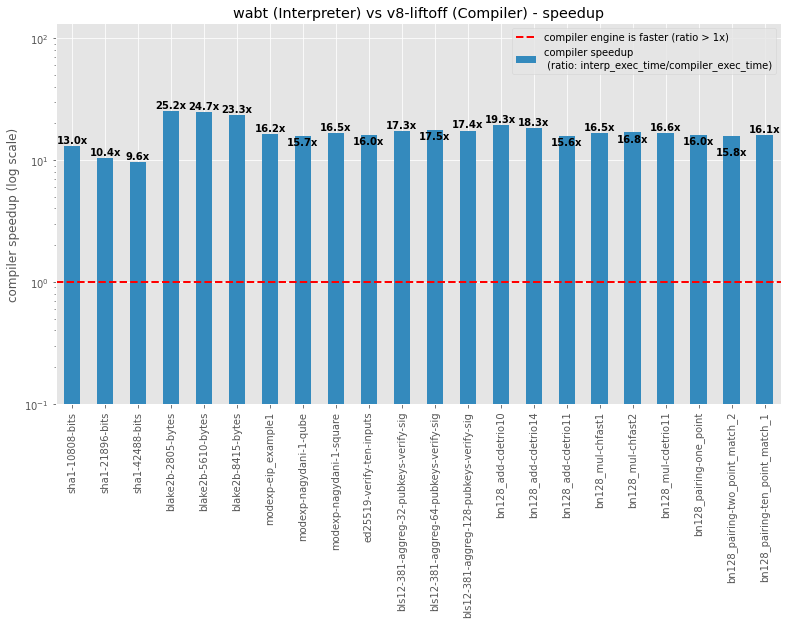

In [111]:
plt_fig = plotCompilerSpeedup(df_wabt_v8liftoff, interp_name="wabt", compiler_name="v8-liftoff")
plt_fig.savefig('../images/standalone-wabt-vs-v8-liftoff-speedup.png',  bbox_inches='tight')

## All precompiles compared (are interpreters feasible?)

In [112]:
def plotInterpOneEngine(df_benchdata, engine, test_names, title=""):
    df_bench = df_benchdata.loc[engine][df_benchdata.loc[engine]['test_name'].isin(test_names)]
    df_bench.set_index('test_name', inplace=True)
    df_bench = df_bench.reindex(test_names)
    plt.figure()
    ax = df_bench[['parse_time', 'exec_time']].plot.bar(stacked=True, figsize=(15,7), color=[COLORS_DEFAULT['red'], COLORS_DEFAULT['blue']])
    plt.ylabel("seconds")
    ax.set(xlabel='')
    # doing get_legend_handles_labels() so we can control the order of the labels in the legend 
    handles, labels = ax.get_legend_handles_labels()
    plt.legend([handles[1], handles[0]], ['execution time (top bar/label)', 'startup time (bottom bar/label - bar not visible for times < 20.0ms)'])
    adjust_text_labels(labelBarHeights(ax))
    plt.suptitle(title, fontsize=16, y=0.95)
    return plt

<Figure size 432x288 with 0 Axes>

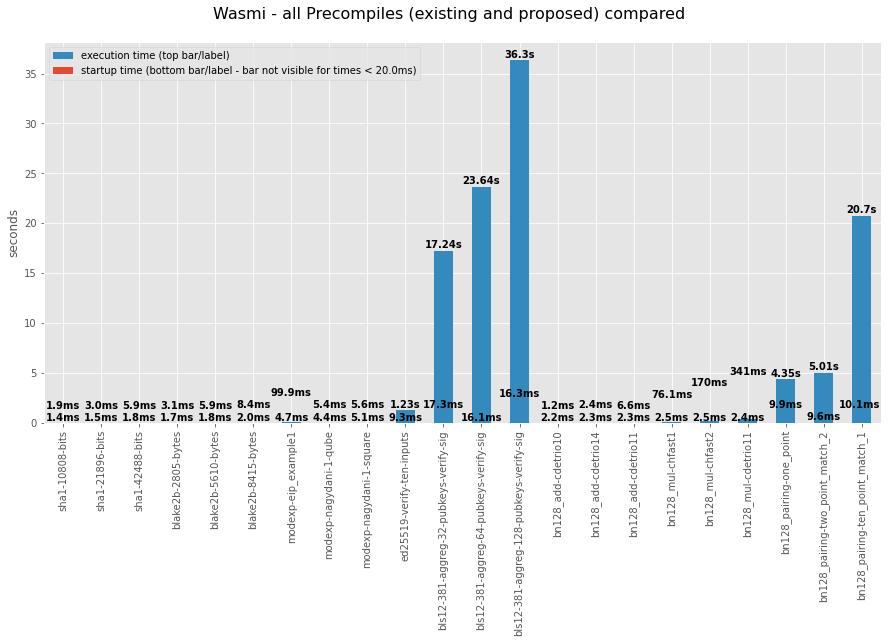

In [113]:
plt_fig = plotInterpOneEngine(df_interp, 'wasmi', all_tests, "Wasmi - all Precompiles (existing and proposed) compared")
plt_fig.savefig('../images/standalone-wasmi-all-precompiles.png',  bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

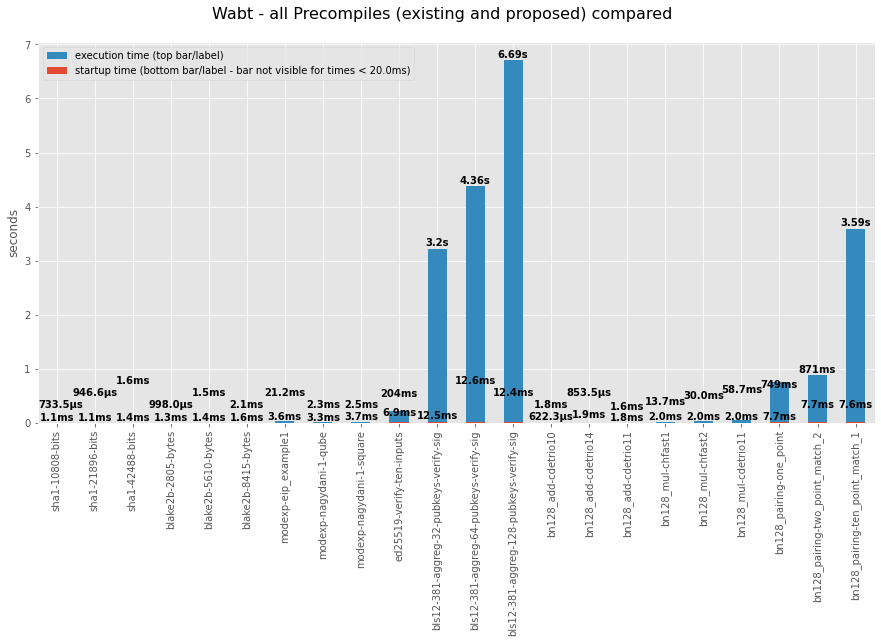

In [114]:
plt_fig = plotInterpOneEngine(df_interp, 'wabt', all_tests, "Wabt - all Precompiles (existing and proposed) compared")
plt_fig.savefig('../images/standalone-wabt-all-precompiles.png',  bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

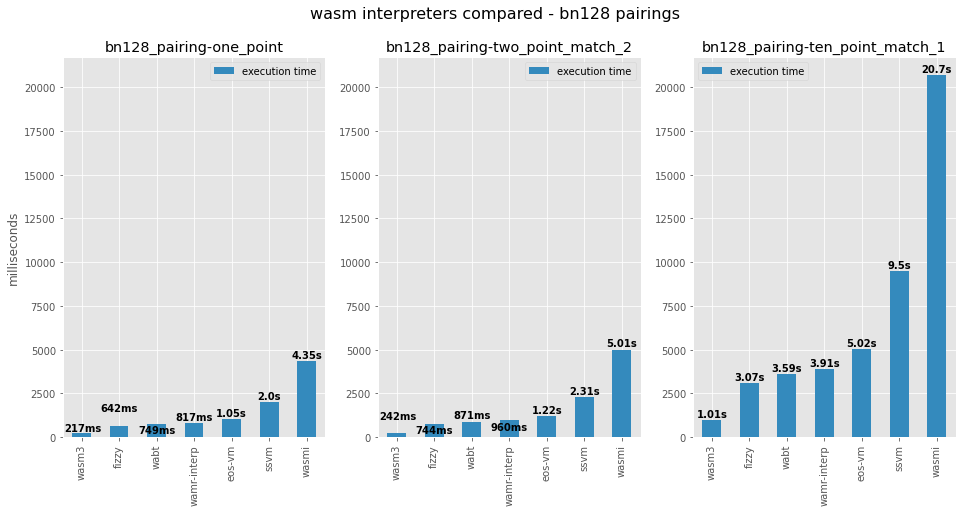

In [115]:
plt_fig = plotThreeTestsExecTime(df_interp,
                       bn128_pairing_test_names,
                       title="wasm interpreters compared - bn128 pairings",
                       filter_engines=["life", "wagon", "v8-interpreter"])
plt_fig.savefig('../images/standalone-wasm-interp-bn128-pairings.png',  bbox_inches='tight')

#### Are interpreter engines feasible for bn128 pairings?
TODO: highlight pairing two point match in interpreter engines



<Figure size 432x288 with 0 Axes>

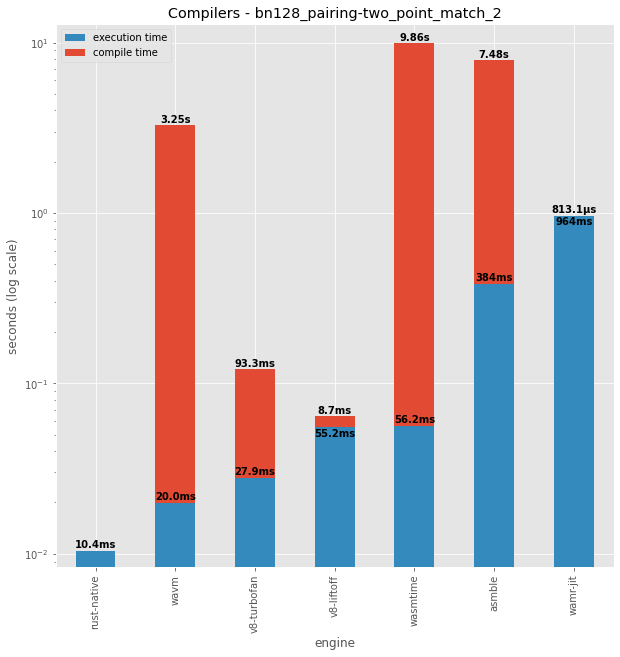

In [116]:
fig_plt = plotCompilerStackedOneTest(df_native_and_compile, "bn128_pairing-two_point_match_2")

fig_plt.savefig('../images/standalone-rust-bn128-pairings-compiler-vs-native.png', bbox_inches='tight')

#### Is any kind of wasm engine, interpreters or compilers, feasible for bn128 pairings?

V8-liftoff takes around 100ms, too slow relative to block processing time.

Can it be sped up? From profiling, we'd see that the bottleneck is bignum arithmetic. Maybe "native bignum methods", such as a mul256 opcode, would bring a significant speedup.

### add geth-native to df_scout_data for the rollup benchmark

In [117]:
df_geth_native_bn128pairing

precompile_name                    input_name     gas      time
57  PrecompiledBn256Pairing  two_point_match_rollup_input  113000  0.003993

In [118]:
df_geth_native_bn128pairing.loc[:, 'engine'] = "go-native"
df_geth_native_bn128pairing.loc[:, 'parse_time'] = 0

In [119]:
df_geth_native_bn128pairing.rename(columns={'input_name':'bench_name','time':'exec_time'},inplace=True)
df_geth_native_bn128pairing.drop(['precompile_name'],axis=1,inplace=True)
df_geth_native_bn128pairing.drop(['gas'],axis=1,inplace=True)
df_geth_native_bn128pairing = df_geth_native_bn128pairing[['engine', 'bench_name', 'parse_time', 'exec_time']]

In [120]:
df_geth_native_bn128pairing.loc[:,'bench_name'] = 'ecpairing-zkrollup-go-native-bn128-two-pairings'

In [121]:
df_geth_native_bn128pairing

engine                                       bench_name  parse_time  \
57  go-native  ecpairing-zkrollup-go-native-bn128-two-pairings         0.0   

    exec_time  
57   0.003993

## list engine names

In [122]:


df_scout_rust_vs_websnark = df_scout_data[
    df_scout_data['bench_name'].isin(
        ['ecpairing-zkrollup-rust-wasm-bn128-two-pairings',
         'ecpairing-zkrollup-websnark-bn128-two-pairings',
         'ecpairing-zkrollup-rust-native-bn128-two-pairings']
    )
]

df_scout_rust_vs_websnark = df_scout_rust_vs_websnark.append(df_geth_native_bn128pairing)

df_scout_rust_vs_websnark['engine'].unique().tolist()



['rust-native',
 'wabt-no-bignums',
 'wabt-bignums-slowhost-slowmont',
 'wabt-bignums-slowhost-slowmont-superops',
 'wabt-bignums-fasthost-slowmont-superops',
 'wabt-bignums-fasthost-fastmont-superops',
 'wabt-bignums-fasthost-fastmont',
 'v8-turbofan',
 'v8-liftoff',
 'v8-liftoff-and-turbofan',
 'v8-interpreter',
 'v8-turbofan-with-bignums',
 'v8-liftoff-with-bignums',
 'v8-interpreter-with-bignums',
 'go-native']

## function to prepare dataframe for rollup.rs and websnark plots


In [123]:
def prepDfForRollupPlot(df_scout_data, df_geth_native, include_bench_names, only_include_engines=None, rename_engines=None):
    df_scout_rollup = df_scout_data[
        df_scout_data['bench_name'].isin(include_bench_names)
    ].copy()

    df_scout_rollup = df_scout_rollup.fillna(0)
    df_scout_rollup = df_scout_rollup.append(df_geth_native).copy()
    if only_include_engines is not None:
        df_scout_rollup = df_scout_rollup[df_scout_rollup['engine'].isin(only_include_engines)]
    # rename_engines example: [['wabt-bignums-slowhost-slowmont', 'wabt-with-bignums']]
    if rename_engines is not None:
        for rename in rename_engines:
            df_scout_rollup.replace(rename[0], rename[1], inplace=True)
    return df_scout_rollup

### rust-wasm: bignums optimization - basic bignums speedup (wabt-with-bignums)

In [124]:
include_bench_names = ['ecpairing-zkrollup-rust-wasm-bn128-two-pairings', 'ecpairing-zkrollup-rust-native-bn128-two-pairings']

df_scout_rolluprs_bignums_vs_nobignums = \
    prepDfForRollupPlot(df_scout_data,
                        df_geth_native_bn128pairing,
                        include_bench_names,
                        only_include_engines=['go-native', 'rust-native', 'v8-liftoff', 'v8-turbofan', 'wabt-bignums-slowhost-slowmont', 'wabt-no-bignums'],
                        rename_engines=[['wabt-bignums-slowhost-slowmont', 'wabt-with-bignums']]
                        )

df_scout_rolluprs_bignums_vs_nobignums = df_scout_rolluprs_bignums_vs_nobignums.groupby(['engine']).mean()

<Figure size 432x288 with 0 Axes>

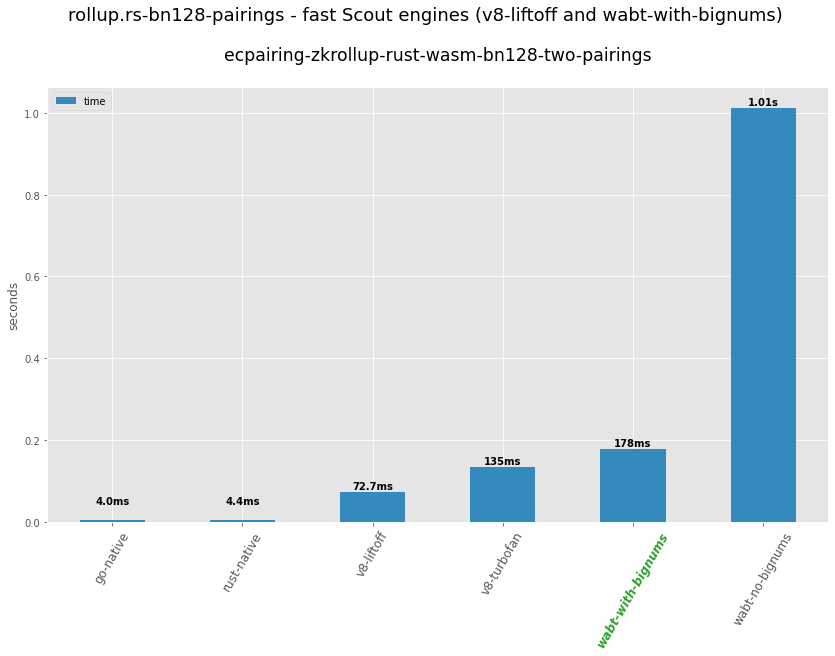

In [125]:
fig_plt = plotOneTestColoredTicks(df_scout_rolluprs_bignums_vs_nobignums,
            suptitle="rollup.rs-bn128-pairings - fast Scout engines (v8-liftoff and wabt-with-bignums)",
            suptitle_pos=1.02,
            subtitle="ecpairing-zkrollup-rust-wasm-bn128-two-pairings\n",
            subtitle_size='xx-large',
            highlight_ticks=["wabt-with-bignums"])

fig_plt.savefig('../images/bignums-rollup-rs-bn128-pairings-with-vs-without-bignums.png', bbox_inches='tight')

#### Are interpreter engines feasible, given an API for fast bignums?

From wabt-no-bignums at 1.18s, adding a bignum API achieves a 5x+ speedup to 172ms! Our interpreter is about 2x slower than a fast JIT engine, v8-liftoff at 91ms. Is there any way to speed it up?




### rust-wasm: remove wabt-no-bignums from chart.  compare only wabt-with-bignums vs compilers

In [126]:
include_bench_names = ['ecpairing-zkrollup-rust-wasm-bn128-two-pairings', 'ecpairing-zkrollup-rust-native-bn128-two-pairings']


df_scout_rolluprs_bignums = \
    prepDfForRollupPlot(df_scout_data,
                        df_geth_native_bn128pairing,
                        include_bench_names,
                        only_include_engines=['go-native', 'rust-native', 'v8-liftoff', 'v8-turbofan', 'wabt-bignums-slowhost-slowmont'],
                        rename_engines=[['wabt-bignums-slowhost-slowmont', 'wabt-with-bignums']]
                        )


df_scout_rolluprs_bignums = df_scout_rolluprs_bignums.groupby(['engine']).mean()


<Figure size 432x288 with 0 Axes>

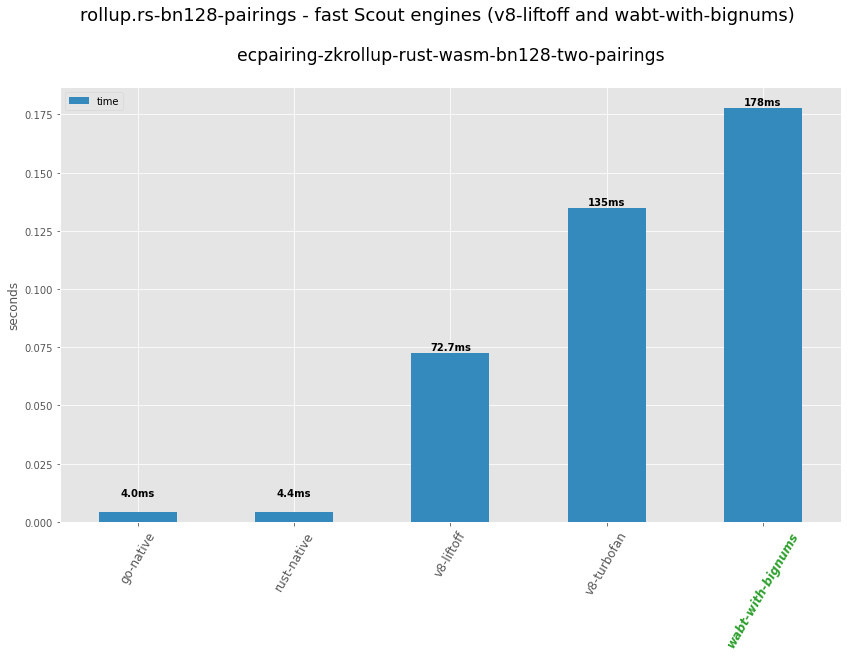

In [127]:
fig_plt = plotOneTestColoredTicks(df_scout_rolluprs_bignums,
            suptitle="rollup.rs-bn128-pairings - fast Scout engines (v8-liftoff and wabt-with-bignums)",
            suptitle_pos=1.02,
            subtitle="ecpairing-zkrollup-rust-wasm-bn128-two-pairings\n",
            subtitle_size='xx-large',
            highlight_ticks=["wabt-with-bignums"])

fig_plt.savefig('../images/bignums-rollup-rs-bn128-pairings-wabt-with-bignums.png', bbox_inches='tight')

### rust-wasm: Superops optimization

In [128]:
include_bench_names = ['ecpairing-zkrollup-rust-wasm-bn128-two-pairings', 'ecpairing-zkrollup-rust-native-bn128-two-pairings']

include_engines_list = ['go-native', 'rust-native', 'v8-liftoff', 'v8-turbofan',
                        'wabt-bignums-slowhost-slowmont', 'wabt-bignums-slowhost-slowmont-superops']


df_scout_rollup_rustwasm_superops = \
    prepDfForRollupPlot(df_scout_data,
                        df_geth_native_bn128pairing,
                        include_bench_names,
                        only_include_engines=include_engines_list,
                        rename_engines=[
                            ['wabt-bignums-slowhost-slowmont', 'wabt-with-bignums'],
                            ['wabt-bignums-slowhost-slowmont-superops', 'wabt-bignums-superops']
                        ])

df_scout_rollup_rustwasm_superops = df_scout_rollup_rustwasm_superops.groupby(['engine']).mean()

<Figure size 432x288 with 0 Axes>

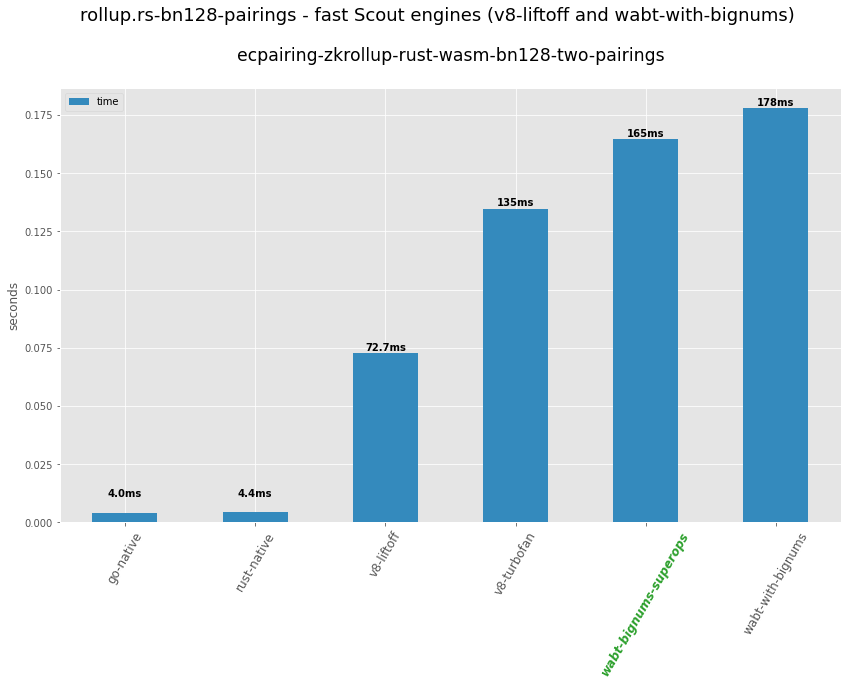

In [129]:
fig_plt = plotOneTestColoredTicks(df_scout_rollup_rustwasm_superops,
            suptitle="rollup.rs-bn128-pairings - fast Scout engines (v8-liftoff and wabt-with-bignums)",
            suptitle_pos=1.02,
            subtitle="ecpairing-zkrollup-rust-wasm-bn128-two-pairings\n",
            subtitle_size='xx-large',
            highlight_ticks=["wabt-bignums-superops"])

fig_plt.savefig('../images/bignums-rollup-rs-bn128-pairings-superops.png', bbox_inches='tight')

### rust-wasm: in addition to superops, plot combied superops + fasthost, and superops + fasthost + fastmont

In [130]:
include_bench_names = ['ecpairing-zkrollup-rust-wasm-bn128-two-pairings', 'ecpairing-zkrollup-rust-native-bn128-two-pairings']

include_engines_list = ['go-native', 'rust-native', 'v8-liftoff', 'v8-turbofan',
                        'wabt-bignums-slowhost-slowmont', 'wabt-bignums-slowhost-slowmont-superops',
                        'wabt-bignums-fasthost-slowmont-superops', 'wabt-bignums-fasthost-fastmont-superops']

df_scout_rolluprs_all_combos = \
    prepDfForRollupPlot(df_scout_data,
                        df_geth_native_bn128pairing,
                        include_bench_names,
                        only_include_engines=include_engines_list,
                        rename_engines=[
                            ['wabt-bignums-slowhost-slowmont', 'wabt-with-bignums'],
                            ['wabt-bignums-slowhost-slowmont-superops', 'wabt-bignums-superops'],
                            ['wabt-bignums-fasthost-slowmont-superops', 'wabt-bignums-superops-fasthost-slowmont'],
                            ['wabt-bignums-fasthost-fastmont-superops', 'wabt-bignums-superops-fasthost-fastmont']
                        ])

df_scout_rolluprs_all_combos = df_scout_rolluprs_all_combos.groupby(['engine']).mean()


<Figure size 432x288 with 0 Axes>

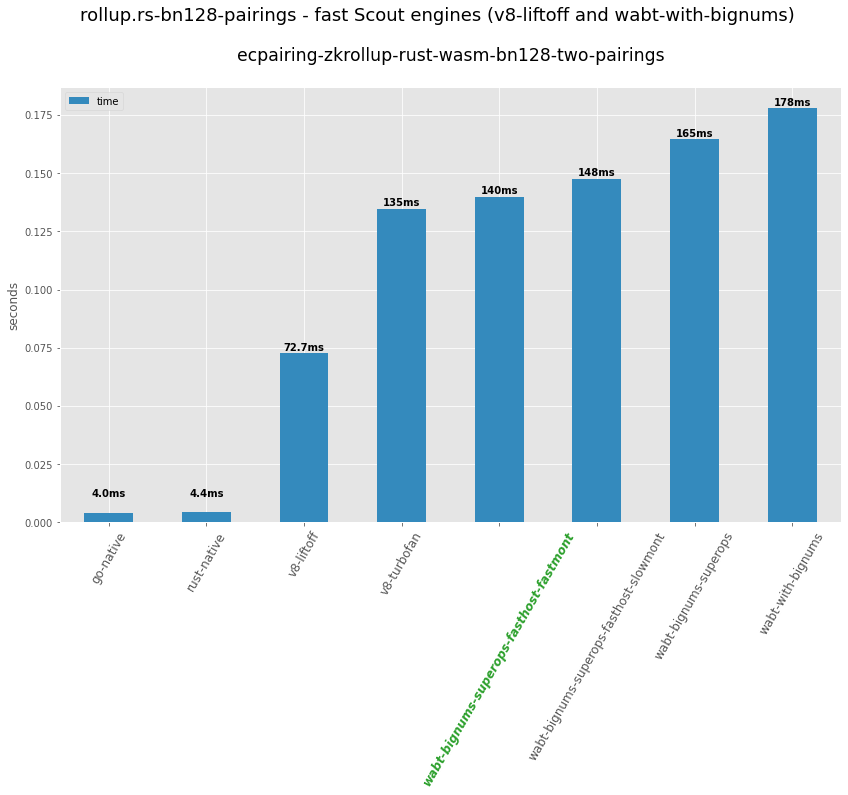

In [131]:
fig_plt = plotOneTestColoredTicks(df_scout_rolluprs_all_combos,
            suptitle="rollup.rs-bn128-pairings - fast Scout engines (v8-liftoff and wabt-with-bignums)",
            suptitle_pos=1.02,
            subtitle="ecpairing-zkrollup-rust-wasm-bn128-two-pairings\n",
            subtitle_size='xx-large',
            highlight_ticks=["wabt-bignums-superops-fasthost-fastmont"])

fig_plt.savefig('../images/bignums-rollup-rs-bn128-pairings-all-combos.png', bbox_inches='tight')

### Optimization: websnark-wasm vs rust-wasm

In [132]:
include_bench_names = ['ecpairing-zkrollup-rust-wasm-bn128-two-pairings', 'ecpairing-zkrollup-websnark-bn128-two-pairings']

include_engines_list = ['v8-liftoff', 'v8-turbofan',
                        'wabt-bignums-slowhost-slowmont', 'wabt-bignums-slowhost-slowmont-superops']

df_scout_rust_vs_websnark = \
    prepDfForRollupPlot(df_scout_data,
                        df_geth_native_bn128pairing,
                        include_bench_names,
                        only_include_engines=include_engines_list,
                        rename_engines=[
                            ['ecpairing-zkrollup-rust-wasm-bn128-two-pairings', 'rust-wasm'],
                            ['ecpairing-zkrollup-websnark-bn128-two-pairings', 'websnark-wasm'],
                            ['wabt-bignums-slowhost-slowmont', 'wabt-with-bignums'],
                            ['wabt-bignums-slowhost-slowmont-superops', 'wabt-bignums-superops']
                        ])

<Figure size 432x288 with 0 Axes>

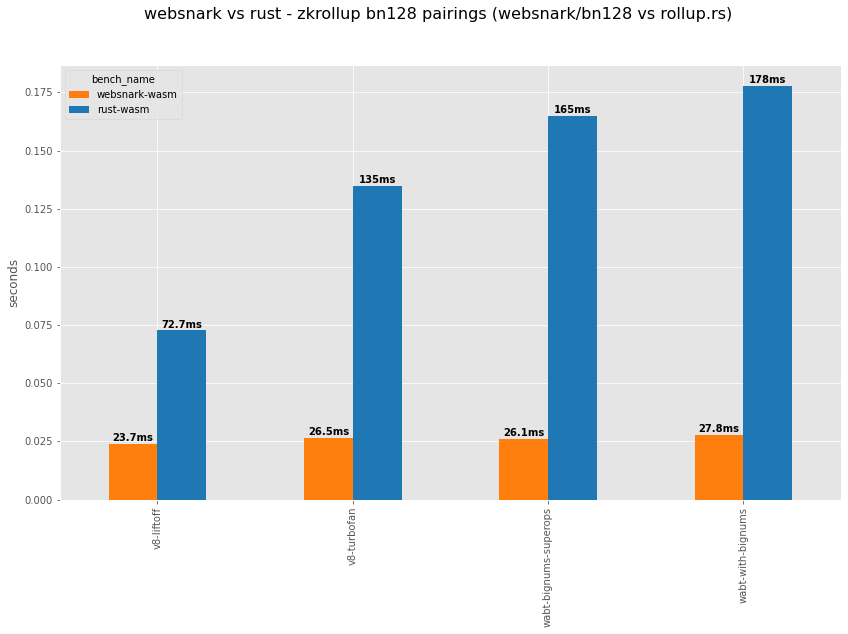

In [133]:
fig_plt = plotOneTestGrouped(df_scout_rust_vs_websnark,
                   title="websnark vs rust - zkrollup bn128 pairings (websnark/bn128 vs rollup.rs)",
                   test_title="",
                   group_order=['websnark-wasm', 'rust-wasm'],
                   sort_by=['rust-wasm'],
                   colors=['tab:orange', 'tab:blue'])


fig_plt.savefig('../images/bignums-zkrollup-rust-vs-websnark-bn128-pairings.png', bbox_inches='tight')

### drop rust-wasm, just plot websnark-wasm on different engines

In [134]:
include_engines_list = ['go-native', 'rust-native', 'v8-liftoff', 'v8-turbofan',
                        'wabt-bignums-slowhost-slowmont', 'wabt-bignums-slowhost-slowmont-superops']

include_bench_names = ['ecpairing-zkrollup-websnark-bn128-two-pairings',
                       'ecpairing-zkrollup-rust-native-bn128-two-pairings']

df_scout_websnark = prepDfForRollupPlot(df_scout_data,
                                        df_geth_native_bn128pairing,
                                        include_bench_names,
                                        only_include_engines=include_engines_list,
                                        rename_engines=[
                                            ['wabt-bignums-slowhost-slowmont', 'wabt-with-bignums'],
                                            ['wabt-bignums-slowhost-slowmont-superops', 'wabt-bignums-superops']
                                        ]
                                       )

df_scout_means_websnark = df_scout_websnark.groupby(['engine']).mean()


<Figure size 432x288 with 0 Axes>

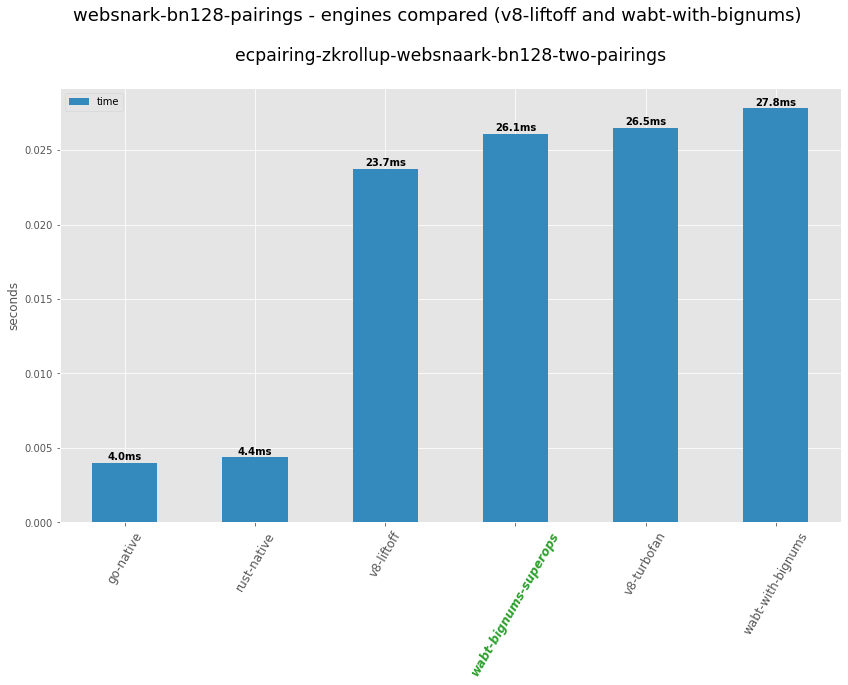

In [135]:
fig_plt = plotOneTestColoredTicks(df_scout_means_websnark,
            suptitle="websnark-bn128-pairings - engines compared (v8-liftoff and wabt-with-bignums)",
            suptitle_pos=1.02,
            subtitle="ecpairing-zkrollup-websnaark-bn128-two-pairings\n",
            subtitle_size='xx-large',
            highlight_ticks=["wabt-bignums-superops"])

fig_plt.savefig('../images/bignums-websnark-bn128-pairings-superops.png', bbox_inches='tight')

### websnark-wasm optimization: "fast-host"


In [136]:
include_engines_list = ['go-native', 'rust-native', 'v8-liftoff', 'v8-turbofan',
                        'wabt-bignums-slowhost-slowmont', 'wabt-bignums-slowhost-slowmont-superops',
                        'wabt-bignums-slowhost-slowmont-superops', 'wabt-bignums-fasthost-slowmont-superops']

include_bench_names = ['ecpairing-zkrollup-websnark-bn128-two-pairings',
                       'ecpairing-zkrollup-rust-native-bn128-two-pairings']

df_scout_websnark_fasthost = prepDfForRollupPlot(df_scout_data,
                                        df_geth_native_bn128pairing,
                                        include_bench_names,
                                        only_include_engines=include_engines_list,
                                        rename_engines=[
                                            ['wabt-bignums-slowhost-slowmont', 'wabt-with-bignums'],
                                            ['wabt-bignums-slowhost-slowmont-superops', 'wabt-bignums-superops'],
                                            ['wabt-bignums-fasthost-slowmont-superops', 'wabt-bignums-superops-fasthost']
                                        ]
                                       )

df_scout_websnark_fasthost = df_scout_websnark_fasthost.groupby(['engine']).mean()

<Figure size 432x288 with 0 Axes>

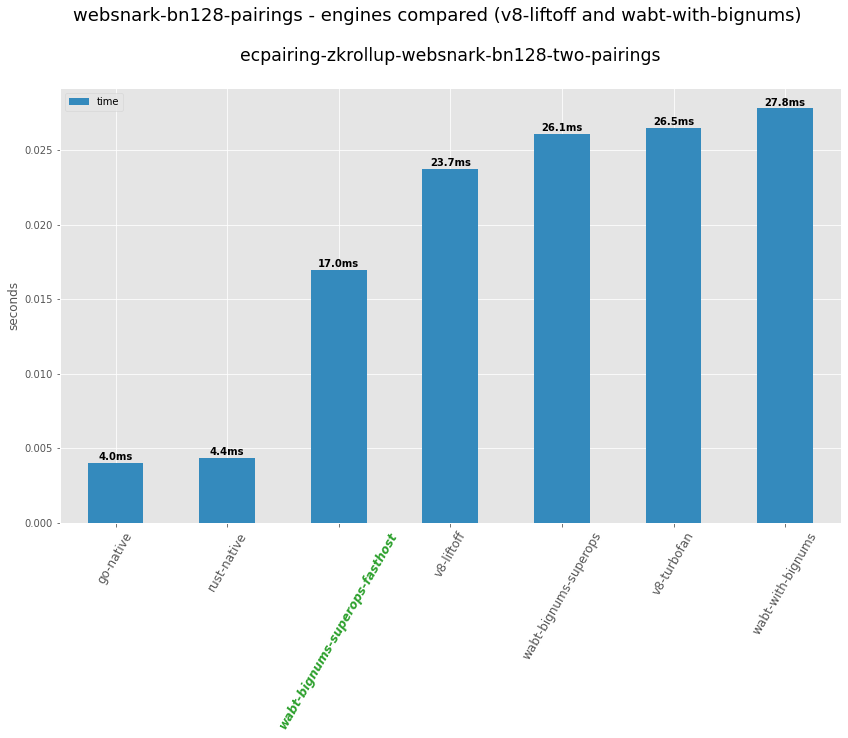

In [137]:
fig_plt  = plotOneTestColoredTicks(df_scout_websnark_fasthost,
            suptitle="websnark-bn128-pairings - engines compared (v8-liftoff and wabt-with-bignums)",
            suptitle_pos=1.02,
            subtitle="ecpairing-zkrollup-websnark-bn128-two-pairings\n",
            subtitle_size='xx-large',
            highlight_ticks=["wabt-bignums-superops-fasthost"])

fig_plt.savefig('../images/bignums-websnark-bn128-pairings-fasthost.png', bbox_inches='tight')

### websnark-wasm optimization: interleaved montgomery

In [138]:
include_engines_list = ['go-native', 'rust-native', 'v8-liftoff', 'v8-turbofan', 'wabt-bignums-slowhost-slowmont',
                        'wabt-bignums-slowhost-slowmont-superops', 'wabt-bignums-slowhost-slowmont-superops',
                        'wabt-bignums-fasthost-slowmont-superops', 'wabt-bignums-fasthost-fastmont-superops']

include_bench_names = ['ecpairing-zkrollup-websnark-bn128-two-pairings',
                       'ecpairing-zkrollup-rust-native-bn128-two-pairings']

df_scout_websnark_fastmont = \
    prepDfForRollupPlot(df_scout_data,
                        df_geth_native_bn128pairing,
                        include_bench_names,
                        only_include_engines=include_engines_list,
                        rename_engines=[
                            ['wabt-bignums-slowhost-slowmont', 'wabt-with-bignums'],
                            ['wabt-bignums-slowhost-slowmont-superops', 'wabt-bignums-superops'],
                            ['wabt-bignums-fasthost-slowmont-superops', 'wabt-bignums-superops-fasthost'],
                            ['wabt-bignums-fasthost-fastmont-superops', 'wabt-bignums-superops-fasthost-fastmont']
                        ])

df_scout_websnark_fastmont = df_scout_websnark_fastmont.groupby(['engine']).mean()

<Figure size 432x288 with 0 Axes>

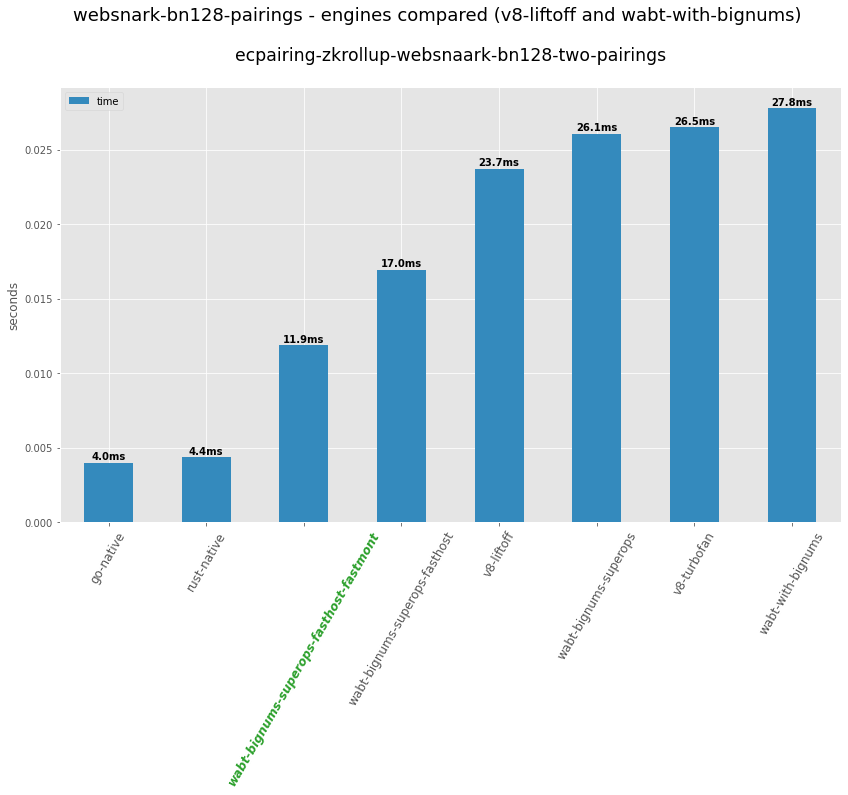

In [139]:
fig_plt = plotOneTestColoredTicks(df_scout_websnark_fastmont,
            suptitle="websnark-bn128-pairings - engines compared (v8-liftoff and wabt-with-bignums)",
            suptitle_pos=1.02,
            subtitle="ecpairing-zkrollup-websnaark-bn128-two-pairings\n",
            subtitle_size='xx-large',
            highlight_ticks=["wabt-bignums-superops-fasthost-fastmont"])

fig_plt.savefig('../images/bignums-websnark-bn128-pairings-fastmont.png', bbox_inches='tight')


### websnark-wasm: Show startup time and execution time, for interleaved montgomery and other optimizations

<Figure size 432x288 with 0 Axes>

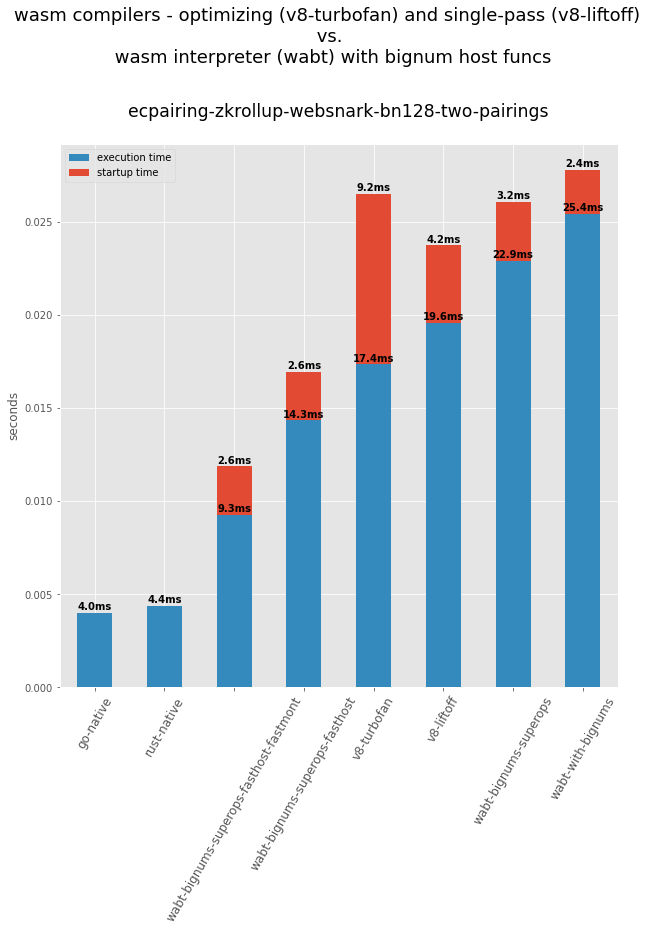

In [140]:
fig_plt = plotScoutStackedTest(df_scout_websnark_fastmont,
            suptitle="wasm compilers - optimizing (v8-turbofan) and single-pass (v8-liftoff) \n vs. \n wasm interpreter (wabt) with bignum host funcs",
            suptitle_pos=1.07,
            subtitle="ecpairing-zkrollup-websnark-bn128-two-pairings\n",
            subtitle_size='xx-large')

fig_plt.savefig('../images/bignums-websnark-bn128-pairings-startup-and-execution.png', bbox_inches='tight')


## plot v8 with bignums versus without


In [141]:
include_engines_list = ['go-native', 'rust-native', 'v8-liftoff', 'v8-turbofan',
                        'v8-turbofan-with-bignums', 'v8-liftoff-with-bignums',
                        'wabt-bignums-fasthost-fastmont-superops']

include_bench_names = ['ecpairing-zkrollup-websnark-bn128-two-pairings',
                       'ecpairing-zkrollup-rust-native-bn128-two-pairings']

df_scout_v8_with_hostfuncs = prepDfForRollupPlot(df_scout_data,
                                        df_geth_native_bn128pairing,
                                        include_bench_names,
                                        only_include_engines=include_engines_list,
                                        rename_engines=[
                                            ['wabt-bignums-slowhost-slowmont', 'wabt-with-bignums'],
                                            ['wabt-bignums-slowhost-slowmont-superops', 'wabt-bignums-superops'],
                                            ['wabt-bignums-fasthost-slowmont-superops', 'wabt-bignums-superops-fasthost'],
                                            ['wabt-bignums-fasthost-fastmont-superops', 'wabt-bignums-superops-fasthost-fastmont']
                                        ]
                                       )

df_scout_v8_with_hostfuncs = df_scout_v8_with_hostfuncs.groupby(['engine']).mean()

In [142]:
plt.style.use('ggplot')

<Figure size 432x288 with 0 Axes>

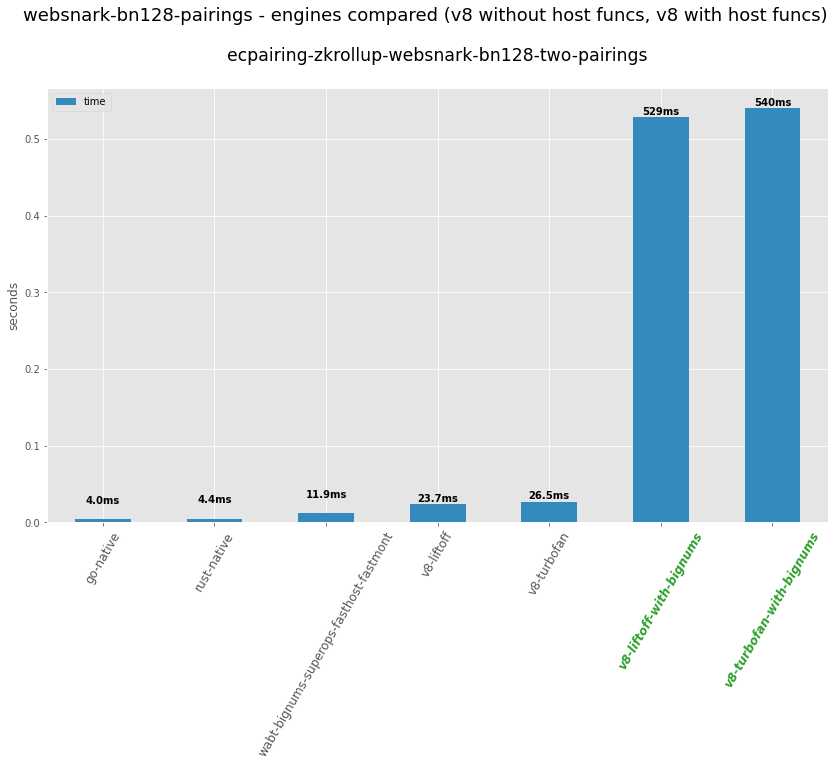

In [143]:
fig_plt = plotOneTestColoredTicks(df_scout_v8_with_hostfuncs,
            suptitle="websnark-bn128-pairings - engines compared (v8 without host funcs, v8 with host funcs)",
            suptitle_pos=1.02,
            subtitle="ecpairing-zkrollup-websnark-bn128-two-pairings\n",
            subtitle_size='xx-large',
            highlight_ticks=["v8-liftoff-with-bignums", "v8-turbofan-with-bignums"])



fig_plt.savefig('../images/bignums-websnark-bn128-pairings-v8-with-bignums.png', bbox_inches='tight')

## plot function for EVM vs Wasm

In [144]:
def plotEVMvsWasm(df_evm_vs_wasm, colors=['tab:blue', 'tab:orange'], dodge=False):
    f = plt.figure(figsize=(14,8))
    #sns.set()
    sns.reset_defaults() # use default colors, orange and blue
    #sns.set(font_scale = 1.2)
    splot = sns.barplot(x='engine', y='time', hue='bench_name', dodge=dodge,
            #hue_order=['blake2b-8kb.huff.evm', 'blake2b-8kb.rust.wasm'],
            #hue_order=['blake2b-8kb.rust.wasm', 'blake2b-8kb.huff.evm'],
            #order=['blake2b-8kb.huff.evm', 'blake2b-8kb.rust.wasm'],
            #order='exec_time',
            #order=[""]
            palette=colors,
            data=df_evm_vs_wasm)


    # annotating bars: https://github.com/mwaskom/seaborn/issues/1582
    for p in splot.patches:
        splot.annotate(
                       #format(p.get_height(), '.4f'),
                       toMs(p.get_height()),
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha = 'center', va = 'center',
                       xytext = (0, 10),
                       textcoords = 'offset points')

    splot.set_xticklabels(splot.get_xticklabels(), size = 14)
    plt.legend(fontsize='x-large', title_fontsize='40')
    #f.suptitle("title", fontsize=18, y=1.02)
    return f


## EVM vs wasm shootout: bn128mul (Weierstrudel vs bn128mul.rust.wasm)


In [145]:
df_evm_raw

engine                         test_name   total_time  gas_used
0        engine                         test_name   total_time  gas_used
1        evmone                   sha1-10808-bits  0.002056286    790156
2        evmone                   sha1-21896-bits   0.00393736   1543605
3        evmone                   sha1-42488-bits  0.007656268   3014404
4        evmone          sha1-10808-bits-shiftopt  0.001038472    759785
5        evmone          sha1-21896-bits-shiftopt  0.002031567   1484254
6        evmone          sha1-42488-bits-shiftopt  0.004000971   2898473
7        evmone               bn256g2mul-0xAshish  0.001509638    455757
8        evmone       blake2b-8415-bytes-shiftopt  0.018414062  12043105
9        evmone       blake2b-5610-bytes-shiftopt   0.01218996   7434820
10       evmone       blake2b-2805-bytes-shiftopt  0.006019918   3423526
11       evmone          mul256-gcolvin-drag-race  0.009680082   5610277
12       evmone   bn128_mul_weierstrudel-cdetrio2  0.000397231     47165
13       evmone    bn128_mul_weierstrudel-chfast1  0.000210124     23449
14       evmone    bn128_mul_weierstrudel-chfast2  0.000339741     39337
15       evmone    bn128_mul_weierstrudel-chfast3  0.000399416     47291
16       evmone   bn128_mul_weierstrudel-cdetrio6   0.00039595     47561
17       evmone   bn128_mul_weierstrudel-cdetrio7  0.000398454     47165
18       evmone  bn128_mul_weierstrudel-cdetrio11  0.000404129     47561
19       evmone  bn128_mul_weierstrudel-cdetrio12  0.000396089     47165
20       evmone                blake2b-8415-bytes  0.022527799  12351815
21       evmone                blake2b-5610-bytes  0.015275491   7640669
22       evmone                blake2b-2805-bytes  0.007459261   3526514
23       evmone           blake2b_huff-8415-bytes  0.001514828    879920
24       evmone           blake2b_huff-5610-bytes  0.001142694    586839
25       evmone           blake2b_huff-2805-bytes  0.000524197    293755
26       engine                         test_name   total_time  gas_used
27   parity-evm                   sha1-10808-bits  0.069457059    790156
28   parity-evm                   sha1-21896-bits  0.128567939   1543605
29   parity-evm                   sha1-42488-bits  0.250837896   3014404
30   parity-evm          sha1-10808-bits-shiftopt  0.026990627    759785
31   parity-evm          sha1-21896-bits-shiftopt  0.047456338   1484254
32   parity-evm          sha1-42488-bits-shiftopt  0.092930734   2898473
33   parity-evm               bn256g2mul-0xAshish  0.024067669    455757
34   parity-evm       blake2b-8415-bytes-shiftopt  0.302345632  12043105
35   parity-evm       blake2b-5610-bytes-shiftopt  0.216411367   7434820
36   parity-evm       blake2b-2805-bytes-shiftopt  0.116367526   3423526
37   parity-evm          mul256-gcolvin-drag-race  0.143134311   5610277
38   parity-evm   bn128_mul_weierstrudel-cdetrio2  0.004681313     47165
39   parity-evm    bn128_mul_weierstrudel-chfast1  0.002312094     23449
40   parity-evm    bn128_mul_weierstrudel-chfast2  0.003910487     39337
41   parity-evm    bn128_mul_weierstrudel-chfast3  0.004720527     47291
42   parity-evm   bn128_mul_weierstrudel-cdetrio6  0.004867541     47561
43   parity-evm   bn128_mul_weierstrudel-cdetrio7  0.004679791     47165
44   parity-evm  bn128_mul_weierstrudel-cdetrio11  0.004646788     47561
45   parity-evm  bn128_mul_weierstrudel-cdetrio12  0.004630612     47165
46   parity-evm                blake2b-8415-bytes  0.340011586  12351815
47   parity-evm                blake2b-5610-bytes  0.205717038   7640669
48   parity-evm                blake2b-2805-bytes  0.096635901   3526514
49   parity-evm           blake2b_huff-8415-bytes  0.026595507    879920
50   parity-evm           blake2b_huff-5610-bytes   0.01661306    586839
51   parity-evm           blake2b_huff-2805-bytes  0.009291144    293755
52       engine                         test_name   total_time  gas_used
53     geth-evm                   sha1-10808-bits  0.015162857    7

In [146]:
df_evm_raw.columns = df_evm_raw.columns.str.replace(' ','')

In [147]:
df_evm_raw.keys()

Index(['engine', 'test_name', 'total_time', 'gas_used'], dtype='object')

In [148]:
df_evm_raw[df_evm_raw['test_name'] == "bn128_mul_weierstrudel-chfast2"]

engine                       test_name   total_time gas_used
14      evmone  bn128_mul_weierstrudel-chfast2  0.000339741    39337
40  parity-evm  bn128_mul_weierstrudel-chfast2  0.003910487    39337
66    geth-evm  bn128_mul_weierstrudel-chfast2  0.001490949    39337
92    cita-evm  bn128_mul_weierstrudel-chfast2  0.013854024    66865

In [149]:
# get wasm data for bn128_mul-chfast2
df_wasm_bn128mul = df_interp[df_interp['test_name'] == "bn128_mul-chfast2"].copy()
df_wasm_bn128mul.rename(columns={'test_name':'bench_name'},inplace=True)
df_wasm_bn128mul.drop(['elapsed_time'],axis=1,inplace=True)
df_wasm_bn128mul.drop(['total_time'],axis=1,inplace=True)
#df_wasm_mul256 = df_wasm_mul256[['engine', 'bench_name', 'parse_time', 'exec_time']]
df_wasm_bn128mul.reset_index(inplace=True)
df_wasm_bn128mul.replace('bn128_mul-chfast2', 'bn128mul.rust.wasm', inplace=True)

In [150]:
# get evm data
df_evm_bn128mul = df_evm_raw[df_evm_raw['test_name'] == "bn128_mul_weierstrudel-chfast2"].copy()
df_evm_bn128mul.rename(columns={'test_name':'bench_name', 'total_time':'exec_time'},inplace=True)
df_evm_bn128mul.drop(['gas_used'],axis=1,inplace=True)
df_evm_bn128mul.loc[:, 'parse_time'] = 0
df_evm_bn128mul = df_evm_bn128mul[['engine', 'bench_name', 'parse_time', 'exec_time']]

df_evm_bn128mul.replace('bn128_mul_weierstrudel-chfast2', 'bn128mul.weierstrudel.evm', inplace=True)

In [151]:
df_evm_vs_wasm_bn128mul = df_evm_bn128mul.append(df_wasm_bn128mul, sort=False).copy()


df_evm_vs_wasm_bn128mul.loc[:,'time'] = df_evm_vs_wasm_bn128mul['parse_time'].astype(float) + df_evm_vs_wasm_bn128mul['exec_time'].astype(float)

df_evm_vs_wasm_bn128mul = df_evm_vs_wasm_bn128mul[df_evm_vs_wasm_bn128mul['engine'].isin(
    ['parity-evm', 'geth-evm', 'evmone', 'cita-evm',
    'ssvm', 'wasmi', 'wabt', 'fizzy', 'eos-vm', 'wasm3']
)].copy()

df_evm_vs_wasm_bn128mul = df_evm_vs_wasm_bn128mul.sort_values('time')

In [152]:
#df_evm_vs_wasm_bn128mul[df_evm_vs_wasm_bn128mul['bench_name'] == '']
df_evm_vs_wasm_bn128mul.replace('bn128mul.weierstrudel.evm', 'EVM (weierstrudel.huff)', inplace=True)
df_evm_vs_wasm_bn128mul.replace('bn128mul.rust.wasm', 'Wasm (bn128mul.rs)', inplace=True)

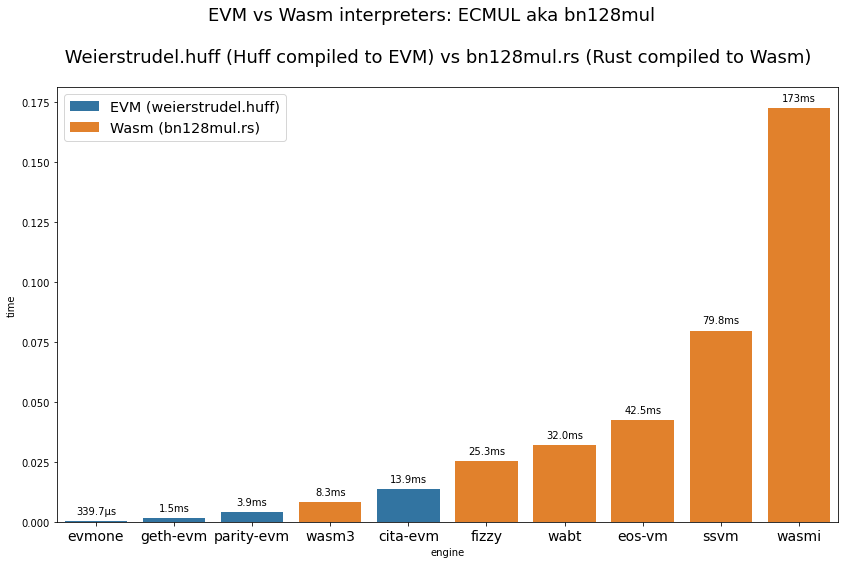

In [153]:
f = plotEVMvsWasm(df_evm_vs_wasm_bn128mul)

#f.suptitle("EVM vs Wasm interpreters: bn128mul aka ECMUL \n\n bn128mul (Rust compiled to Wasm) vs Weierstrudel (Huff compiled to EVM)", fontsize=18, y=1.02)
f.suptitle("EVM vs Wasm interpreters: ECMUL aka bn128mul \n\n Weierstrudel.huff (Huff compiled to EVM) vs bn128mul.rs (Rust compiled to Wasm)", fontsize=18, y=1.02)
f.savefig('../images/evm-vs-wasm-bn128mul-huff-rust.png', bbox_inches='tight')


## mul256

In [154]:
df_wasm_mul256 = df_interp[df_interp['test_name'] == "mul256-gcolvin-drag-race"].copy()



df_wasm_mul256.rename(columns={'test_name':'bench_name'},inplace=True)
df_wasm_mul256.drop(['elapsed_time'],axis=1,inplace=True)
df_wasm_mul256.drop(['total_time'],axis=1,inplace=True)
#df_wasm_mul256 = df_wasm_mul256[['engine', 'bench_name', 'parse_time', 'exec_time']]
df_wasm_mul256.reset_index(inplace=True)
df_wasm_mul256.replace('mul256-gcolvin-drag-race', 'mul256.rust.wasm', inplace=True)



In [155]:
df_evm_mul256 = df_evm_raw[df_evm_raw['test_name'] == "mul256-gcolvin-drag-race"].copy()

df_evm_mul256.rename(columns={'test_name':'bench_name', 'total_time':'exec_time'},inplace=True)
df_evm_mul256.drop(['gas_used'],axis=1,inplace=True)
df_evm_mul256.loc[:, 'parse_time'] = 0
df_evm_mul256 = df_evm_mul256[['engine', 'bench_name', 'parse_time', 'exec_time']]

df_evm_mul256.replace('mul256-gcolvin-drag-race', 'mul256.sol.evm', inplace=True)

In [156]:
df_evm_vs_wasm_mul256 = df_evm_mul256.append(df_wasm_mul256, sort=False).copy()
df_evm_vs_wasm_mul256.loc[:,'time'] = df_evm_vs_wasm_mul256['parse_time'].astype(float) + df_evm_vs_wasm_mul256['exec_time'].astype(float)

df_evm_vs_wasm_mul256 = df_evm_vs_wasm_mul256[df_evm_vs_wasm_mul256['engine'].isin(
    ['parity-evm', 'geth-evm', 'evmone', 'cita-evm',
     'ssvm', 'wasmi', 'wabt', 'wamr-interp', 'fizzy', 'wasm3']
)].copy()

df_evm_vs_wasm_mul256 = df_evm_vs_wasm_mul256.sort_values('time')

In [157]:
df_evm_vs_wasm_mul256.replace('mul256.sol.evm', 'EVM (Solidity)', inplace=True)
df_evm_vs_wasm_mul256.replace('mul256.rust.wasm', 'Wasm (Rust)', inplace=True)

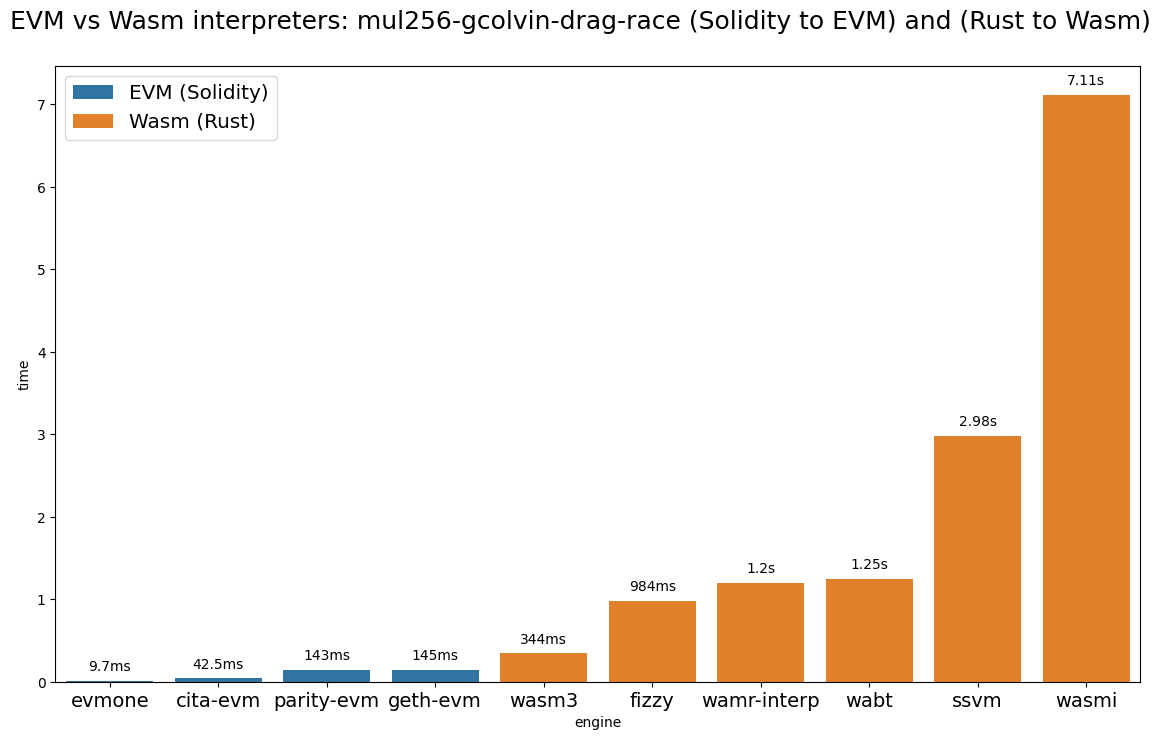

In [158]:
f = plotEVMvsWasm(df_evm_vs_wasm_mul256)

f.suptitle("EVM vs Wasm interpreters: mul256-gcolvin-drag-race (Solidity to EVM) and (Rust to Wasm)", fontsize=18, y=0.95)
f.savefig('../images/evm-vs-wasm-mul256-sol-rust.png', bbox_inches='tight')

## EVM vs wasm shootout: blake2b

In [159]:
df_evm_blake2b = df_evm_raw[df_evm_raw['test_name'].isin(['blake2b-8415-bytes', 'blake2b_huff-8415-bytes'])].copy()

df_evm_blake2b.rename(columns={'test_name':'bench_name', 'total_time':'exec_time'},inplace=True)
df_evm_blake2b.drop(['gas_used'],axis=1,inplace=True)
df_evm_blake2b.loc[:, 'parse_time'] = 0
df_evm_blake2b = df_evm_blake2b[['engine', 'bench_name', 'parse_time', 'exec_time']]

df_evm_blake2b.replace('blake2b-8415-bytes', 'blake2b-8kb.sol.evm', inplace=True)
df_evm_blake2b.replace('blake2b_huff-8415-bytes', 'blake2b-8kb.huff.evm', inplace=True)

In [160]:
df_wasm_blake2b = df_interp[df_interp['test_name'] == "blake2b-8415-bytes"].copy()

df_wasm_blake2b.rename(columns={'test_name':'bench_name'},inplace=True)
df_wasm_blake2b.drop(['elapsed_time'],axis=1,inplace=True)
df_wasm_blake2b.drop(['total_time'],axis=1,inplace=True)
#df_wasm_blake2b = df_wasm_blake2b[['engine', 'bench_name', 'parse_time', 'exec_time']]
df_wasm_blake2b.reset_index(inplace=True)
df_wasm_blake2b.replace('blake2b-8415-bytes', 'blake2b-8kb.rust.wasm', inplace=True)

In [161]:
df_evm_vs_wasm_blake2b = df_evm_blake2b.append(df_wasm_blake2b, sort=False).copy()

df_evm_vs_wasm_blake2b.loc[:,'time'] = df_evm_vs_wasm_blake2b['parse_time'].astype(float) + df_evm_vs_wasm_blake2b['exec_time'].astype(float)

df_evm_vs_wasm_blake2b = df_evm_vs_wasm_blake2b[df_evm_vs_wasm_blake2b['engine'].isin(
    ['parity-evm', 'geth-evm', 'evmone', 'cita-evm',
     'ssvm', 'wasmi', 'wabt', 'wamr-interp', 'fizzy', 'wasm3']
)].copy()

In [162]:
df_evm_vs_wasm_blake2b_sorted = df_evm_vs_wasm_blake2b.sort_values('time')

### blake2b.huff.evm vs blake2b.rust.wasm

In [163]:
df_blake2b_huff_vs_wasm = df_evm_vs_wasm_blake2b[df_evm_vs_wasm_blake2b['bench_name'].isin(
    ['blake2b-8kb.huff.evm', 'blake2b-8kb.rust.wasm']
)].copy()

In [164]:
df_blake2b_huff_vs_wasm = df_blake2b_huff_vs_wasm.sort_values('time')

In [165]:
df_blake2b_huff_vs_wasm.replace('blake2b-8kb.huff.evm', 'EVM (Huff)', inplace=True)
df_blake2b_huff_vs_wasm.replace('blake2b-8kb.rust.wasm', 'Wasm (Rust)', inplace=True)

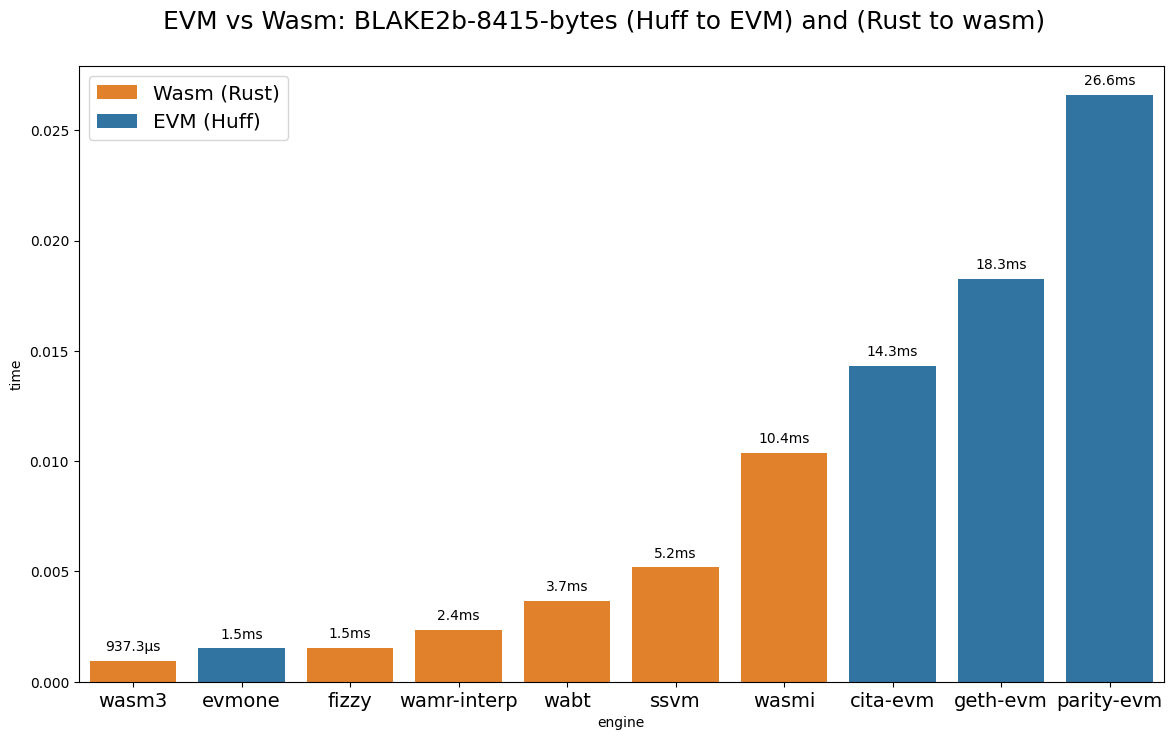

In [166]:
f = plotEVMvsWasm(df_blake2b_huff_vs_wasm, colors=['tab:orange', 'tab:blue'])

f.suptitle("EVM vs Wasm: BLAKE2b-8415-bytes (Huff to EVM) and (Rust to wasm)", fontsize=18, y=0.95)
f.savefig('../images/evm-vs-wasm-blake2b-huff-rust.png', bbox_inches='tight')

### blake2b.sol.evm vs blake2b.huff.evm


In [167]:
df_blake2b_sol_vs_huff = df_evm_vs_wasm_blake2b[df_evm_vs_wasm_blake2b['bench_name'].isin(
    ['blake2b-8kb.huff.evm', 'blake2b-8kb.sol.evm']
)].copy()

df_blake2b_sol_vs_huff = df_blake2b_sol_vs_huff.sort_values('time')

In [168]:
df_blake2b_sol_vs_huff

engine            bench_name  parse_time    exec_time      time
23       evmone  blake2b-8kb.huff.evm         0.0  0.001514828  0.001515
101    cita-evm  blake2b-8kb.huff.evm         0.0   0.01433503  0.014335
75     geth-evm  blake2b-8kb.huff.evm         0.0  0.018262182  0.018262
20       evmone   blake2b-8kb.sol.evm         0.0  0.022527799  0.022528
49   parity-evm  blake2b-8kb.huff.evm         0.0  0.026595507  0.026596
72     geth-evm   blake2b-8kb.sol.evm         0.0  0.150170679  0.150171
98     cita-evm   blake2b-8kb.sol.evm         0.0  0.271612442  0.271612
46   parity-evm   blake2b-8kb.sol.evm         0.0  0.340011586  0.340012

In [169]:
df_blake2b_sol_vs_huff.replace('blake2b-8kb.huff.evm', 'EVM (Huff)', inplace=True)
df_blake2b_sol_vs_huff.replace('blake2b-8kb.sol.evm', 'EVM (Solidity)', inplace=True)

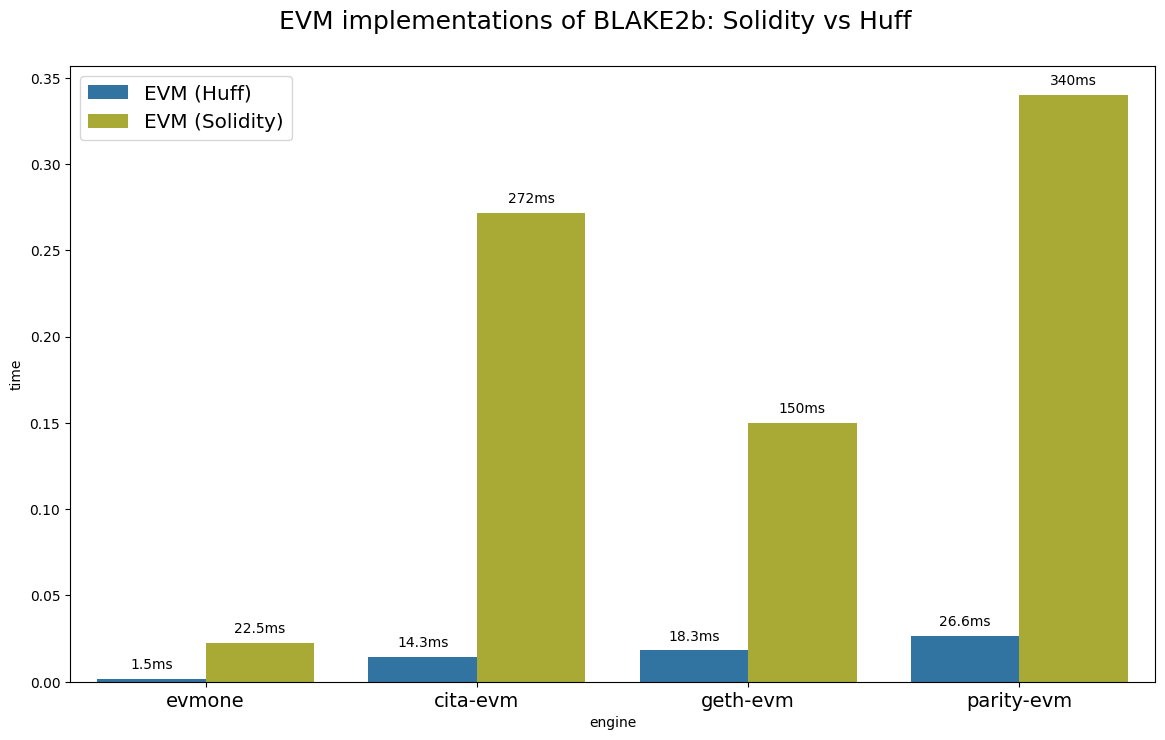

In [170]:
f = plotEVMvsWasm(df_blake2b_sol_vs_huff, colors=['tab:blue', 'tab:olive'], dodge=True)

f.suptitle("EVM implementations of BLAKE2b: Solidity vs Huff", fontsize=18, y=0.95)
f.savefig('../images/evm-vs-wasm-blake2b-sol-huff.png', bbox_inches='tight')

## plot blake2b.sol.evm against blake2b.rust.wasm

In [171]:
df_blake2b_sol_vs_rust = df_evm_vs_wasm_blake2b[df_evm_vs_wasm_blake2b['bench_name'].isin(
    ['blake2b-8kb.sol.evm', 'blake2b-8kb.rust.wasm']
)].copy()

df_blake2b_sol_vs_rust = df_blake2b_sol_vs_rust.sort_values('time')

In [172]:
df_blake2b_sol_vs_rust.replace('blake2b-8kb.rust.wasm', 'Wasm (Rust)', inplace=True)
df_blake2b_sol_vs_rust.replace('blake2b-8kb.sol.evm', 'EVM (Solidity)', inplace=True)

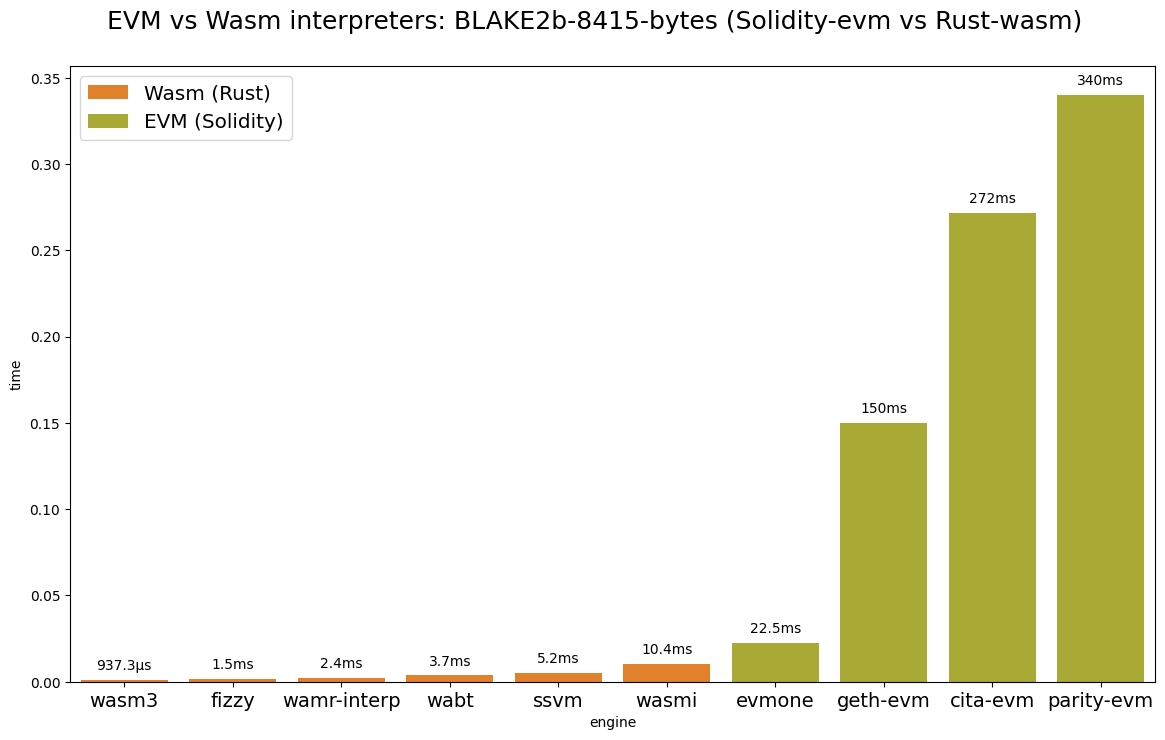

In [173]:
f = plotEVMvsWasm(df_blake2b_sol_vs_rust, colors=['tab:orange', 'tab:olive'], dodge=False)

f.suptitle("EVM vs Wasm interpreters: BLAKE2b-8415-bytes (Solidity-evm vs Rust-wasm)", fontsize=18, y=0.95)
f.savefig('../images/evm-vs-wasm-blake2b-sol-rust.png', bbox_inches='tight')

## blake2b: solidity vs huff vs rust

In [174]:
df_blake2b_sol_huff_rust = df_evm_vs_wasm_blake2b[df_evm_vs_wasm_blake2b['bench_name'].isin(
    ['blake2b-8kb.sol.evm', 'blake2b-8kb.huff.evm', 'blake2b-8kb.rust.wasm']
)].copy()

df_blake2b_sol_huff_rust = df_blake2b_sol_huff_rust.sort_values('time')

In [175]:
df_blake2b_sol_huff_rust.replace('blake2b-8kb.rust.wasm', 'Wasm (Rust)', inplace=True)
df_blake2b_sol_huff_rust.replace('blake2b-8kb.sol.evm', 'EVM (Solidity)', inplace=True)
df_blake2b_sol_huff_rust.replace('blake2b-8kb.huff.evm', 'EVM (Huff)', inplace=True)

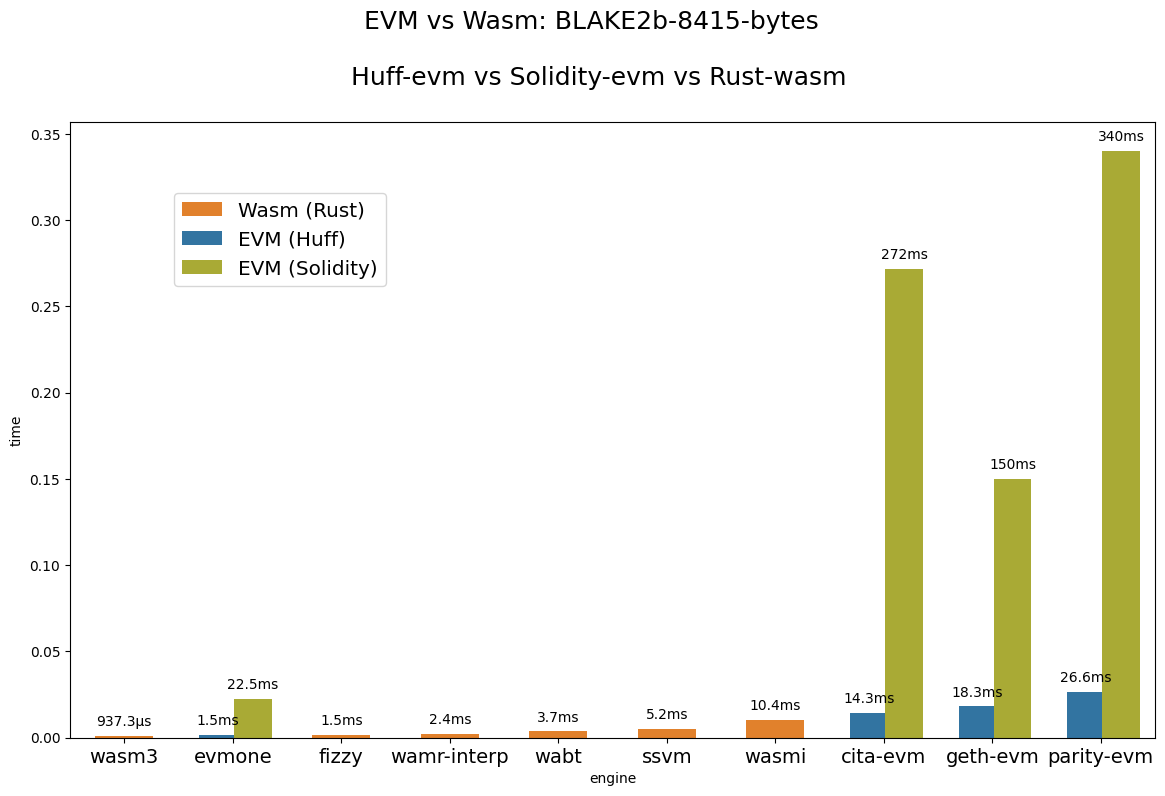

In [176]:
f = plt.figure(figsize=(14,8))
sns.reset_defaults() # use default colors, orange and blue
splot = sns.barplot(x='engine', y='time', hue='bench_name', dodge=True,
            palette=['tab:orange', 'tab:blue', 'tab:olive'],
            data=df_blake2b_sol_huff_rust)

for patch in splot.patches:
    current_width = patch.get_width()
    diff = current_width*1.3 - current_width

    # orange - couldn't find a way to look up patch color names nor covert RGB to name
    if patch.get_facecolor() == (0.8818627450980391, 0.5053921568627451, 0.17303921568627467, 1.0):
        diff = current_width*2 - current_width
        patch.set_width(current_width*2)
        patch.set_x(patch.get_x() + diff * .5)

    #blue
    if patch.get_facecolor() == (0.19460784313725488, 0.45343137254901944, 0.632843137254902, 1.0):
        patch.set_width(current_width*1.3)
        patch.set_x(patch.get_x() - diff * 2.2)

    #olive
    if patch.get_facecolor() == (0.6622549019607844, 0.6651960784313725, 0.2093137254901961, 1.0):
        patch.set_width(current_width*1.3)
        patch.set_x(patch.get_x() - diff * 1.5)

    #print(dir(patch))
    #print(patch.get_facecolor())


for p in splot.patches:
    splot.annotate(
                    toMs(p.get_height()),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center',
                    xytext = (0, 10),
                    textcoords = 'offset points')


plt.legend(fontsize='x-large', title_fontsize='40')
leg = splot.get_legend()
leg.set_bbox_to_anchor([0.3,0.9])

splot.set_xticklabels(splot.get_xticklabels(), size = 14)



f.suptitle("EVM vs Wasm: BLAKE2b-8415-bytes \n\n Huff-evm vs Solidity-evm vs Rust-wasm", fontsize=18, y=1.02)
f.savefig('../images/evm-vs-wasm-blake2b-huff-sol-rust.png', bbox_inches='tight')

## BLS benchmarks

In [177]:
df_scout_data[df_scout_data['bench_name'].str.contains('bls')]

engine  \
1                                          rust-native   
3                                          rust-native   
5                                          rust-native   
7                                          rust-native   
9                                          rust-native   
11                                         rust-native   
13                                         rust-native   
15                                         rust-native   
17                                         rust-native   
19                                         rust-native   
20                                  fizzy-with-bignums   
21                                  fizzy-with-bignums   
22                                               fizzy   
23                                  fizzy-with-bignums   
24                                  fizzy-with-bignums   
25                                               fizzy   
26                                  fizzy-with-bignums   
27                                  fizzy-with-bignums   
28                                               fizzy   
29                                  fizzy-with-bignums   
30                                  fizzy-with-bignums   
31                                               fizzy   
32                                  fizzy-with-bignums   
33                                  fizzy-with-bignums   
34                                               fizzy   
35                                     wabt-no-bignums   
49                                     wabt-no-bignums   
63                                     wabt-no-bignums   
77                                     wabt-no-bignums   
91                                     wabt-no-bignums   
105                                    wabt-no-bignums   
119                                    wabt-no-bignums   
133                                    wabt-no-bignums   
147                                    wabt-no-bignums   
161                                    wabt-no-bignums   
179                    wabt-fastmont-fasthost-superops   
180                    wabt-fastmont-fasthost-superops   
181                     wabt-fastmont-fasthost-f1m_mul   
182             wabt-fastmont-fasthost-f1m_mul-f1m_add   
183     wabt-fastmont-fasthost-f1m_mul-f1m_add-f1m_sub   
184  wabt-fastmont-fasthost-f1m_mul-f1m_add-f1m_sub...   
185  wabt-fastmont-fasthost-f1m_mul-f1m_add-f1m_sub...   
186  wabt-fastmont-fasthost-f1m_mul-f1m_add-f1m_sub...   
187  wabt-fastmont-fasthost-f1m_mul-f1m_add-f1m_sub...   
188                    wabt-fastmont-fasthost-superops   
189                    wabt-fastmont-fasthost-superops   
194                    wabt-fastmont-fasthost-superops   
195                    wabt-fastmont-fasthost-superops   
196                     wabt-fastmont-fasthost-f1m_mul   
197             wabt-fastmont-fasthost-f1m_mul-f1m_add   
198     wabt-fastmont-fasthost-f1m_mul-f1m_add-f1m_sub   
199  wabt-fastmont-fasthost-f1m_mul-f1m_add-f1m_sub...   
200  wabt-fastmont-fasthost-f1m_mul-f1m_add-f1m_sub...   
201  wabt-fastmont-fasthost-f1m_mul-f1m_add-f1m_sub...   
202  wabt-fastmont-fasthost-f1m_mul-f1m_add-f1m_sub...   
203                    wabt-fastmont-fasthost-superops   
204                    wabt-fastmont-fasthost-superops   
209                    wabt-fastmont-fasthost-superops   
210                    wabt-fastmont-fasthost-superops   
211                     wabt-fastmont-fasthost-f1m_mul   
212             wabt-fastmont-fasthost-f1m_mul-f1m_add   
213     wabt-fastmont-fasthost-f1m_mul-f1m_add-f1m_sub   
214  wabt-fastmont-fasthost-f1m_mul-f1m_add-f1m_sub...   
215  wabt-fastmont-fasthost-f1m_mul-f1m_add-f1m_sub...   
216  wabt-fastmont-fasthost-f1m_mul-f1m_add-f1m_sub...   
217  wabt-fastmont-fasthost-f1m_mul-f1m_add-f1m_sub...   
218                    wabt-fastmont-fasthost-superops   
219                    wabt-fastmont-fasthost-superops   
224                    wabt-fastmont-fasthost-

In [178]:
include_engines_list = ['rust-native', 'v8-liftoff', 'v8-turbofan',
                        'wabt-no-bignums', 'wabt-fastmont-fasthost-superops']

include_bench_names = ['bls12-wasmsnark-two-pairings',
                       'bls12-eip1962-rust-native-two-pairings']


df_scout_bls12 = \
    prepDfForRollupPlot(df_scout_data,
                        None,
                        include_bench_names,
                        only_include_engines=include_engines_list,
                        rename_engines=[
                            ['wabt-fastmont-fasthost-superops', 'wabt-with-bignums']
                        ])

df_scout_bls12 = df_scout_bls12.groupby(['engine']).mean()

In [179]:
df_scout_bls12

parse_time  exec_time
engine                                  
rust-native          0.000000   0.004322
v8-liftoff           0.004401   0.023080
v8-turbofan          0.009888   0.021535
wabt-no-bignums      0.002519   0.439332
wabt-with-bignums    0.004241   0.008966

<Figure size 640x480 with 0 Axes>

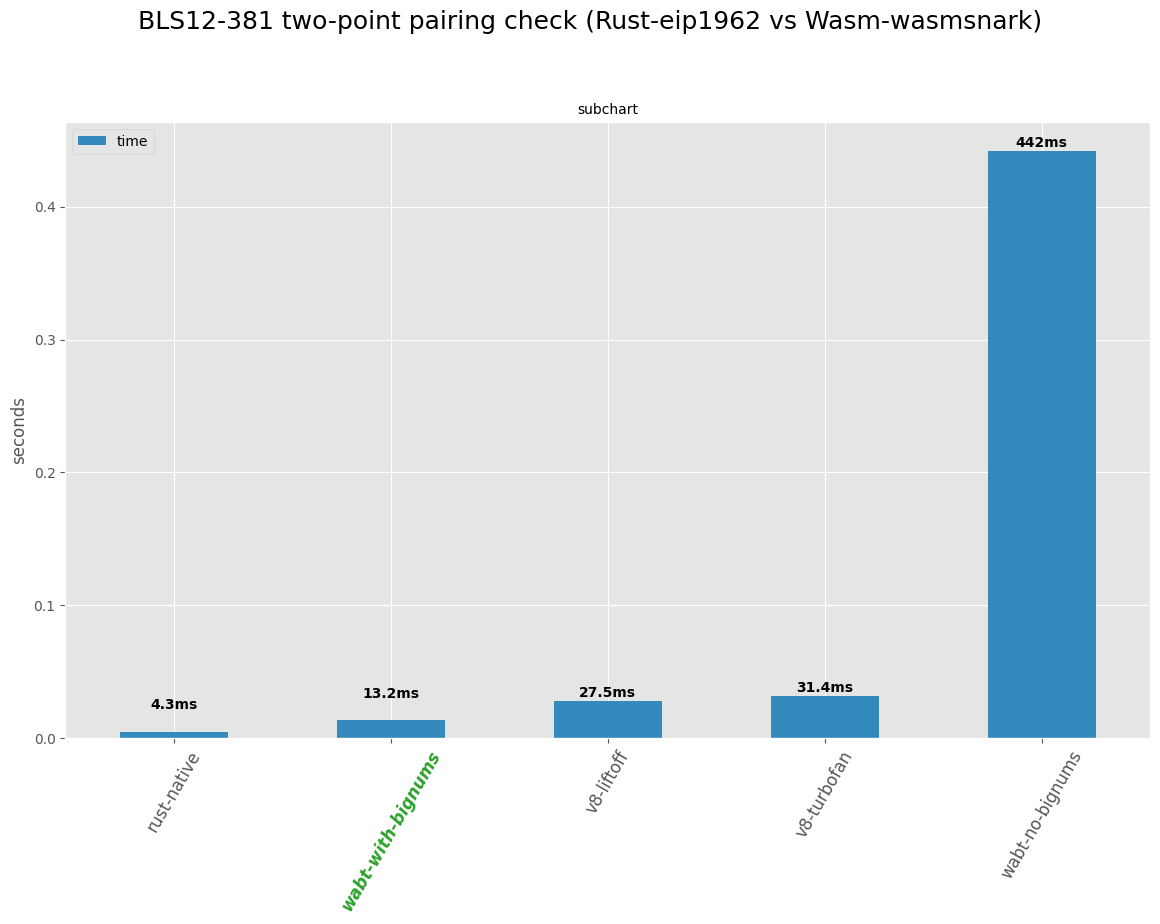

In [180]:
fig_plt = plotOneTestColoredTicks(df_scout_bls12,
            suptitle="BLS12-381 two-point pairing check (Rust-eip1962 vs Wasm-wasmsnark)",
            suptitle_pos=1.02,
            #subtitle="ecpairing-zkrollup-rust-wasm-bn128-two-pairings\n",
            #subtitle_size='xx-large',
            highlight_ticks=["wabt-with-bignums"])

fig_plt.savefig('../images/bignums-bls12-pairings-rust-vs-wasm-total-time.png', bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

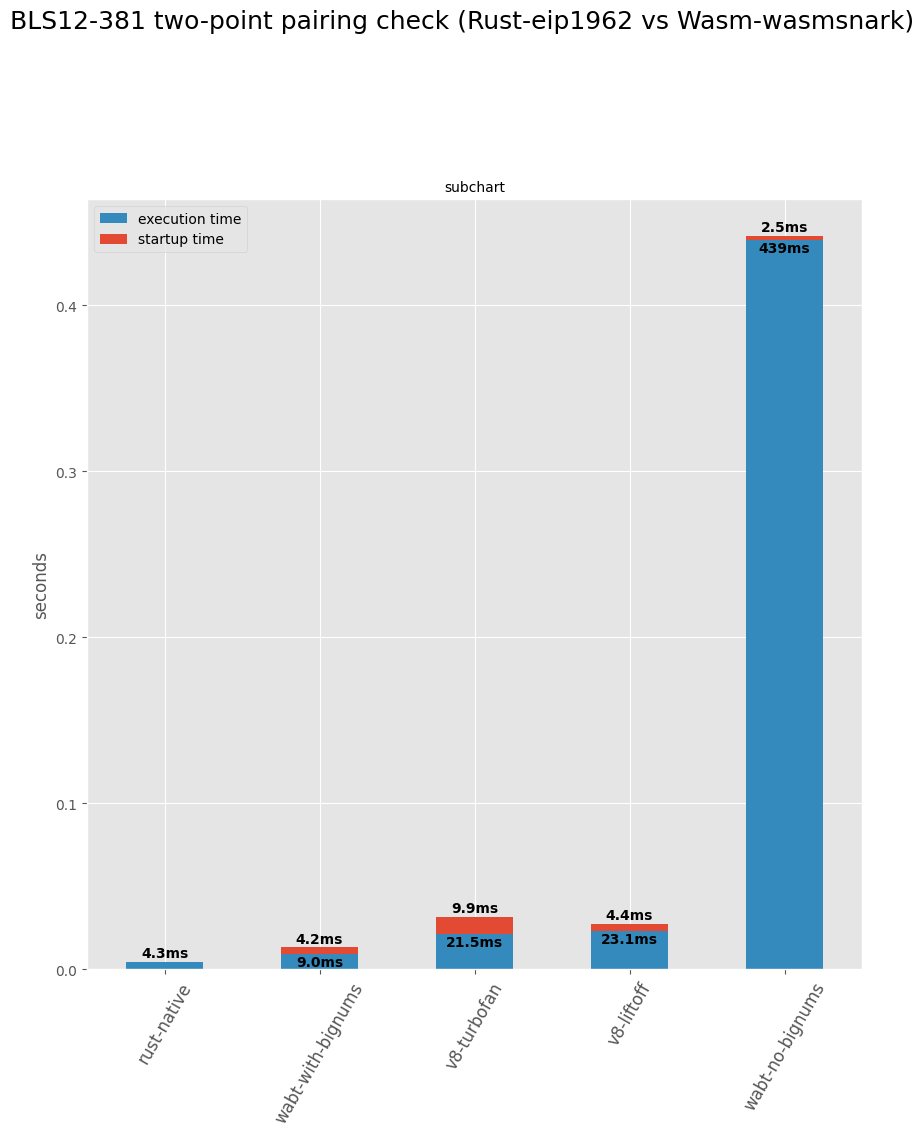

In [181]:
fig_plt = plotScoutStackedTest(df_scout_bls12,
            suptitle="BLS12-381 two-point pairing check (Rust-eip1962 vs Wasm-wasmsnark)",
            suptitle_pos=1.07,
            #subtitle="ecpairing-zkrollup-websnark-bn128-two-pairings\n",
            #subtitle_size='xx-large'
            )

fig_plt.savefig('../images/bignums-bls12-pairings-rust-vs-wasm-exec-startup-time.png', bbox_inches='tight')

## spectrum of bignum host funcs

In [182]:
include_engines_list = ['rust-native', 'v8-liftoff', 'v8-turbofan',
                        'wabt-no-bignums', 'wabt-fastmont-fasthost-superops',
                       'wabt-fastmont-fasthost-f1m_mul', 'wabt-fastmont-fasthost-f1m_mul-f1m_add',
                       'wabt-fastmont-fasthost-f1m_mul-f1m_add-f1m_sub', 'wabt-fastmont-fasthost-f1m_mul-f1m_add-f1m_sub-int_mul',
                       'wabt-fastmont-fasthost-f1m_mul-f1m_add-f1m_sub-int_mul-int_add', 'wabt-fastmont-fasthost-f1m_mul-f1m_add-f1m_sub-int_mul-int_add-int_sub',
                       'wabt-fastmont-fasthost-f1m_mul-f1m_add-f1m_sub-int_mul-int_add-int_sub-int_div']

include_bench_names = ['bls12-wasmsnark-two-pairings',
                       'bls12-eip1962-rust-native-two-pairings']

rename_engines= [
    ['wabt-fastmont-fasthost-f1m_mul', 'wabt-bignums-MULMODMONT'],
    ['wabt-fastmont-fasthost-f1m_mul-f1m_add', 'wabt-bignums-MULMODMONT-ADDMOD'],
    ['wabt-fastmont-fasthost-f1m_mul-f1m_add-f1m_sub', 'wabt-bignums-MULMODMONT-ADDMOD-SUBMOD'],
    ['wabt-fastmont-fasthost-f1m_mul-f1m_add-f1m_sub-int_mul', 'wabt-bignums-*MOD-INTMUL'],
    ['wabt-fastmont-fasthost-f1m_mul-f1m_add-f1m_sub-int_mul-int_add', 'wabt-bignums-*MOD-INTMUL-INTADD'],
    ['wabt-fastmont-fasthost-f1m_mul-f1m_add-f1m_sub-int_mul-int_add-int_sub', 'wabt-bignums-*MOD-INTMUL-INTADD-INTSUB'],
    ['wabt-fastmont-fasthost-f1m_mul-f1m_add-f1m_sub-int_mul-int_add-int_sub-int_div', 'wabt-bignums-*MOD-INTMUL-INTADD-INTSUB-INTDIV'],
    ['wabt-fastmont-fasthost-superops', 'wabt-bignums-all-hostfuncs-and-superops'],
    ['wabt-bignums-slowhost-slowmont', 'wabt-with-bignums']
]



df_scout_bls12_hostfunc_variations = \
    prepDfForRollupPlot(df_scout_data,
                        None,
                        include_bench_names,
                        only_include_engines=include_engines_list,
                        rename_engines=rename_engines
                       )

df_scout_bls12_hostfunc_variations = df_scout_bls12_hostfunc_variations.groupby(['engine']).mean()

<Figure size 640x480 with 0 Axes>

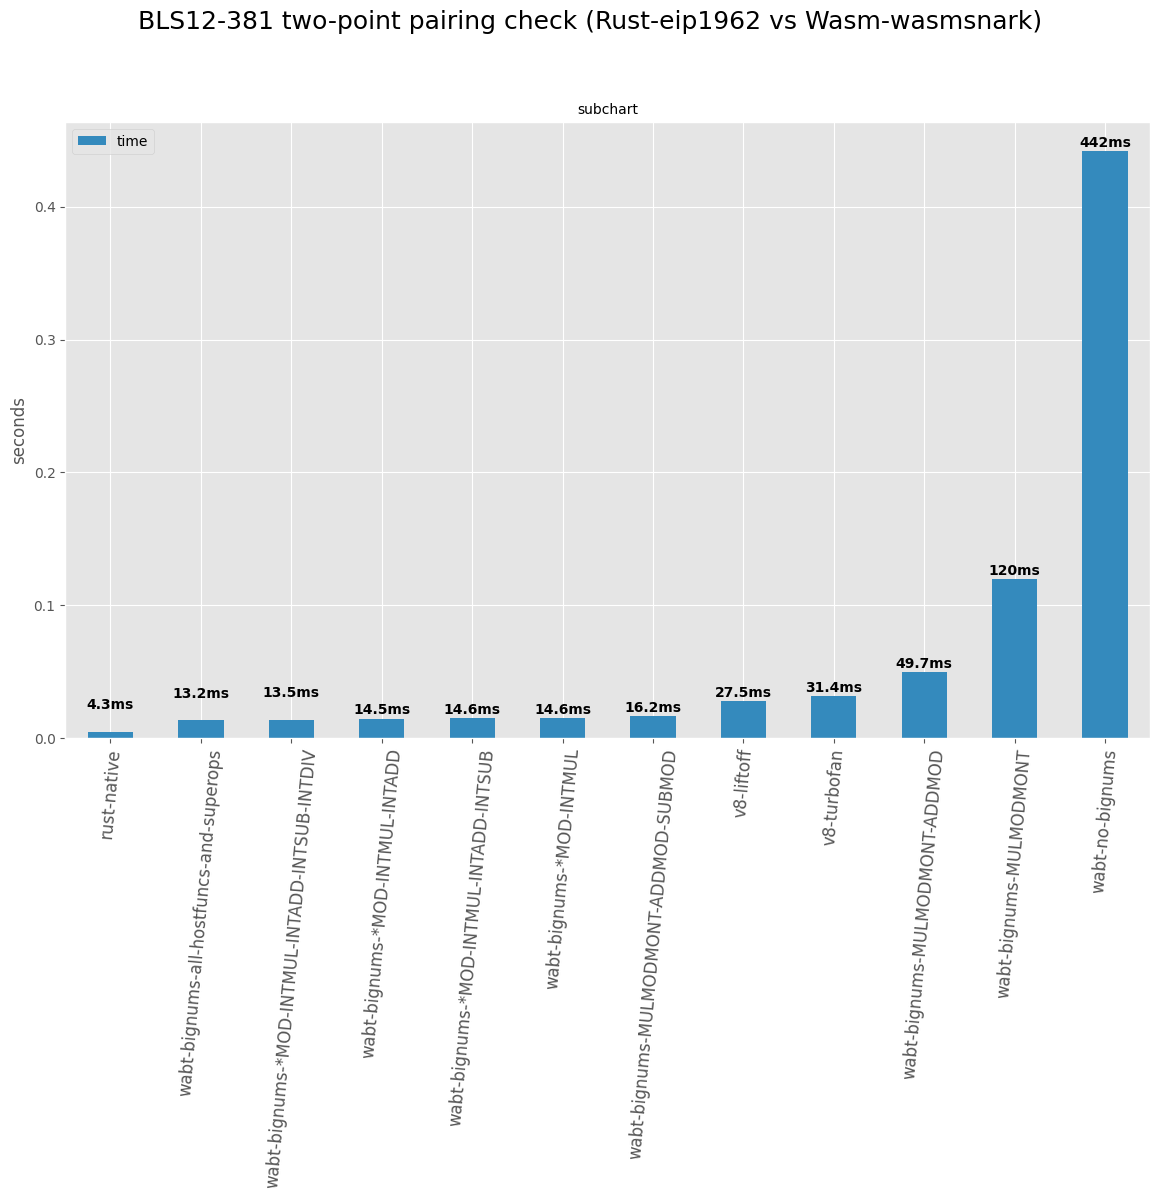

In [183]:
fig_plt = plotOneTestColoredTicksBLS(df_scout_bls12_hostfunc_variations,
            suptitle="BLS12-381 two-point pairing check (Rust-eip1962 vs Wasm-wasmsnark)",
            suptitle_pos=1.02,
            #subtitle="ecpairing-zkrollup-rust-wasm-bn128-two-pairings\n",
            #subtitle_size='xx-large',
            highlight_ticks=["wabt-with-bignums"])

fig_plt.savefig('../images/bignums-bls12-pairings-host-func-variations-total-time.png', bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

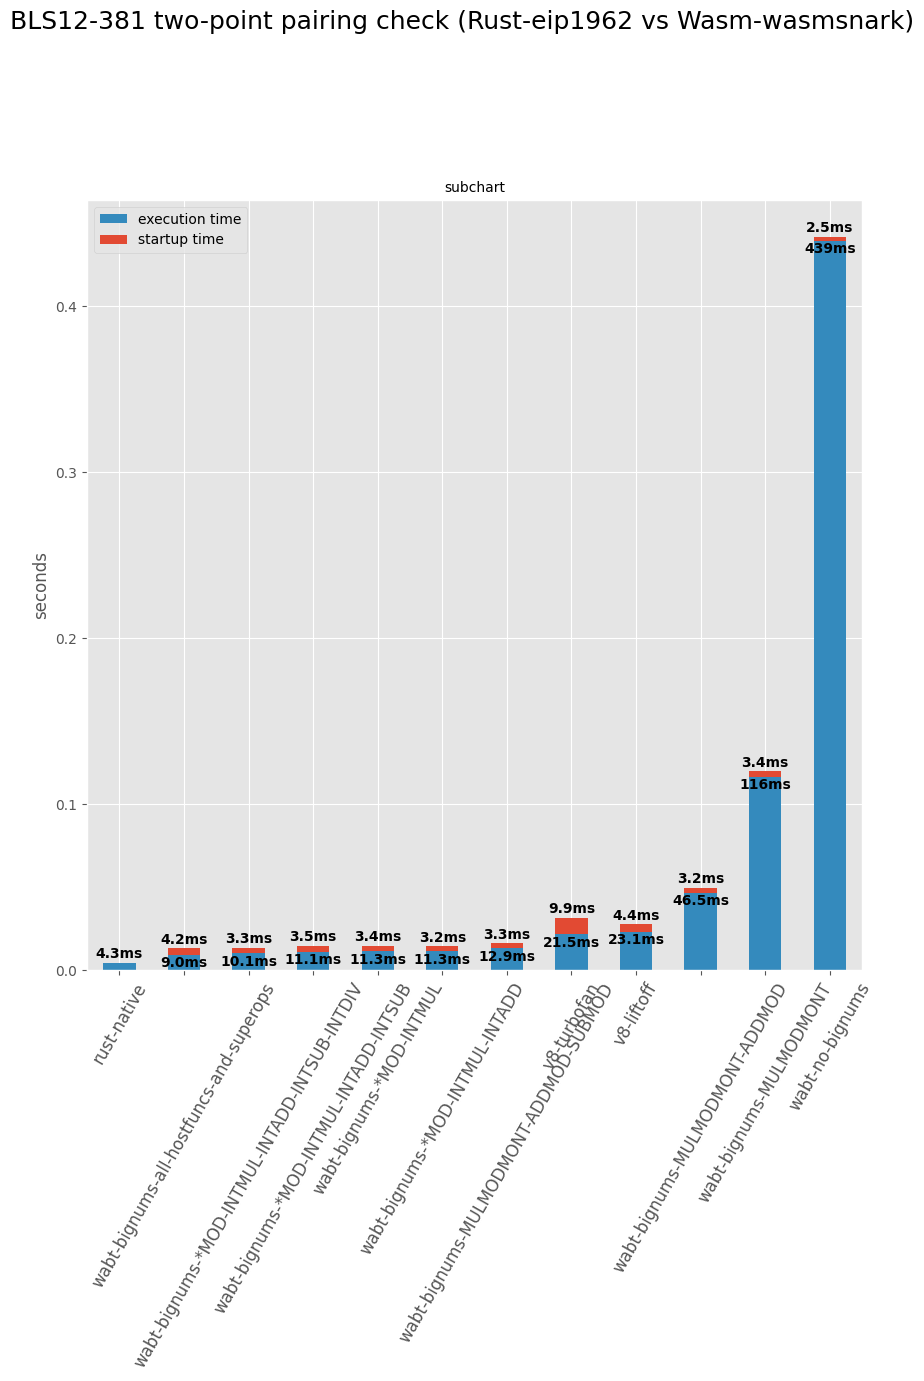

In [184]:
fig_plt = plotScoutStackedTest(df_scout_bls12_hostfunc_variations,
            suptitle="BLS12-381 two-point pairing check (Rust-eip1962 vs Wasm-wasmsnark)",
            suptitle_pos=1.07,
            #subtitle="ecpairing-zkrollup-websnark-bn128-two-pairings\n",
            #subtitle_size='xx-large'
            )

fig_plt.savefig('../images/bignums-bls12-pairings-host-func-variations-exec-startup-time.png', bbox_inches='tight')

## fizzy vs wabt - BLS12

In [185]:
include_engines_list = ['rust-native', 'fizzy-with-bignums', 'wabt-fastmont-fasthost-superops',
                        'wabt-no-bignums', 'fizzy']

include_bench_names = ['bls12-wasmsnark-two-pairings',
                       'bls12-wasmsnark-two-pairings-standalone',
                       'bls12-eip1962-rust-native-two-pairings']

# bls12-wasmsnark-two-pairings-standalone
# bls12-wasmsnark-synth-loop

df_fizzy_bls12 = \
    prepDfForRollupPlot(df_scout_data,
                        None,
                        include_bench_names,
                        only_include_engines=include_engines_list,
                        rename_engines=[
                            ['wabt-fastmont-fasthost-superops', 'wabt-with-bignums']
                        ])

df_fizzy_bls12 = df_fizzy_bls12.groupby(['engine']).mean()

In [186]:
df_fizzy_bls12

parse_time  exec_time
engine                                   
fizzy                 0.001030   0.350883
fizzy-with-bignums    0.001037   0.012025
rust-native           0.000000   0.004322
wabt-no-bignums       0.002519   0.439332
wabt-with-bignums     0.004165   0.008939

<Figure size 640x480 with 0 Axes>

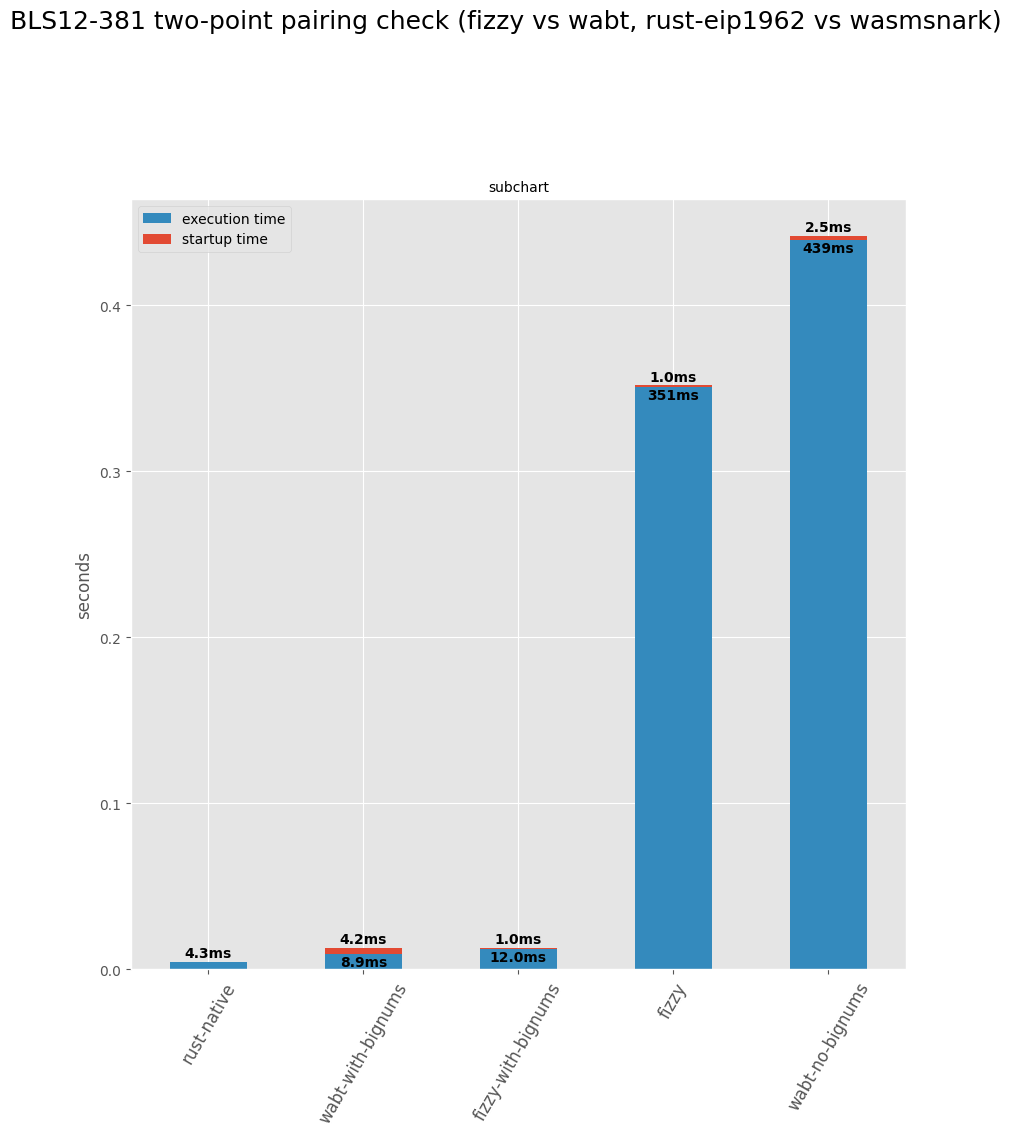

In [187]:
fig_plt = plotScoutStackedTest(df_fizzy_bls12,
            suptitle="BLS12-381 two-point pairing check (fizzy vs wabt, rust-eip1962 vs wasmsnark)",
            suptitle_pos=1.07,
            #subtitle="ecpairing-zkrollup-websnark-bn128-two-pairings\n",
            #subtitle_size='xx-large'
            )

fig_plt.savefig('../images/bignums-bls12-pairings-fizzy-vs-wabt-exec-startup-time.png', bbox_inches='tight')

## BLS12 synth loop

In [188]:
include_engines_list = ['fizzy-with-bignums', 'wabt-fastmont-fasthost-superops']

include_bench_names = ['bls12-wasmsnark-synth-loop']

# bls12-wasmsnark-two-pairings-standalone
# bls12-wasmsnark-synth-loop

df_bls12_synth_loop = \
    prepDfForRollupPlot(df_scout_data,
                        None,
                        include_bench_names,
                        only_include_engines=include_engines_list,
                        rename_engines=[
                            ['wabt-fastmont-fasthost-superops', 'wabt-with-bignums']
                        ])

df_bls12_synth_loop = df_bls12_synth_loop.groupby(['engine']).mean()

In [189]:
df_bls12_synth_loop

parse_time  exec_time
engine                                   
fizzy-with-bignums    0.001024   0.009604
wabt-with-bignums     0.006234   0.007518

<Figure size 640x480 with 0 Axes>

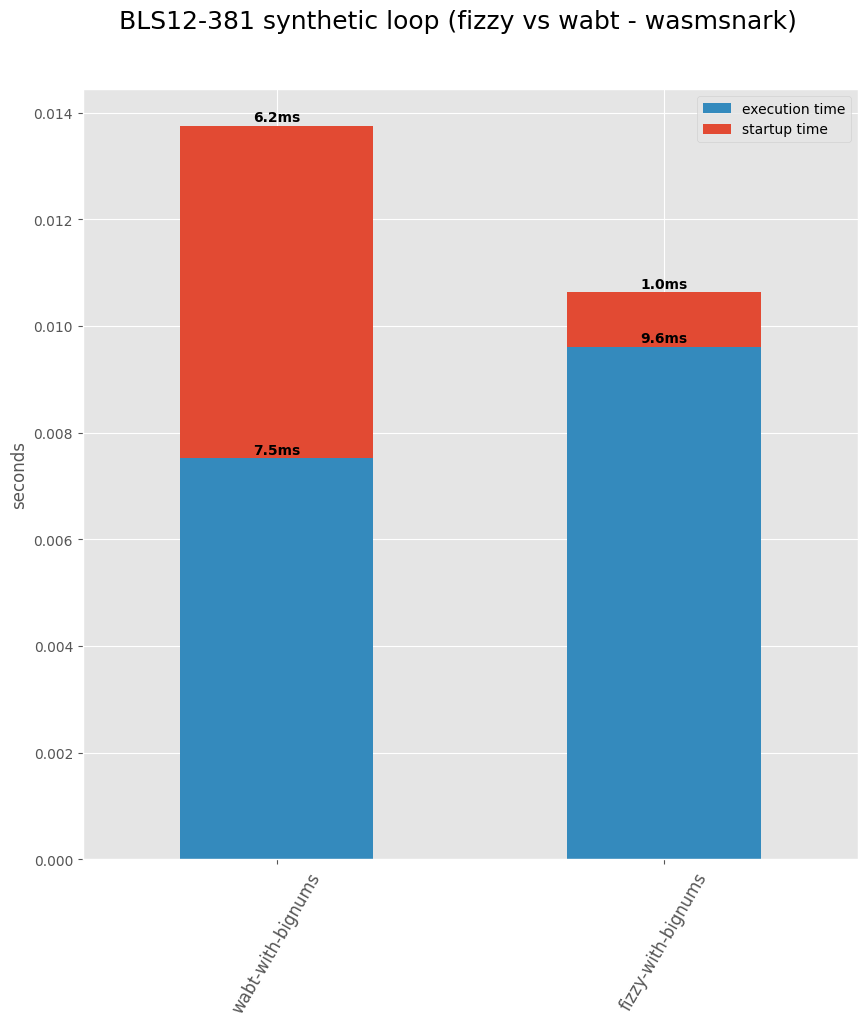

In [190]:
fig_plt = plotScoutStackedTest(df_bls12_synth_loop,
            suptitle="BLS12-381 synthetic loop (fizzy vs wabt - wasmsnark)",
            suptitle_pos=0.96,
            subtitle="",
            #subtitle_size='xx-large'
            )

fig_plt.savefig('../images/bignums-bls12-synth-loop-fizzy-vs-wabt-exec-startup-time.png', bbox_inches='tight')

In [191]:
include_engines_list = ['fizzy-with-bignums', 'wabt-fastmont-fasthost-superops']

include_bench_names = ['bls12-wasmsnark-two-pairings-standalone', 'bls12-wasmsnark-synth-loop']

df_bls12_synth_vs_pairing = \
    prepDfForRollupPlot(df_scout_data,
                        None,
                        include_bench_names,
                        only_include_engines=include_engines_list,
                        rename_engines=[
                            ['bls12-wasmsnark-two-pairings-standalone', 'bls12-two-pairings'],
                            ['bls12-wasmsnark-synth-loop', 'bls12-synth-loop'],
                            ['wabt-fastmont-fasthost-superops', 'wabt-with-bignums']
                        ])


<Figure size 640x480 with 0 Axes>

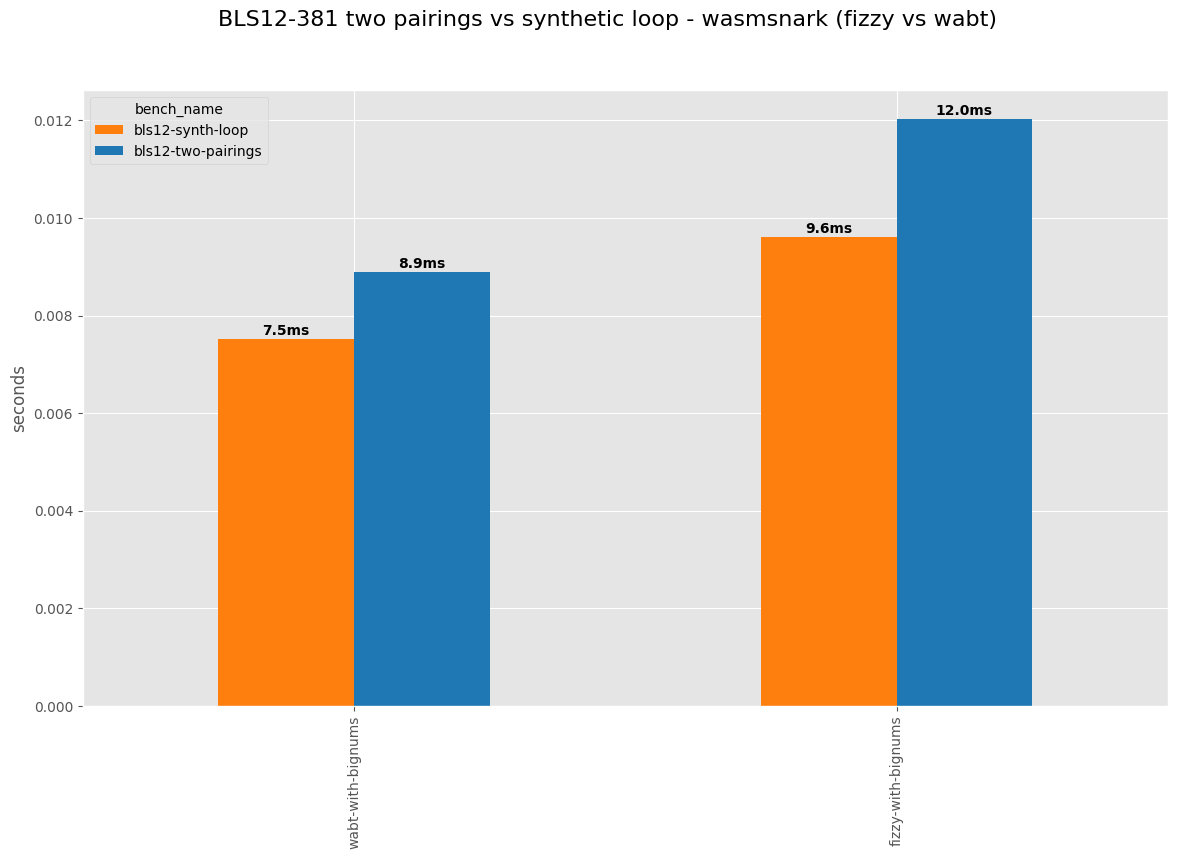

In [192]:
fig_plt = plotOneTestGroupedExexTime(df_bls12_synth_vs_pairing,
                   title="BLS12-381 two pairings vs synthetic loop - wasmsnark (fizzy vs wabt)",
                   test_title="",
                   group_order=['bls12-synth-loop', 'bls12-two-pairings'],
                   sort_by=['bls12-synth-loop'],
                   colors=['tab:orange', 'tab:blue'])


fig_plt.savefig('../images/evm384-bls12-synth-loop-vs-pairings.png', bbox_inches='tight')

## Plot evm384 bls synth loop results

In [193]:
df_evm384 = df_evm_raw[df_evm_raw['engine'] == 'evmone384']

In [194]:
df_evm384

engine             test_name   total_time  gas_used
105  evmone384  evm384-synth-loop-v1  0.023534375  12569235
106  evmone384  evm384-synth-loop-v2  0.015339457   5851179

In [195]:
df_scout_rust_native = df_scout_data[df_scout_data['engine'] == 'rust-native']

df_scout_rust_native_bls12 = df_scout_rust_native[df_scout_rust_native['bench_name'] == 'bls12-eip1962-rust-native-two-pairings']

df_scout_rust_native_bls12 = df_scout_rust_native_bls12.groupby(['engine']).mean()

In [196]:
# proposed gas from EIP-2537, for a BLS12-381 pairing operation is 23000*k + 115000 where k is a number of pairs.

eip2537_proposed_gas = 23000*2 + 115000

df_scout_rust_native_bls12['gas'] = eip2537_proposed_gas
df_scout_rust_native_bls12['test_name'] = "bls12-eip1962-rust-native-two-pairings"


In [197]:
df_scout_rust_native_bls12

parse_time  exec_time     gas  \
engine                                       
rust-native         NaN   0.004322  161000   

                                          test_name  
engine                                               
rust-native  bls12-eip1962-rust-native-two-pairings

In [198]:
df_scout_rust_native_bls12_merge = df_scout_rust_native_bls12.copy()
df_scout_rust_native_bls12_merge.drop(columns=['parse_time'], inplace=True)
df_scout_rust_native_bls12_merge.reset_index(inplace=True)
df_scout_rust_native_bls12_merge.columns = ['engine', 'time', 'gas', 'test_name']
df_scout_rust_native_bls12_merge = df_scout_rust_native_bls12_merge[['engine','test_name','time','gas']]


In [199]:
df_scout_rust_native_bls12_merge

engine                               test_name      time     gas
0  rust-native  bls12-eip1962-rust-native-two-pairings  0.004322  161000

In [200]:
df_evm384_merge = df_evm384.copy()
df_evm384_merge.columns = ['engine', 'test_name', 'time', 'gas']


In [201]:
df_evm384_merge

engine             test_name         time       gas
105  evmone384  evm384-synth-loop-v1  0.023534375  12569235
106  evmone384  evm384-synth-loop-v2  0.015339457   5851179

## TODO: scale synthetic loop time/gas by a factor determined from the wasm runtimes (wasm-pairing / wasm-synth-loop)

In [202]:
df_evm384_native = pd.concat([df_evm384_merge, df_scout_rust_native_bls12_merge], sort=False)
df_evm384_native.reset_index(drop=True, inplace=True)
df_evm384_native.set_index('engine', inplace=True)


In [203]:
df_evm384_native

test_name         time       gas
engine                                                                    
evmone384                      evm384-synth-loop-v1  0.023534375  12569235
evmone384                      evm384-synth-loop-v2  0.015339457   5851179
rust-native  bls12-eip1962-rust-native-two-pairings    0.0043215    161000

In [204]:
df_evm384_native['time'] = pd.to_numeric(df_evm384_native['time'])
df_evm384_native['gas'] = pd.to_numeric(df_evm384_native['gas'])

df_evm384_native['Mgas/s'] = (df_evm384_native['gas'] / df_evm384_native['time']) * (1 / 10**6)

In [205]:
df_evm384_native

test_name      time       gas  \
engine                                                                    
evmone384                      evm384-synth-loop-v1  0.023534  12569235   
evmone384                      evm384-synth-loop-v2  0.015339   5851179   
rust-native  bls12-eip1962-rust-native-two-pairings  0.004322    161000   

                 Mgas/s  
engine                   
evmone384    534.079830  
evmone384    381.446292  
rust-native   37.255583

In [206]:
def byEngineExecTime(df_benchdata, engine):
    #print("engine:", engine)
    #print("min_time:", df_benchdata.loc[engine]['exec_time'].max())
    return df_benchdata.loc[engine]['time'].max()


def plotTimeVsGas(df_benchdata, title=""):
    #sorted_engines = sorted(['evmone384', 'rust-native'], key=lambda x: byEngineExecTime(df_benchdata, x))
    columns_to_plot = ['time']
    df_plotdata = df_benchdata.copy()
    df_plotdata = df_plotdata.set_index('test_name')
    plt.figure()
    f, subplot_axes = plt.subplots(1, 2, sharex=False, figsize=(10,3))

    time_axis = subplot_axes[0]
    gas_axis = subplot_axes[1]
    #time_axis.set_title(sorted_engines[i])

    df_plotdata[['time']].plot.barh(ax=time_axis, color=['steelblue'])
    # set blank to hide "test_name"
    time_axis.set(ylabel='')
    time_axis.legend(loc='upper right', bbox_to_anchor=(1.0, 1.2))

    # label lower axis on bottom plot
    time_axis.set(ylabel='', xlabel='seconds')

    #for i, engine in enumerate(sorted_engines):
    labelBarWidths(time_axis)

    df_plotdata[['gas']].plot.barh(ax=gas_axis, color=['olive'])

    gas_axis.legend(loc='upper right', bbox_to_anchor=(1.0, 1.2))

    mgas0 = df_plotdata.iloc[0]['Mgas/s']
    mgas1 = df_plotdata.iloc[1]['Mgas/s']
    mgas2 = df_plotdata.iloc[2]['Mgas/s']
    
    mgas_txt = "{} Mgas/s".format(round(mgas0,1))
    gas_axis.text(1.05, 0.2, mgas_txt, fontsize=10, transform=gas_axis.transAxes)

    mgas_txt = "{} Mgas/s".format(round(mgas1,1))
    gas_axis.text(1.05, 0.5, mgas_txt, fontsize=10, transform=gas_axis.transAxes)

    mgas_txt = "{} Mgas/s".format(round(mgas2,1))
    gas_axis.text(1.05, 0.8, mgas_txt, fontsize=10, transform=gas_axis.transAxes)
    
    
    # label lower axis on bottom plot
    gas_axis.set(ylabel='', xlabel='gas')
    gas_axis.label_outer()

    
    f.suptitle(title, fontsize=16, y=1.22)
    f.subplots_adjust(hspace=0.5)
    return f


<Figure size 640x480 with 0 Axes>

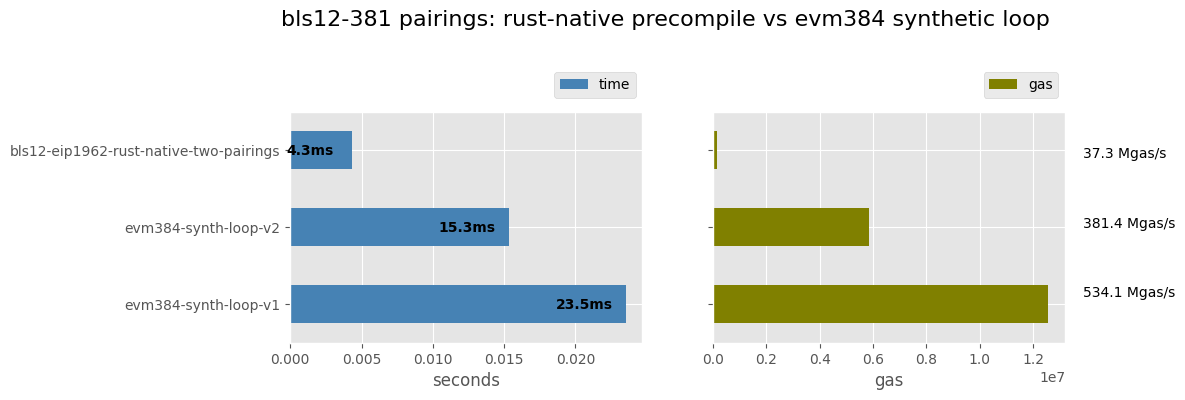

In [207]:
fig_plt = plotTimeVsGas(df_evm384_native, "bls12-381 pairings: rust-native precompile vs evm384 synthetic loop")

fig_plt.savefig('../images/evm384-bls12-synth-loop-vs-native-rust.png', bbox_inches='tight')

## bls12 pairings and synth loop - wasm, evm384, rust-native

In [208]:
df_bls_wasm_merge = df_bls12_synth_vs_pairing.copy()

In [209]:
df_bls_wasm_merge.drop(columns=['parse_time', 'exec_time'], inplace=True)

df_bls_wasm_merge['engine_bench_name'] = df_bls_wasm_merge['engine'] + "--" + df_bls_wasm_merge['bench_name']
df_bls_wasm_merge.drop(columns=['engine', 'bench_name'], inplace=True)

In [210]:
df_bls_wasm_merge = df_bls_wasm_merge.groupby(['engine_bench_name']).mean()
df_bls_wasm_merge.reset_index(inplace=True)

In [211]:
df_bls_wasm_merge

engine_bench_name      time
0    fizzy-with-bignums--bls12-synth-loop  0.009604
1  fizzy-with-bignums--bls12-two-pairings  0.012025
2     wabt-with-bignums--bls12-synth-loop  0.007518
3   wabt-with-bignums--bls12-two-pairings  0.008886

In [212]:
df_evm384_native_merge = df_evm384_native.copy()
df_evm384_native_merge.drop(columns=['gas', 'Mgas/s'], inplace=True)
df_evm384_native_merge.reset_index(inplace=True)
df_evm384_native_merge.columns = ['engine', 'bench_name', 'time']

In [213]:
df_evm384_native_merge

engine                              bench_name      time
0    evmone384                    evm384-synth-loop-v1  0.023534
1    evmone384                    evm384-synth-loop-v2  0.015339
2  rust-native  bls12-eip1962-rust-native-two-pairings  0.004322

In [214]:
df_evm384_native_merge['engine_bench_name'] = df_evm384_native_merge['engine'] + "--" + df_evm384_native_merge['bench_name']

In [215]:
df_evm384_native_merge.drop(columns=['engine', 'bench_name'], inplace=True)
df_evm384_native_merge = df_evm384_native_merge[['engine_bench_name', 'time']]

In [216]:
df_evm384_native_merge

engine_bench_name      time
0                    evmone384--evm384-synth-loop-v1  0.023534
1                    evmone384--evm384-synth-loop-v2  0.015339
2  rust-native--bls12-eip1962-rust-native-two-pai...  0.004322

In [217]:
df_evm384_wasm_native = pd.concat([df_evm384_native_merge, df_bls_wasm_merge], sort=False)
df_evm384_wasm_native.reset_index(drop=True, inplace=True)
df_evm384_wasm_native.set_index('engine_bench_name', inplace=True)

In [218]:
df_evm384_wasm_native

time
engine_bench_name                                           
evmone384--evm384-synth-loop-v1                     0.023534
evmone384--evm384-synth-loop-v2                     0.015339
rust-native--bls12-eip1962-rust-native-two-pair...  0.004322
fizzy-with-bignums--bls12-synth-loop                0.009604
fizzy-with-bignums--bls12-two-pairings              0.012025
wabt-with-bignums--bls12-synth-loop                 0.007518
wabt-with-bignums--bls12-two-pairings               0.008886

<Figure size 640x480 with 0 Axes>

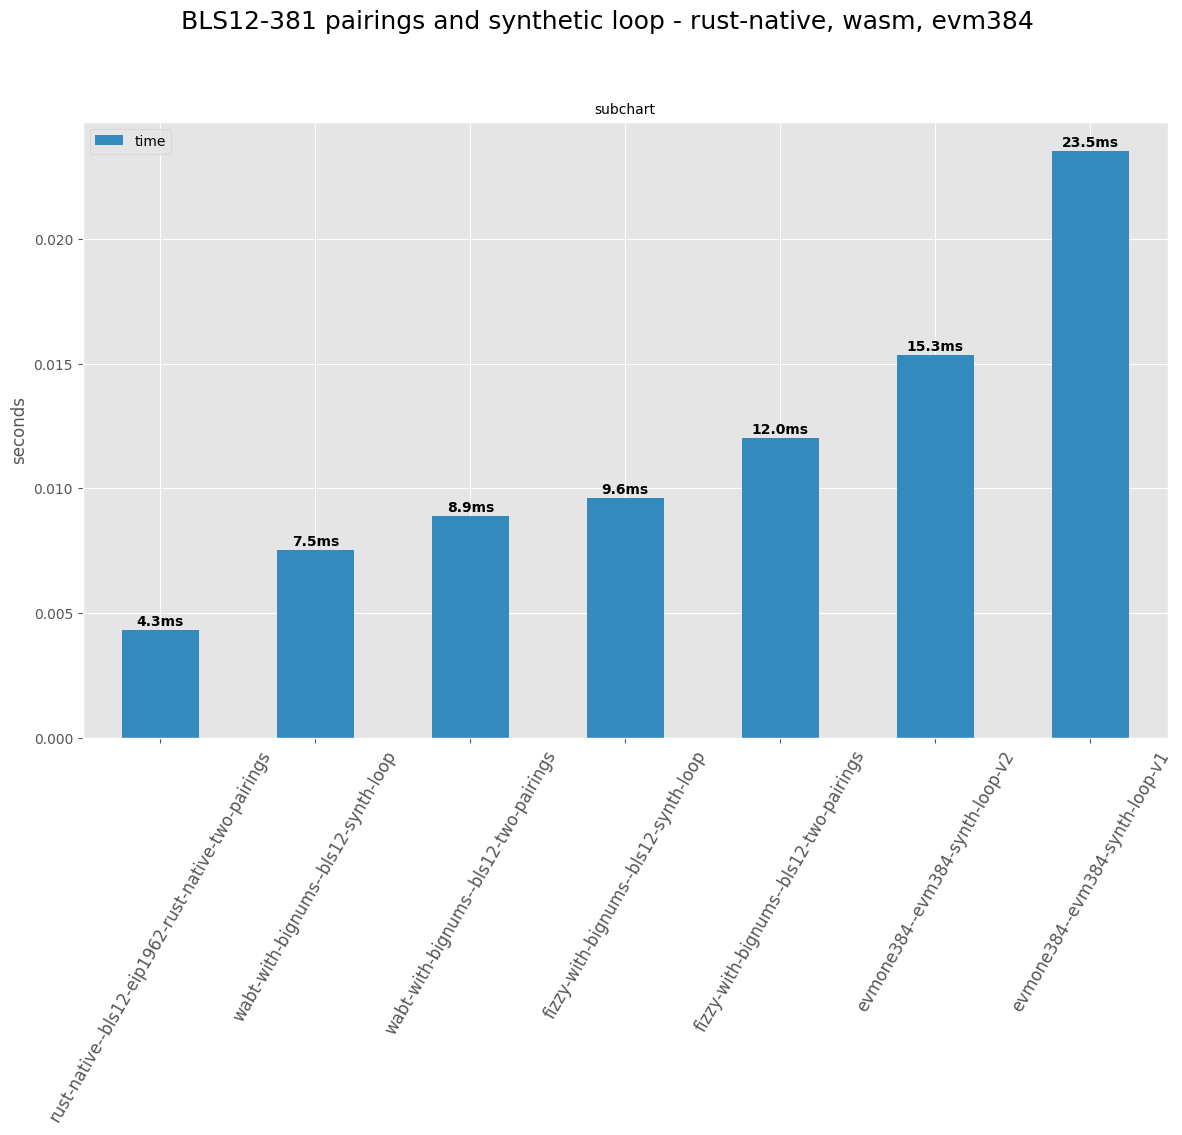

In [219]:
fig_plt = plotOneTestUsingTimeCol(df_evm384_wasm_native,
            suptitle="BLS12-381 pairings and synthetic loop - rust-native, wasm, evm384",
            suptitle_pos=1.02)

fig_plt.savefig('../images/evm384-bls12-pairings-synth-loop-rust-wasm.png', bbox_inches='tight')

In [220]:
df_evm384_wasm_synth_loop = df_evm384_wasm_native.copy()
df_evm384_wasm_synth_loop.reset_index(inplace=True)

In [221]:
df_evm384_wasm_synth_loop = df_evm384_wasm_synth_loop[df_evm384_wasm_synth_loop['engine_bench_name'].str.contains("synth")]

In [222]:
df_evm384_wasm_synth_loop.set_index('engine_bench_name', inplace=True)

<Figure size 640x480 with 0 Axes>

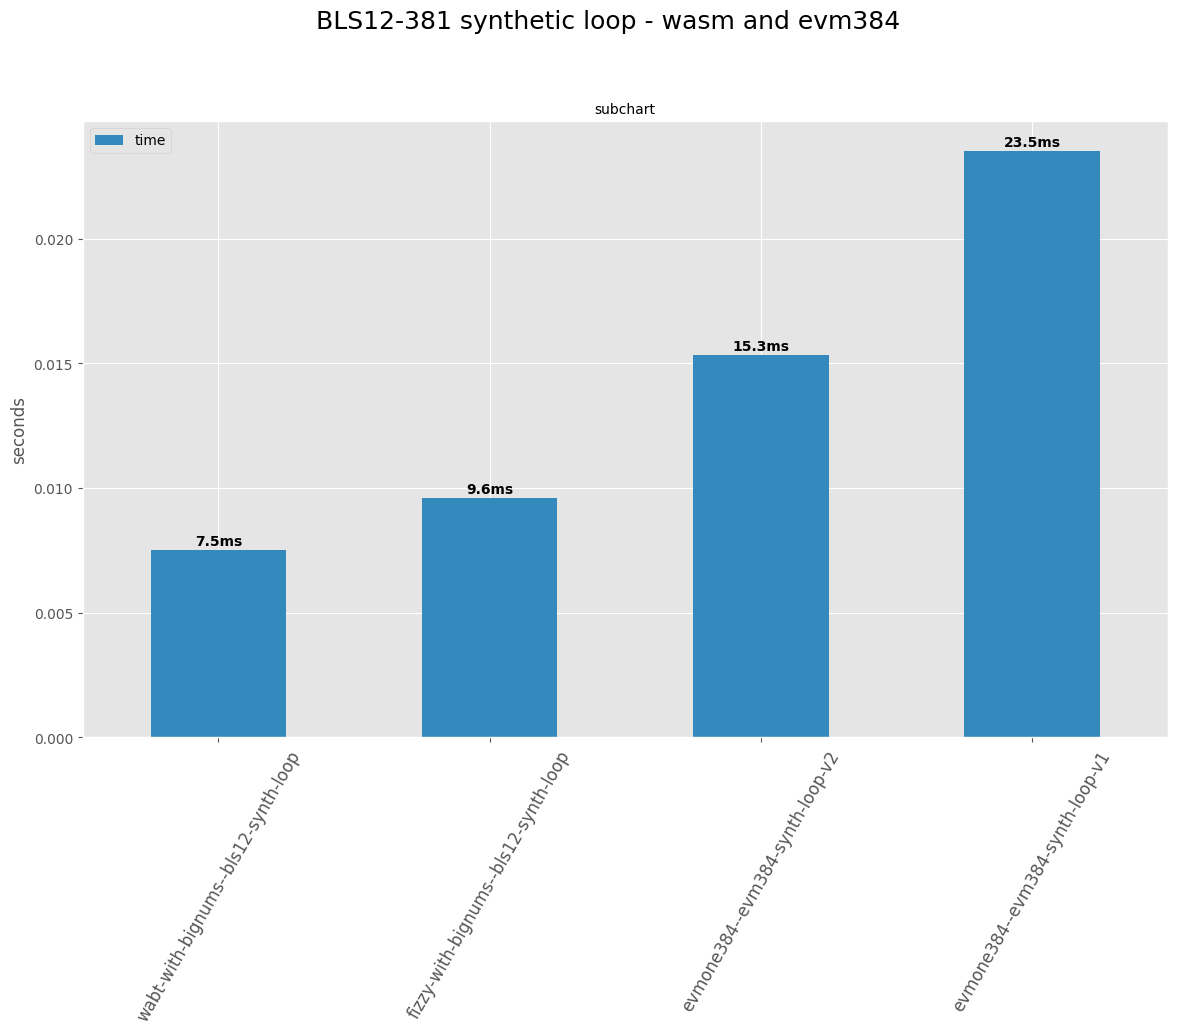

In [223]:
fig_plt = plotOneTestUsingTimeCol(df_evm384_wasm_synth_loop,
            suptitle="BLS12-381 synthetic loop - wasm and evm384",
            suptitle_pos=1.02)

fig_plt.savefig('../images/evm384-bls12-synth-loop-wasm.png', bbox_inches='tight')
fig_plt.show()